Last (?) crack at getting the flux scaling right.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d
from scipy.io.idl import readsav


import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io.votable import parse


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Just try with GJ676 (flux cal is obviously wrong) and see how it goes

In [67]:
testpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/'
# ! ls /media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ699/
specs = glob.glob('{}*.fits'.format(testpath))
specs

['/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_cos_gj676a_g130m_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_stis_gj676a_g140l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_stis_gj676a_g140m_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_stis_gj676a_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_stis_gj676a_g430l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_model_apec_gj676a_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_model_euv-scaling_gj676a_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_model_lya-reconstruction_gj676a_na_v10_component-spec.fits',

In [38]:
odata = fits.getdata(specs[4], 1)
ow, of, oe = odata['WAVELENGTH'], odata['FLUX'], odata['ERROR']
ndata = fits.getdata(specs[3], 1)
nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
pdata = fits.getdata(specs[8], 1)
pw, pf = pdata['WAVELENGTH'], pdata['FLUX']
fdata = fits.getdata(specs[1], 1)
fw, ff, fe = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']


In [39]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

In [41]:
pmask = (pw > 1000) & (pw < 7000)
pw, pf = pw[pmask], pf[pmask]
pf *= fits.getheader(specs[8], )['NORMFAC']

In [42]:
pw, pf = smear(pw, pf, 1000)

In [43]:
bin_width = 30
# w, f, e = g430l['WAVELENGTH'], g430l['FLUX'], g430l['ERROR']
sn = np.array([np.mean(of[i:i+bin_width]/oe[i:i+bin_width]) for i in range(len(ow[:-bin_width]))])
start = ow[:-bin_width][np.where(sn > 1)[0][0]]
mask = (ow > start)
ow, of, oe = ow[mask], of[mask], oe[mask]

(1e-17, 7.01140268813714e-12)

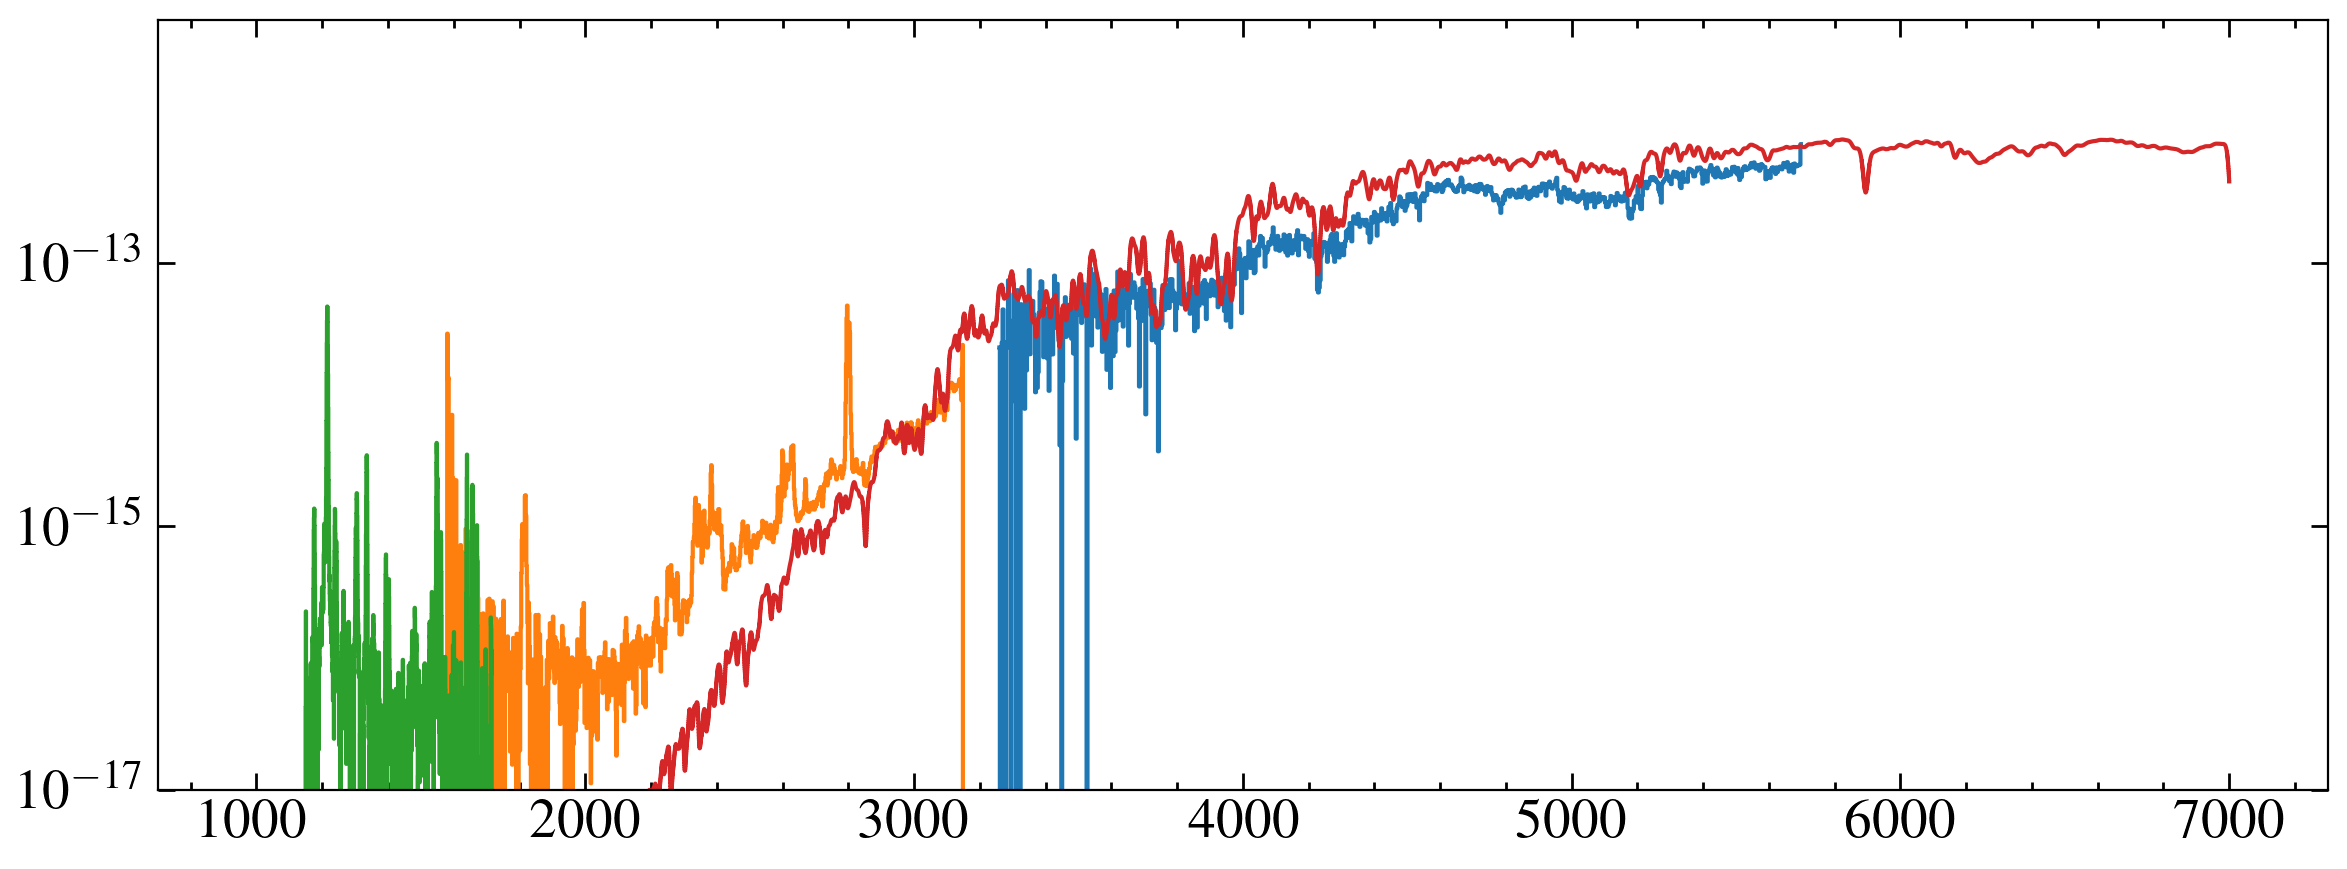

In [46]:
plt.step(ow, of, where='mid')
plt.step(nw, nf, where='mid')
plt.step(fw, ff, where='mid')

plt.step(pw, pf, where='mid')

plt.yscale('log')
plt.ylim(1e-17)

1.7731797184742814e-14 1.4586132811091182e-14 1.2156613006608368


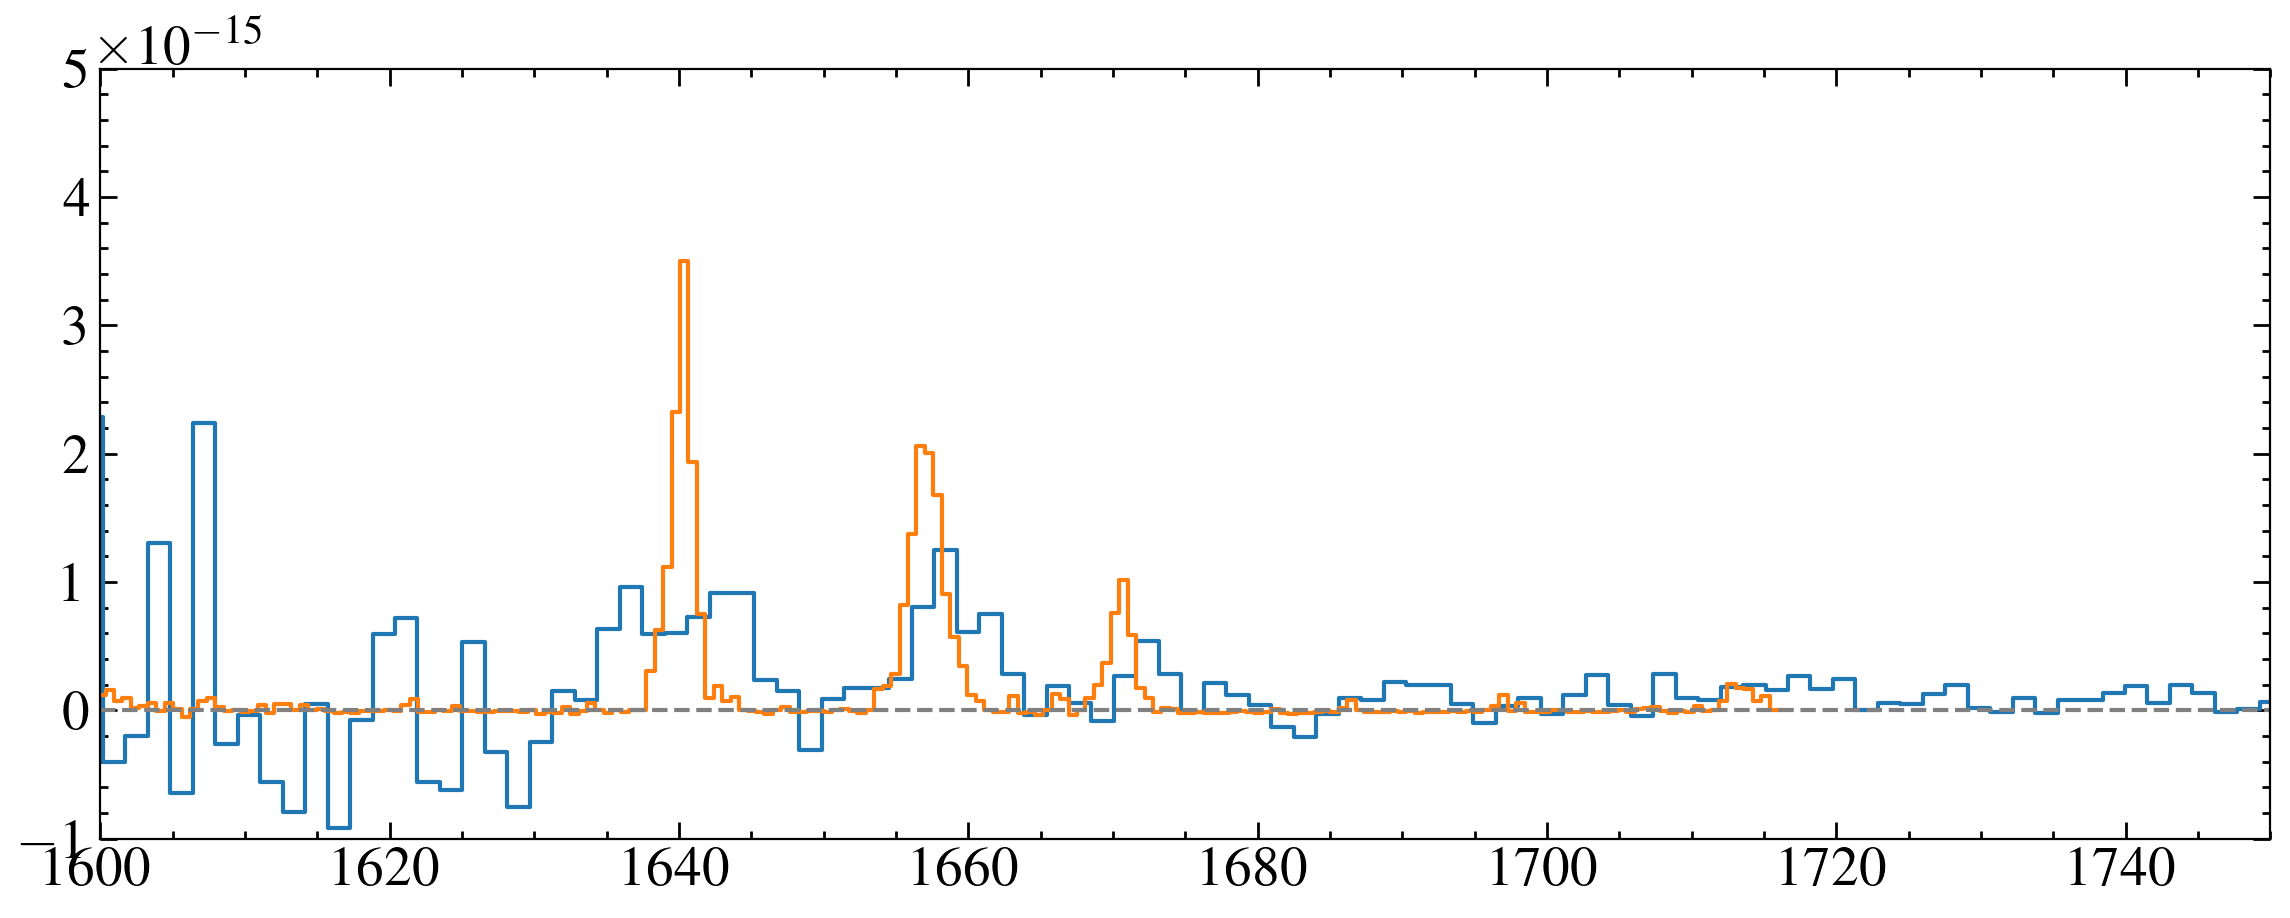

(-1e-15, 5e-15)

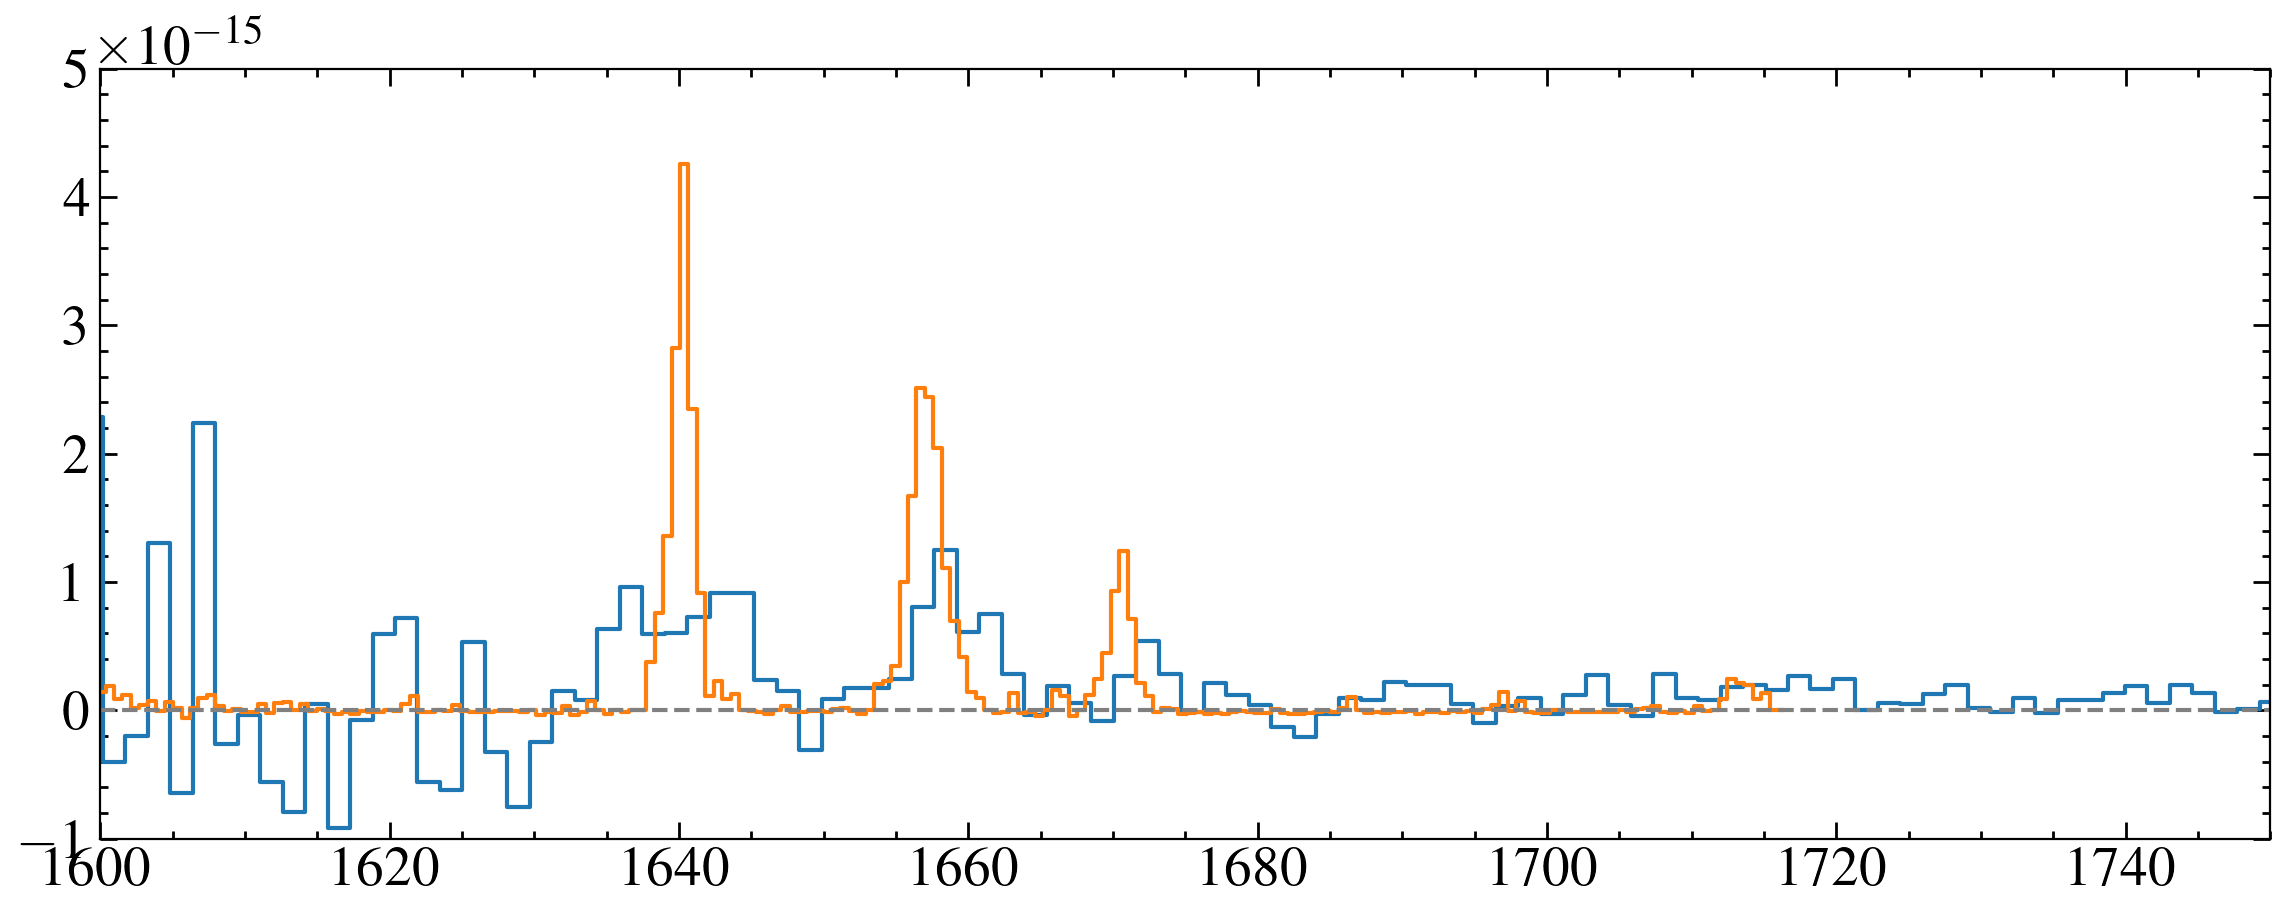

In [66]:
# plt.step(ow, of, where='mid')
plt.step(nw, nf, where='mid')
# plt.step(nw, ne, where='mid')
plt.step(fw, ff, where='mid')
# plt.step(fw, fe, where='mid')
plt.axhline(0, ls ='--', c='0.5')
# plt.step(pw, pf, where='mid')

# plt.yscale('log')
# plt.ylim(1e-17)

plt.xlim(1600, 1750)
plt.ylim(-1e-15, 0.5e-14)

lines =[1630, 1680]
nlinemask = (nw > lines[0]) & (nw < lines[1])
nint = np.trapz(nf[nlinemask], nw[nlinemask])

flinemask = (fw > lines[0]) & (fw < lines[1])
fint = np.trapz(ff[flinemask], fw[flinemask])

print(nint, fint, nint/fint)

scale = nint/fint

plt.show()


plt.step(nw, nf, where='mid')
# plt.step(nw, ne, where='mid')
plt.step(fw, ff*scale, where='mid')
# plt.step(fw, fe, where='mid')
plt.axhline(0, ls ='--', c='0.5')
# plt.step(pw, pf, where='mid')
plt.xlim(1600, 1750)
plt.ylim(-1e-15, 0.5e-14)

Do those lines show up in all stars?

In [69]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/'

stars = os.listdir(path)
stars

['GJ1132',
 'GJ15A',
 'GJ163',
 'GJ649',
 'GJ674',
 'GJ676A',
 'GJ699',
 'GJ729',
 'GJ849',
 'L-980-5',
 'LHS-2686',
 'TRAPPIST-1']

GJ1132
GJ15A
2.2128395915485724e-12 1.1162535444149805e-13 19.823807974632714


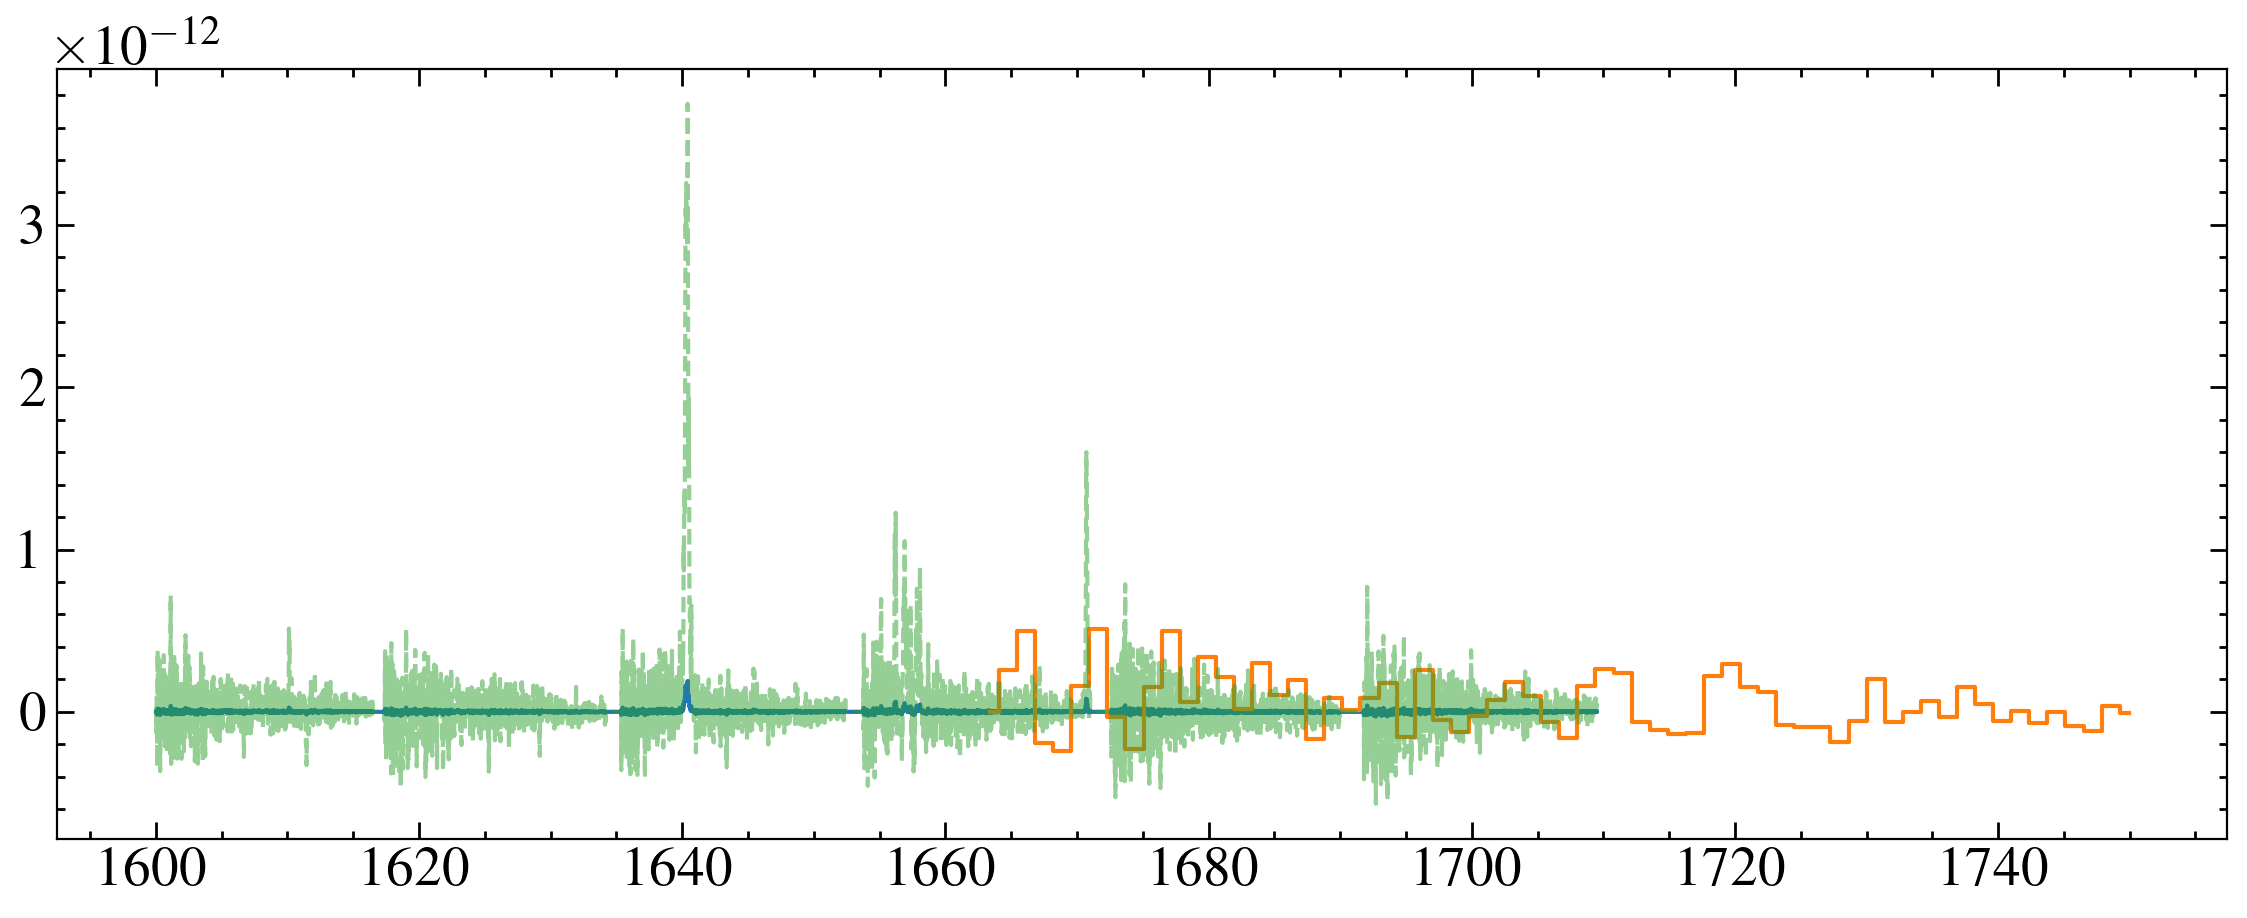

GJ163
GJ649
5.866775723837604e-15 1.3527316809266612e-14 0.43369840497996537


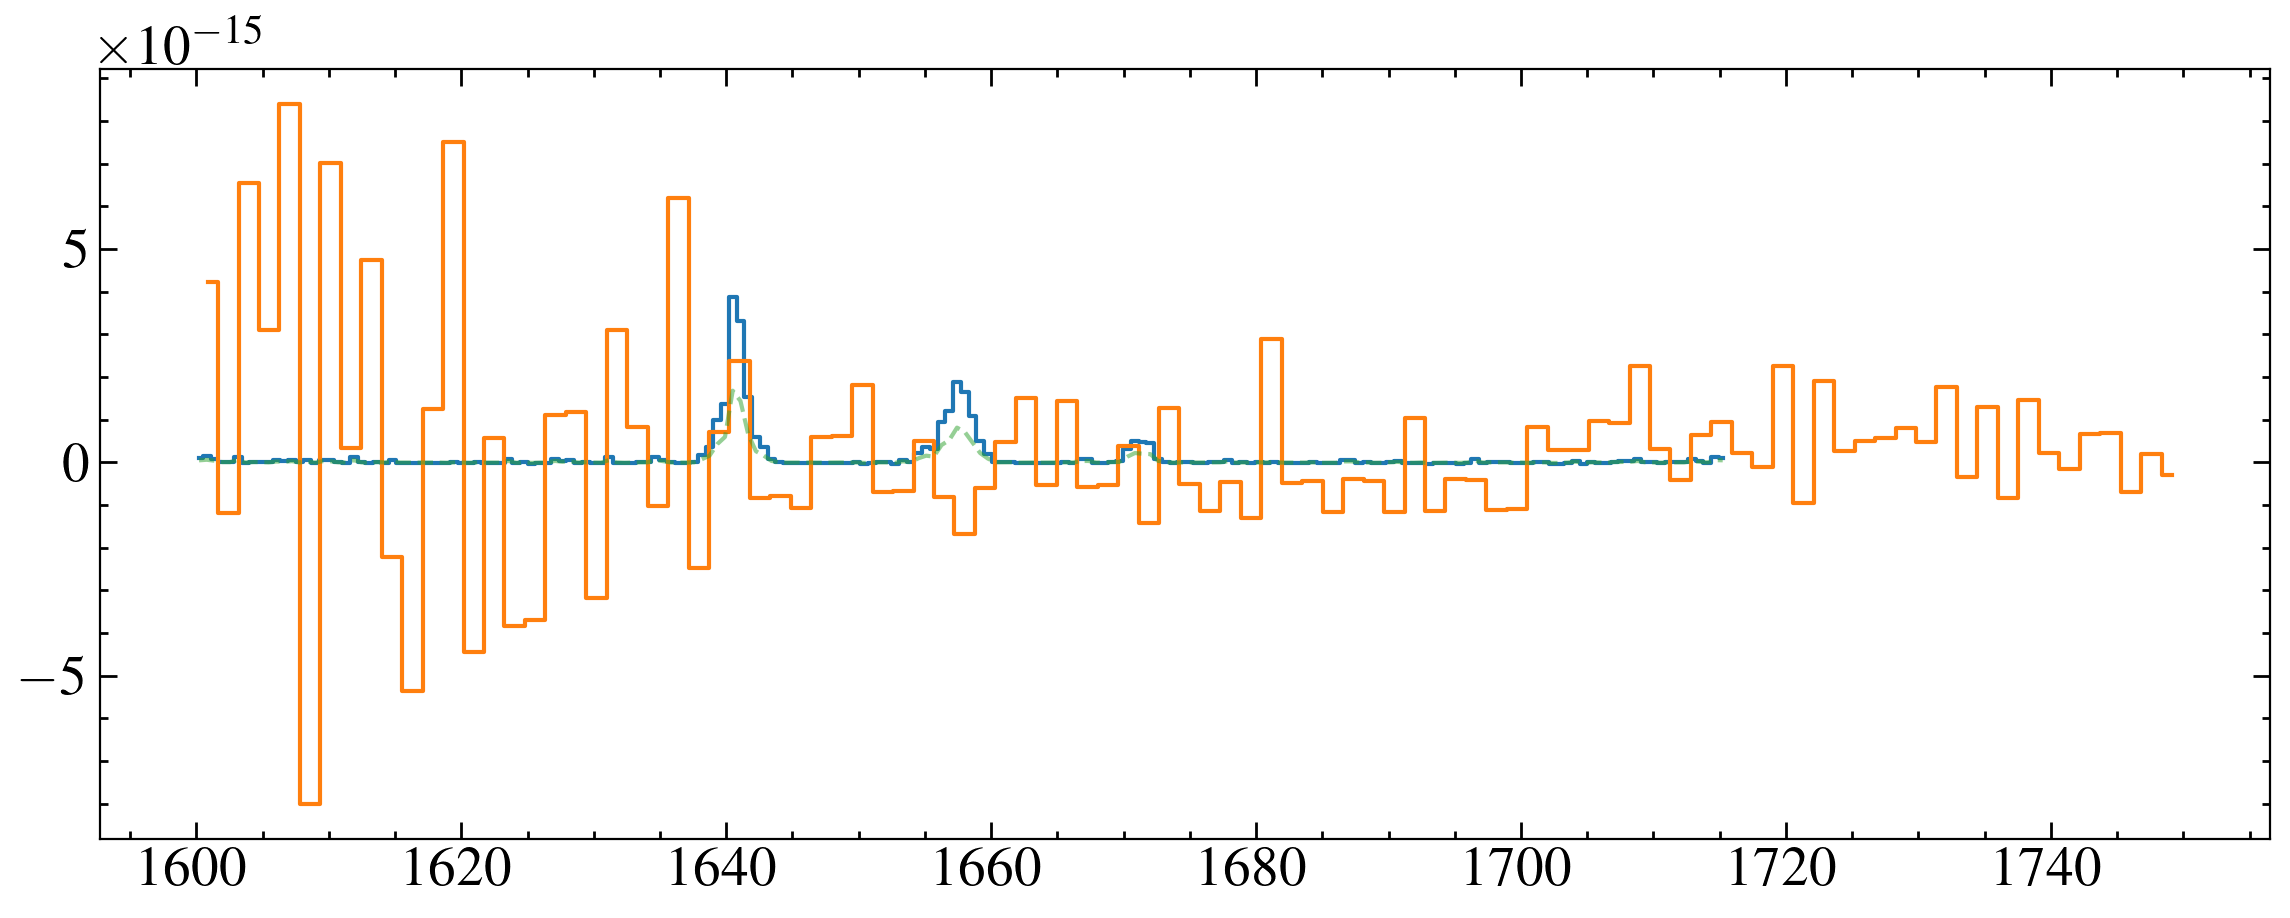

GJ674
5.883068492536266e-14 4.964634605681726e-14 1.1849952634587544


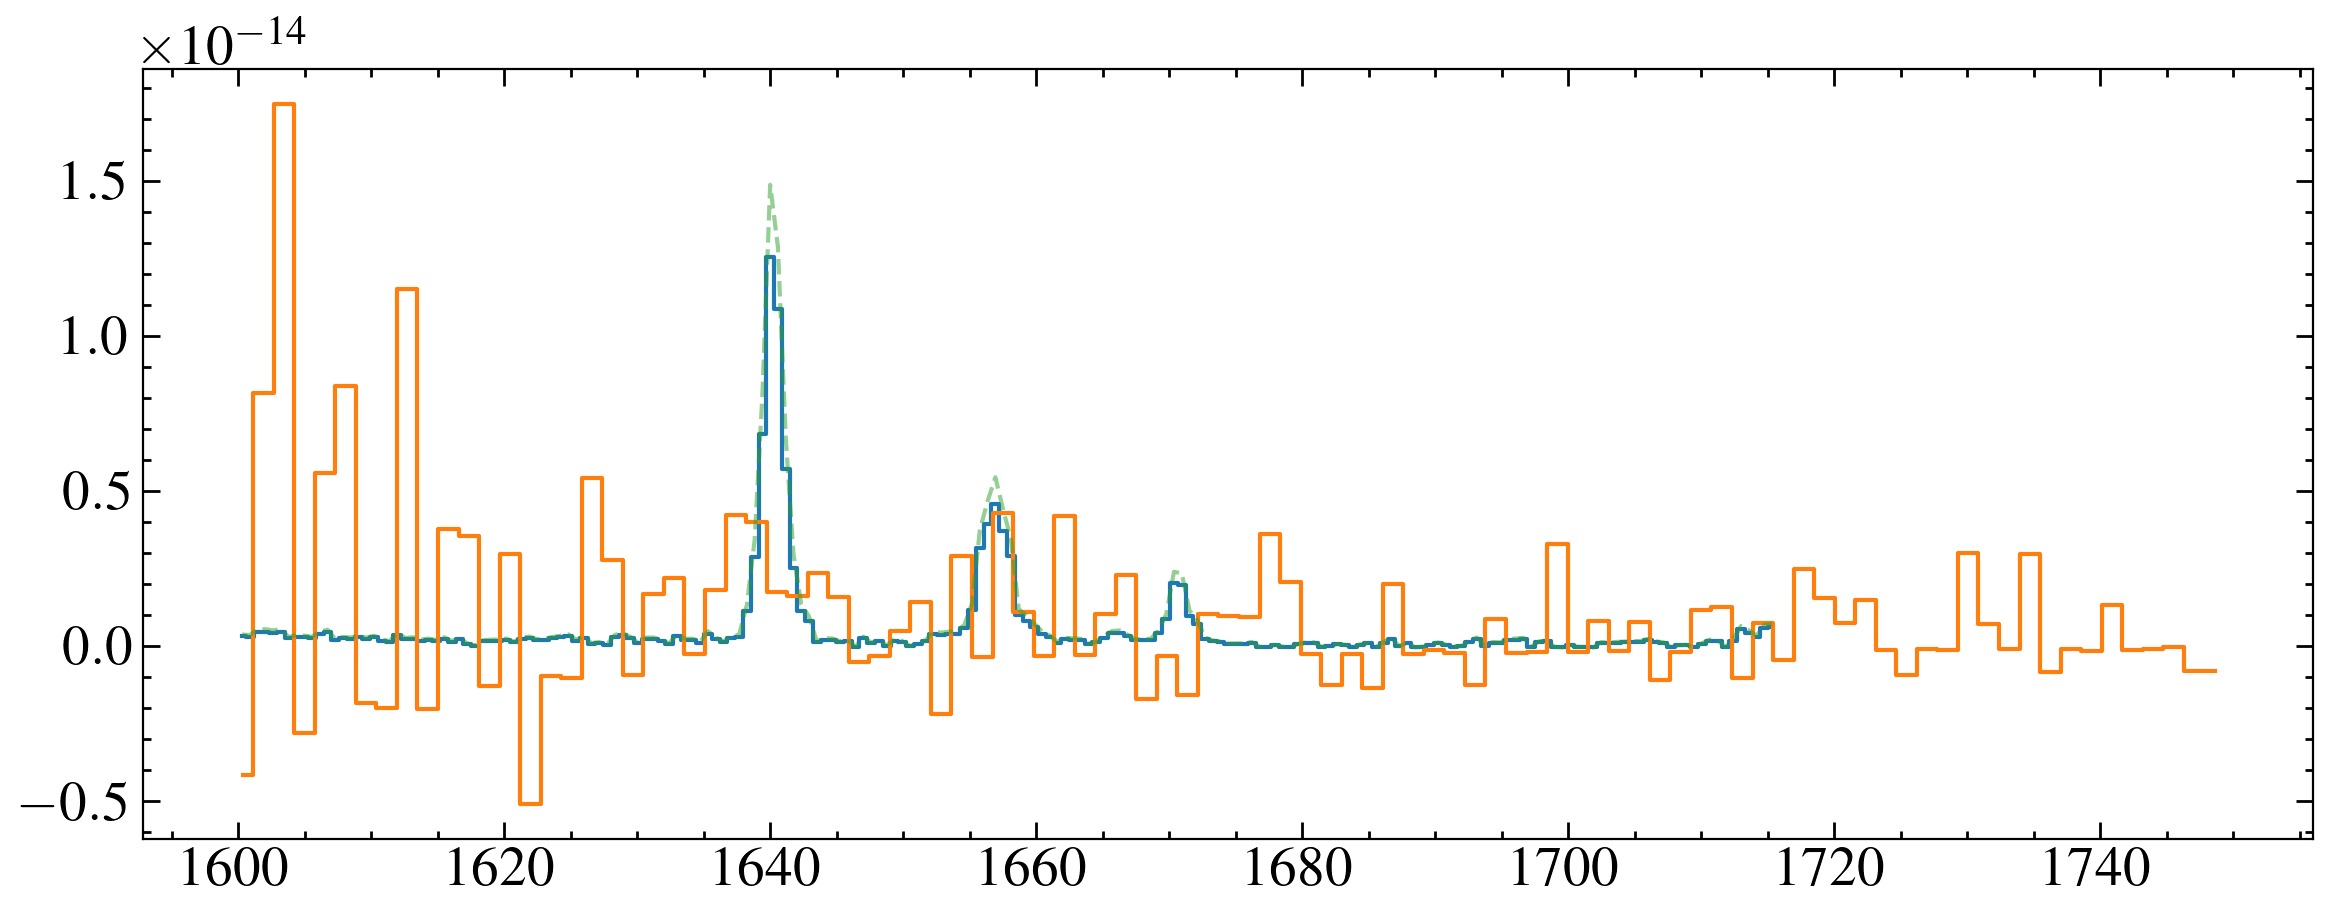

GJ676A
1.7731797184742814e-14 1.4586132811091182e-14 1.2156613006608368


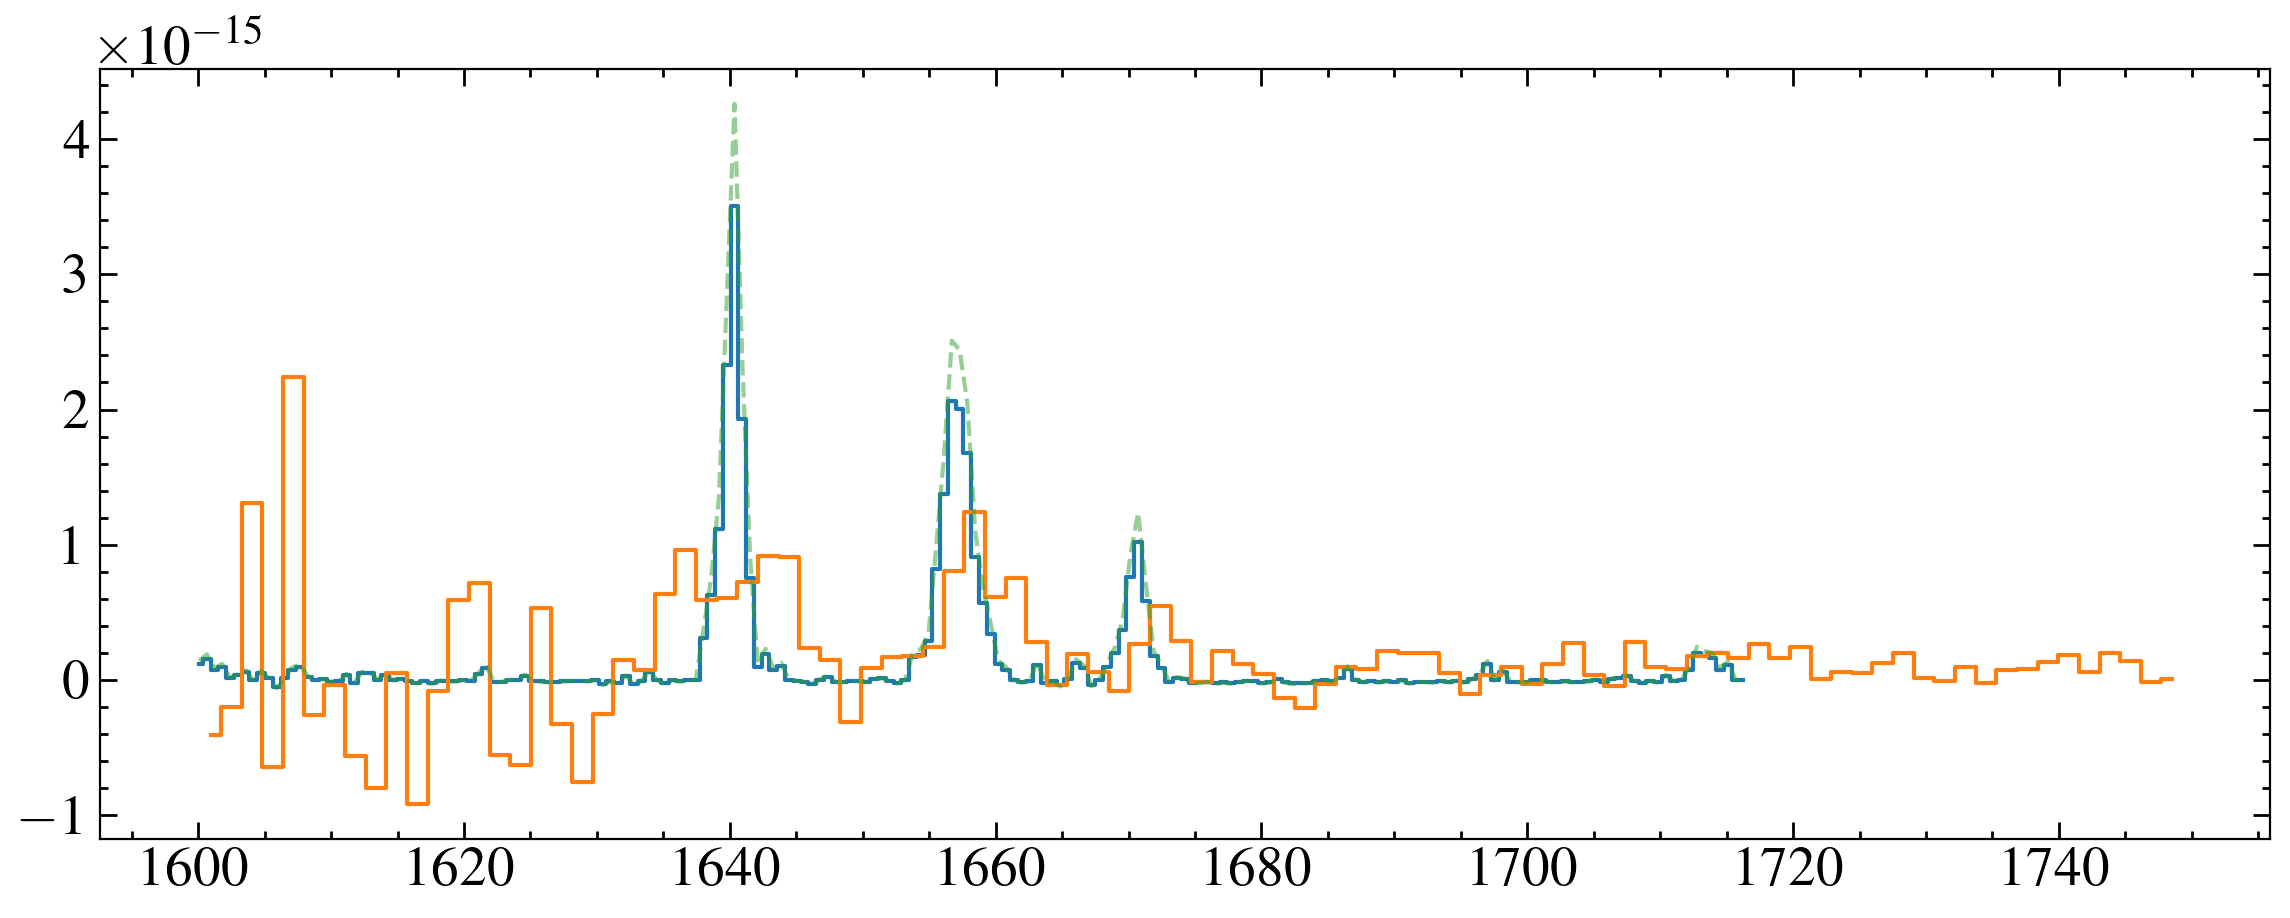

GJ699
1.7354823618427178e-14 1.0098963623573445e-14 1.718475703577819


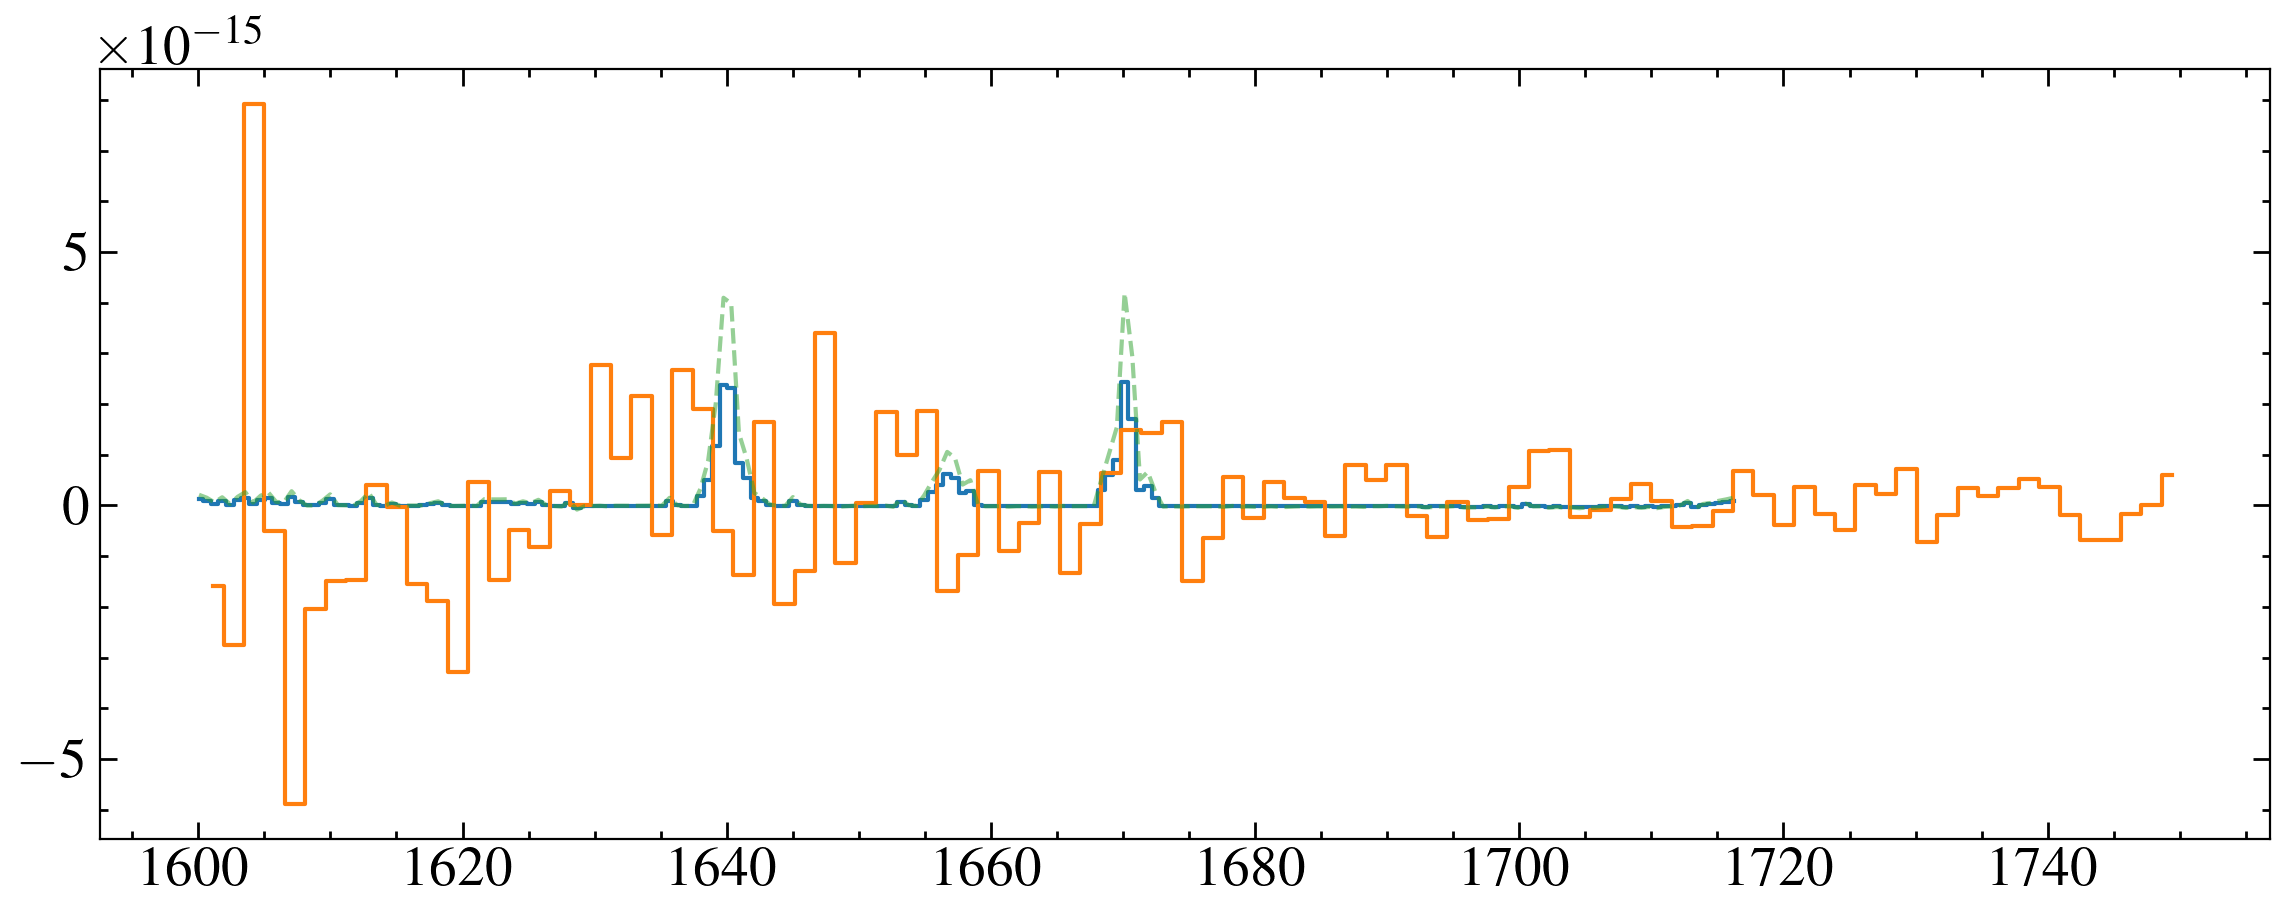

GJ729
1.9501861751936002e-13 2.803315640058634e-14 6.956712784411285


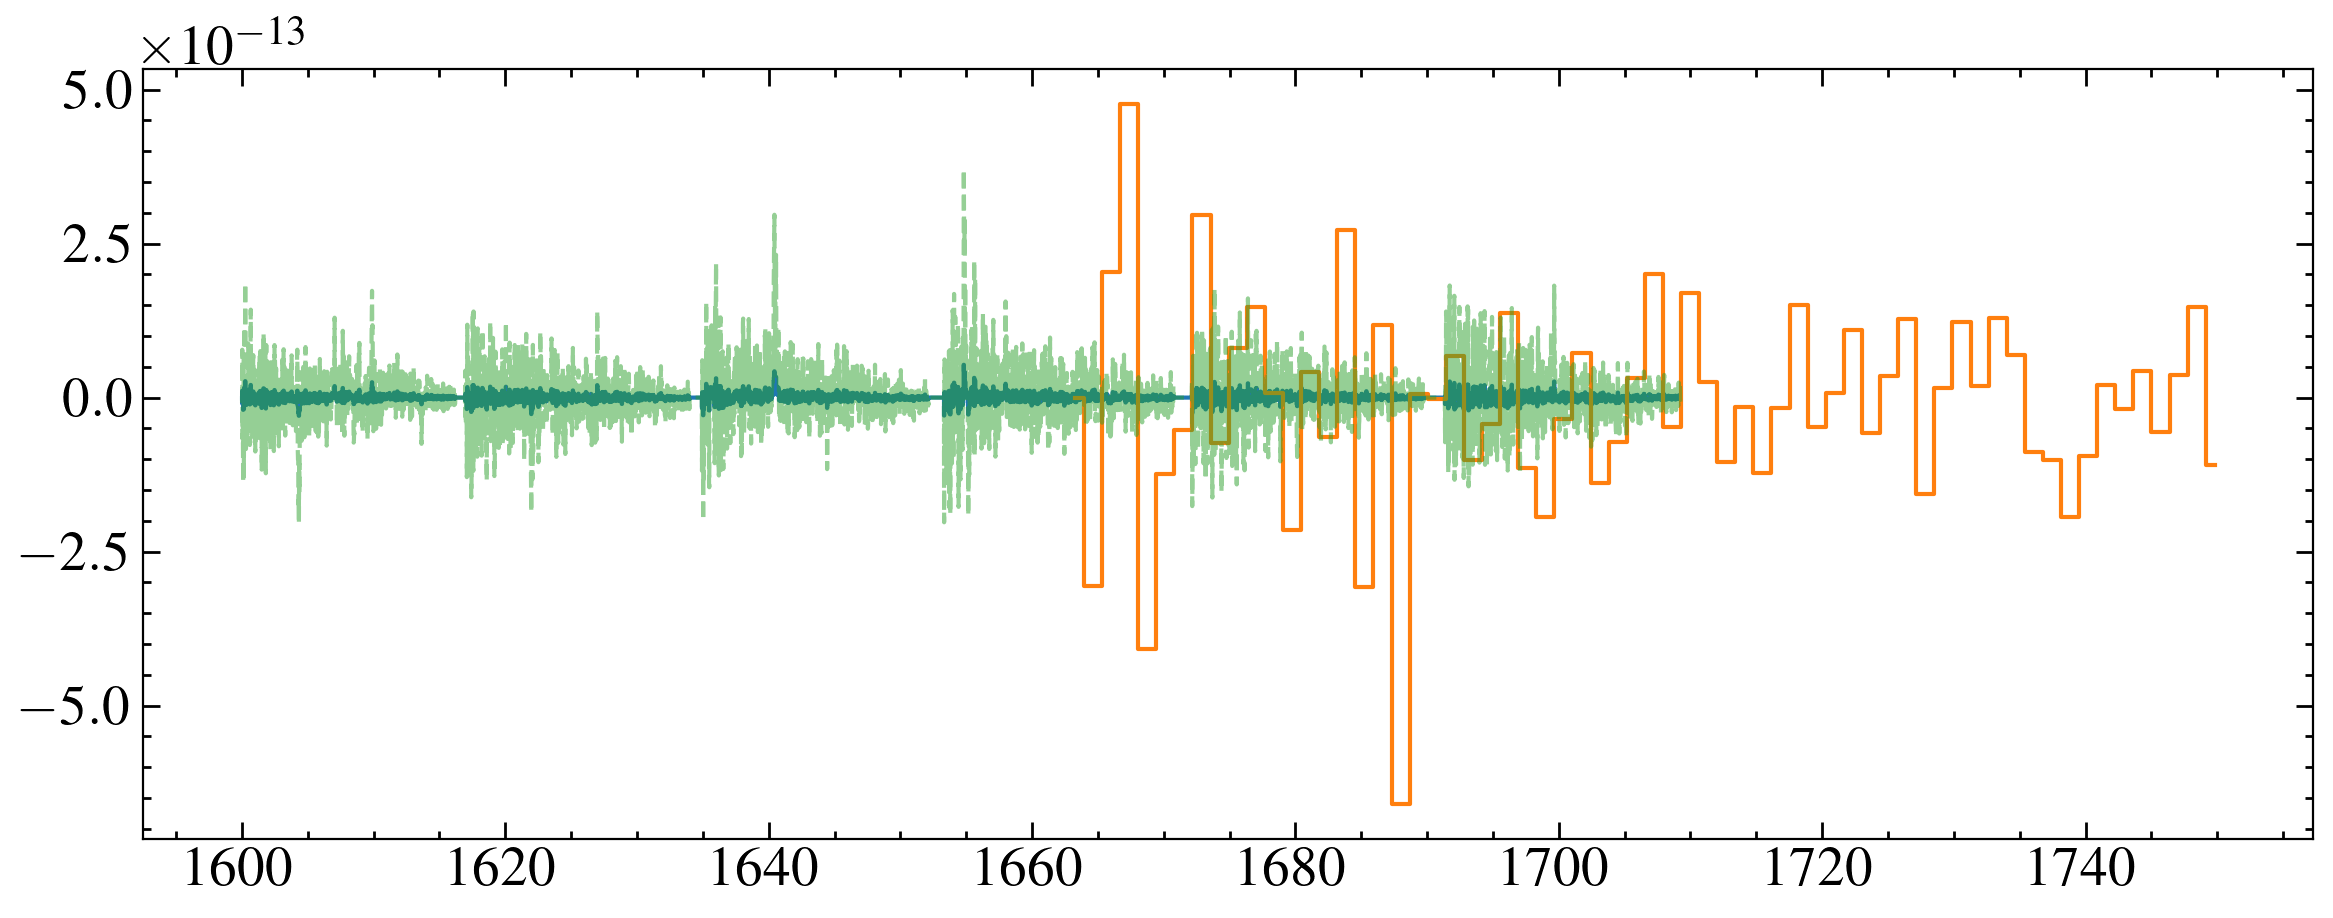

GJ849
L-980-5
LHS-2686
7.651312483700653e-15 3.947666020329099e-15 1.938186372479098


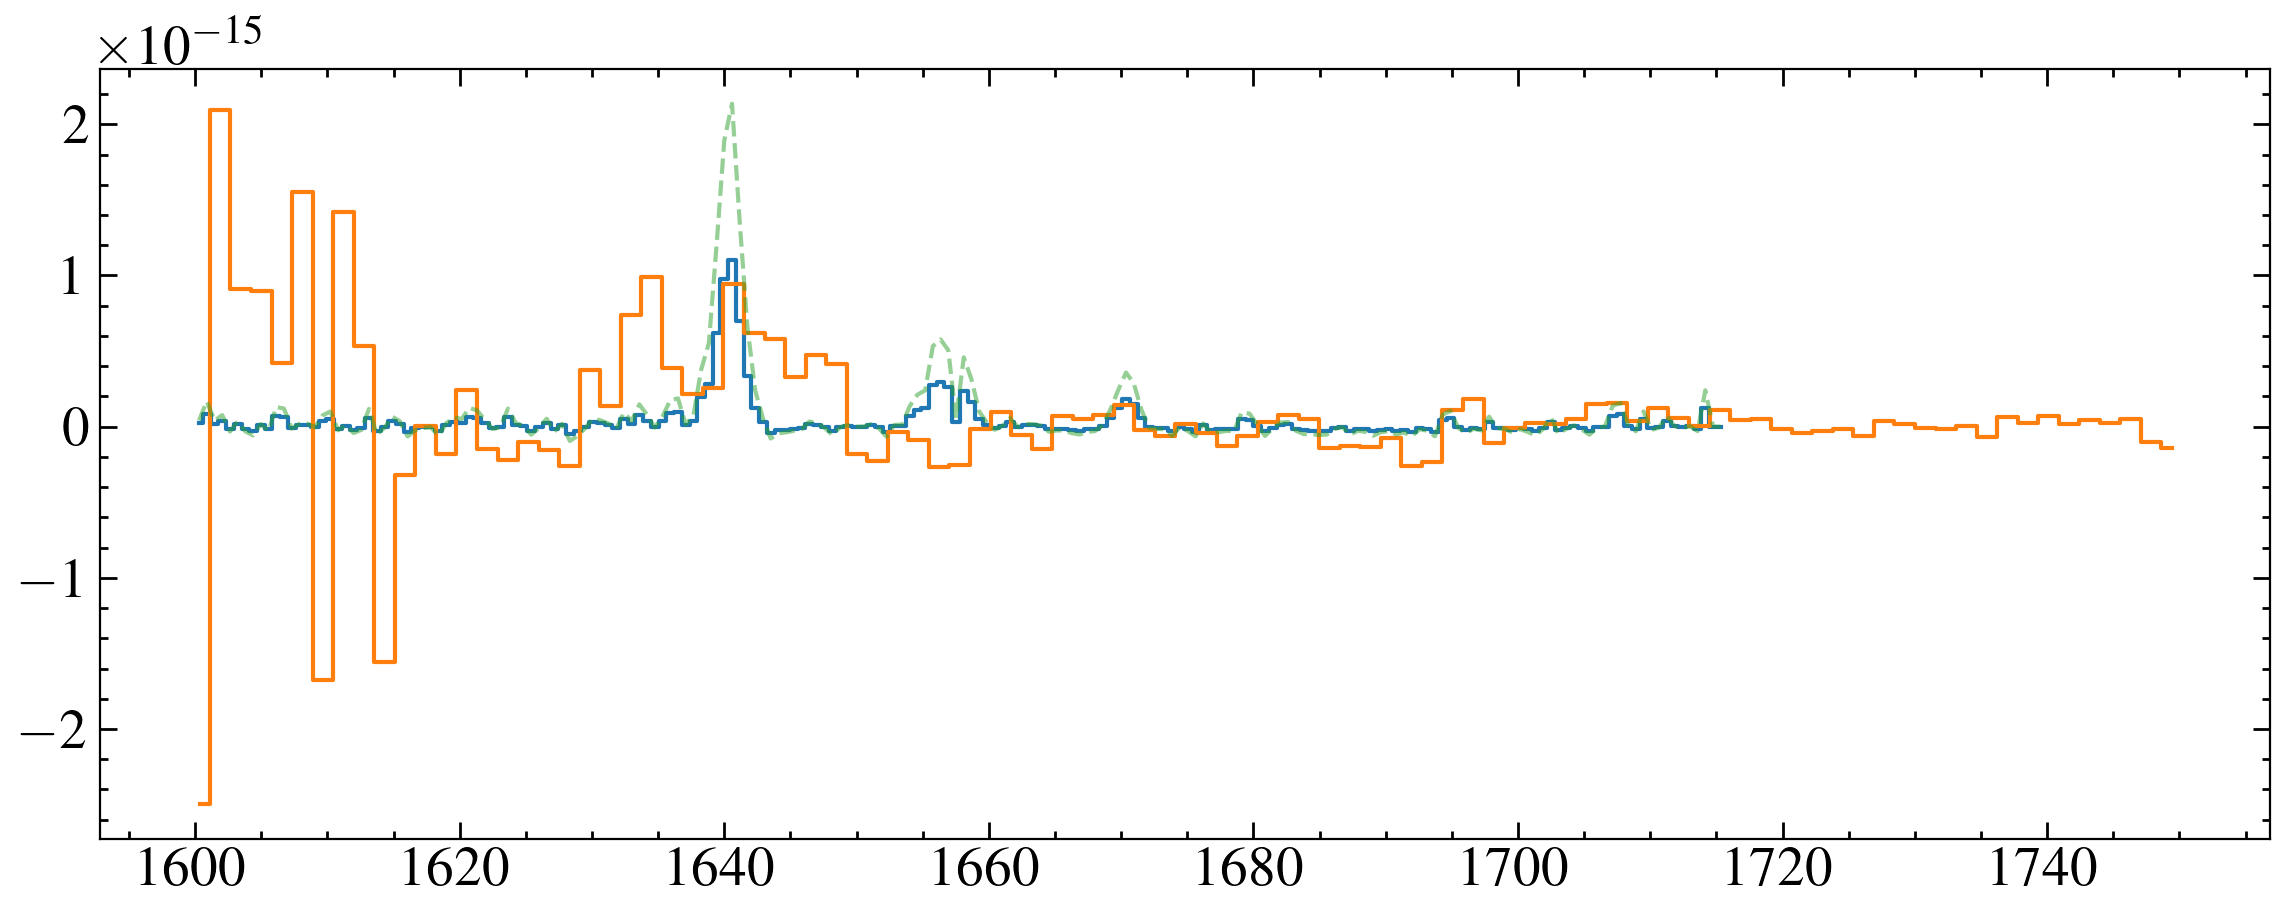

In [81]:
for star in stars[:-1]:
    print(star)
    fuv = glob.glob('{}{}/*g140l*'.format(path, star))
    if len(fuv) == 0:
        fuv = glob.glob('{}{}/*e140m*'.format(path, star))
    if len(fuv) == 0:
        continue
    nuv = glob.glob('{}{}/*g230l*'.format(path, star))
    
    fdata = fits.getdata(fuv[0], 1)
    fw, ff, fe = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']
    
    ndata = fits.getdata(nuv[0], 1)
    nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
    
    lap = [1600, 1750]
    fmask = (fw > lap[0]) & (fw < lap[1])
    fw, ff, fe = fw[fmask], ff[fmask], fe[fmask]
    
    nmask = (nw > lap[0]) & (nw < lap[1])
    nw, nf, ne = nw[nmask], nf[nmask], ne[nmask]
    
    plt.step(fw, ff, where='mid')
    plt.step(nw, nf, where='mid')
    
    
    lines =[1630, 1680]
    nlinemask = (nw > lines[0]) & (nw < lines[1])
    nint = np.trapz(nf[nlinemask], nw[nlinemask])

    flinemask = (fw > lines[0]) & (fw < lines[1])
    fint = np.trapz(ff[flinemask], fw[flinemask])

    print(nint, fint, nint/fint)
    
    scale = nint/fint
    
    plt.plot(fw, ff*scale, ls='--', alpha=0.5)

    
    plt.show()


Add some filter for meaningful information?

In [102]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff = np.insert(diff, 0, diff[0]) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff/2.
    w1 = w + diff/2.
    return w0, w1


GJ1132


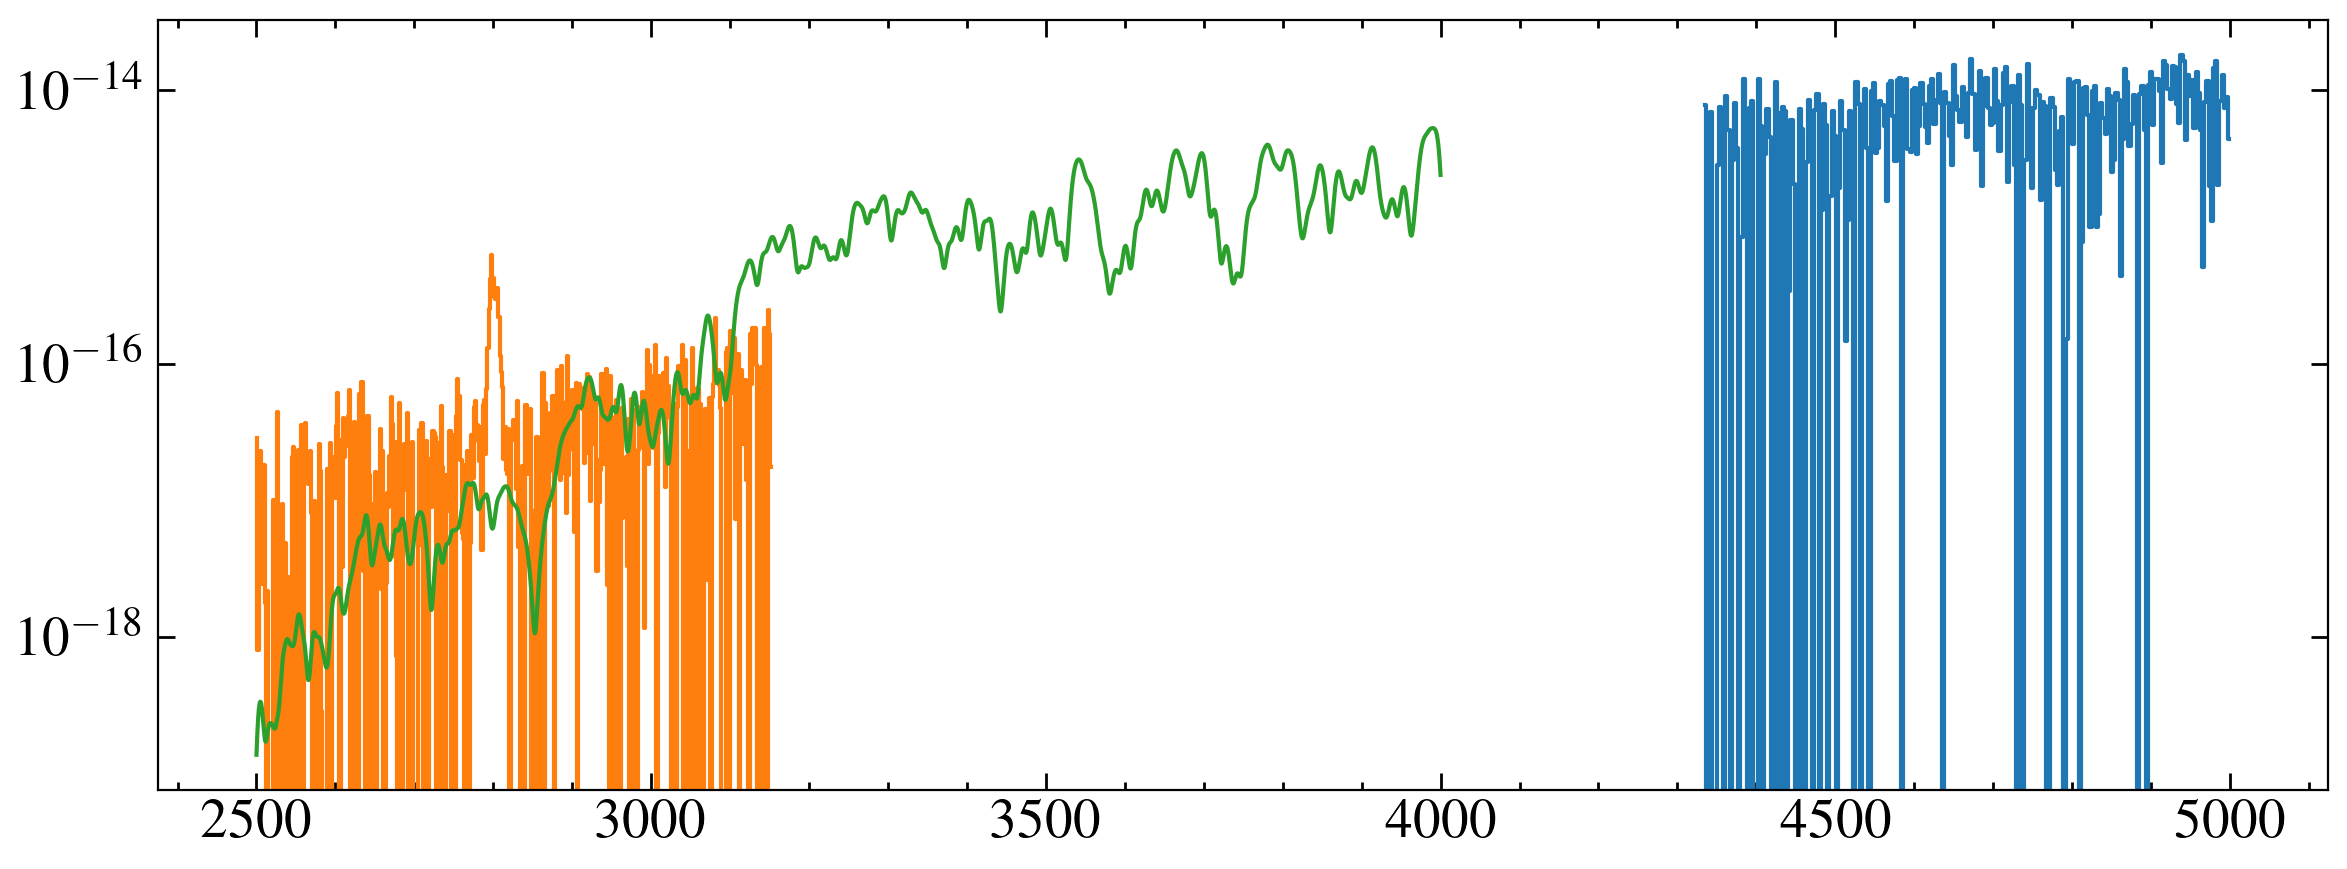

GJ15A


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


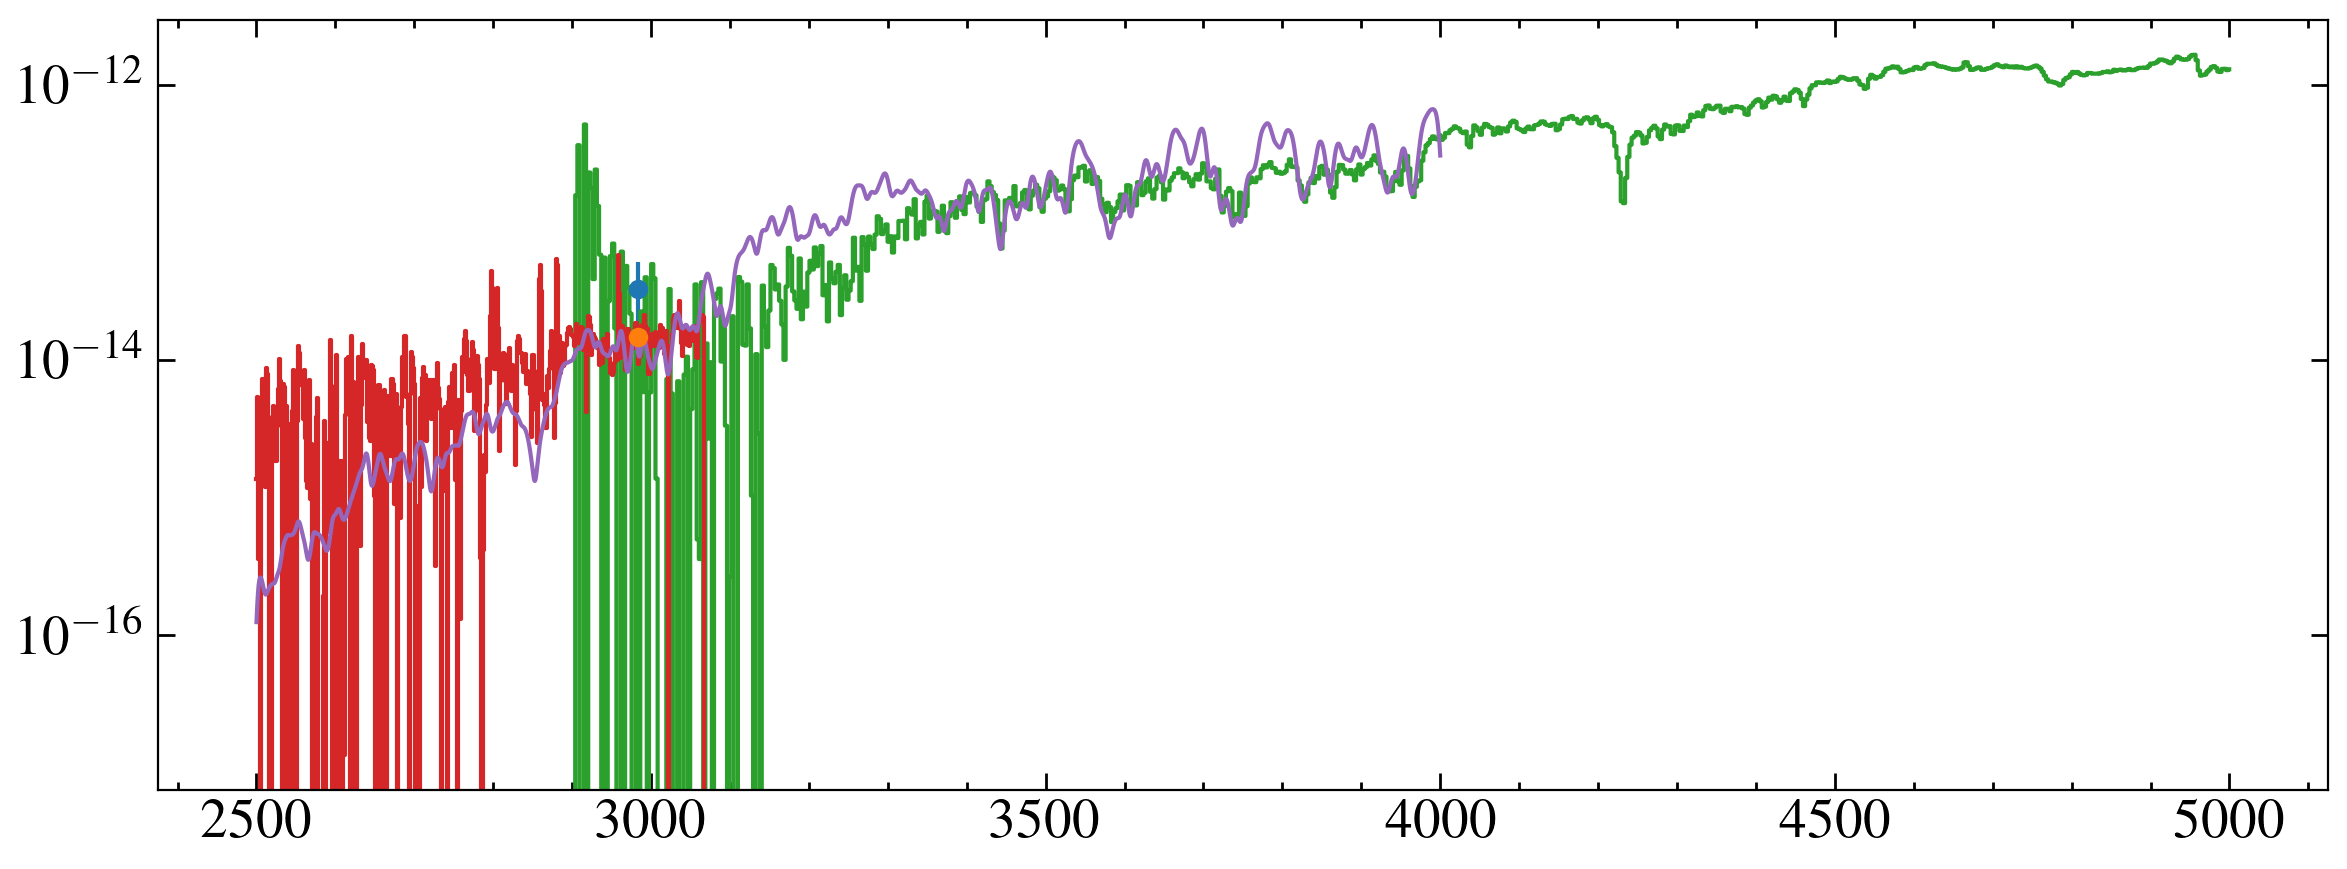

GJ163


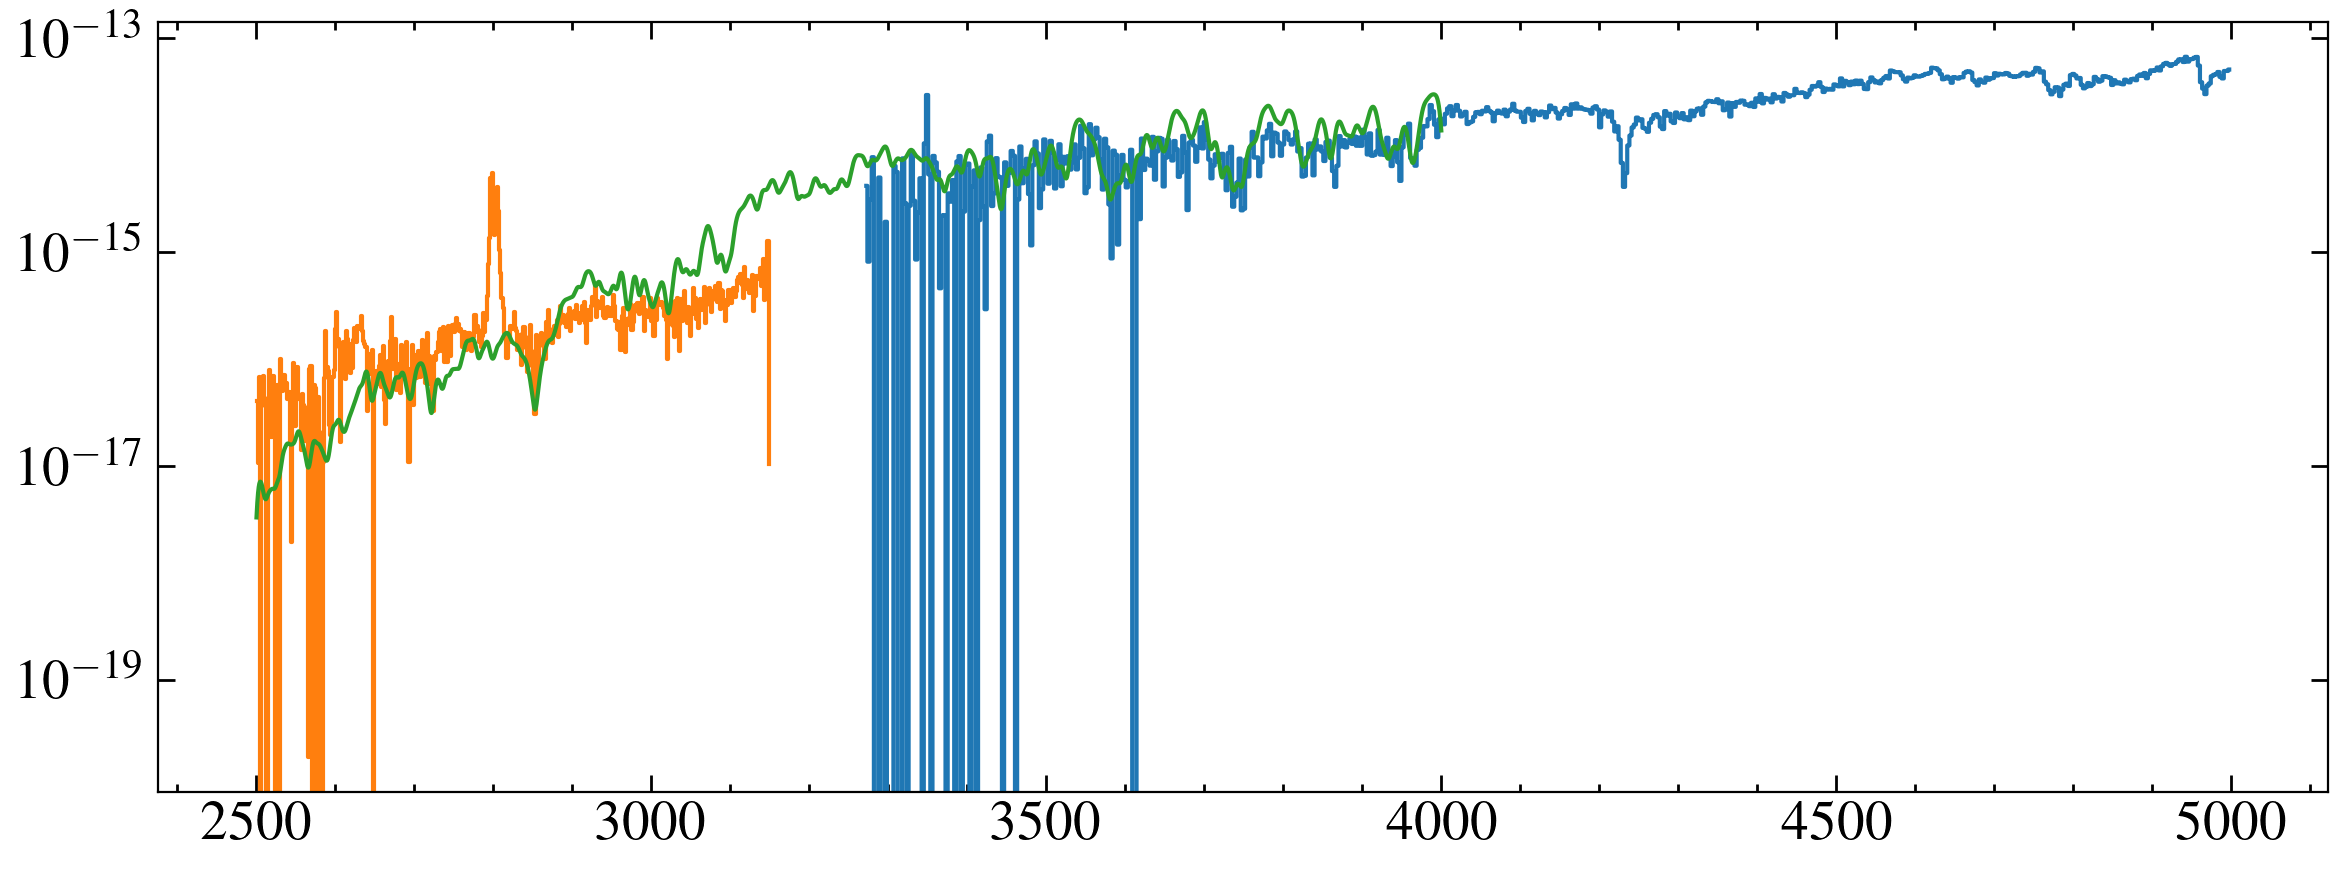

GJ649


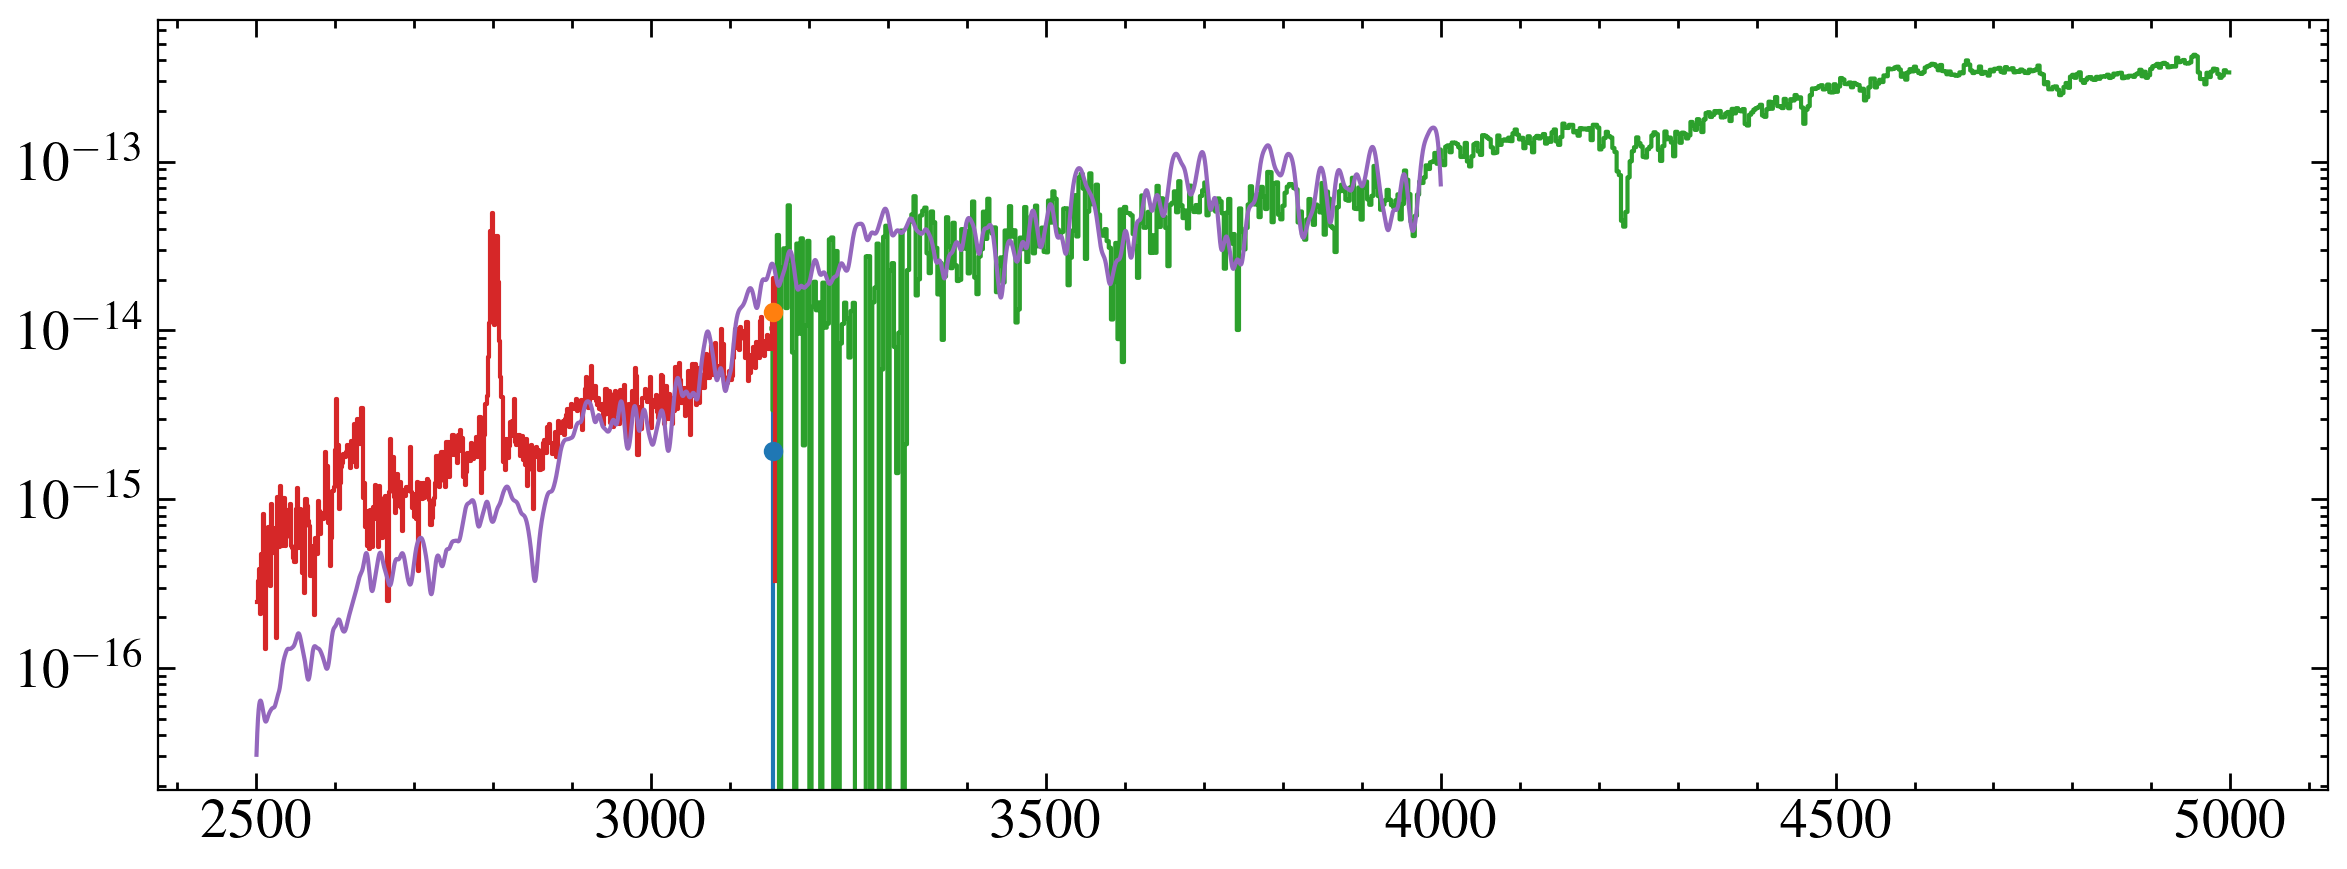

GJ674


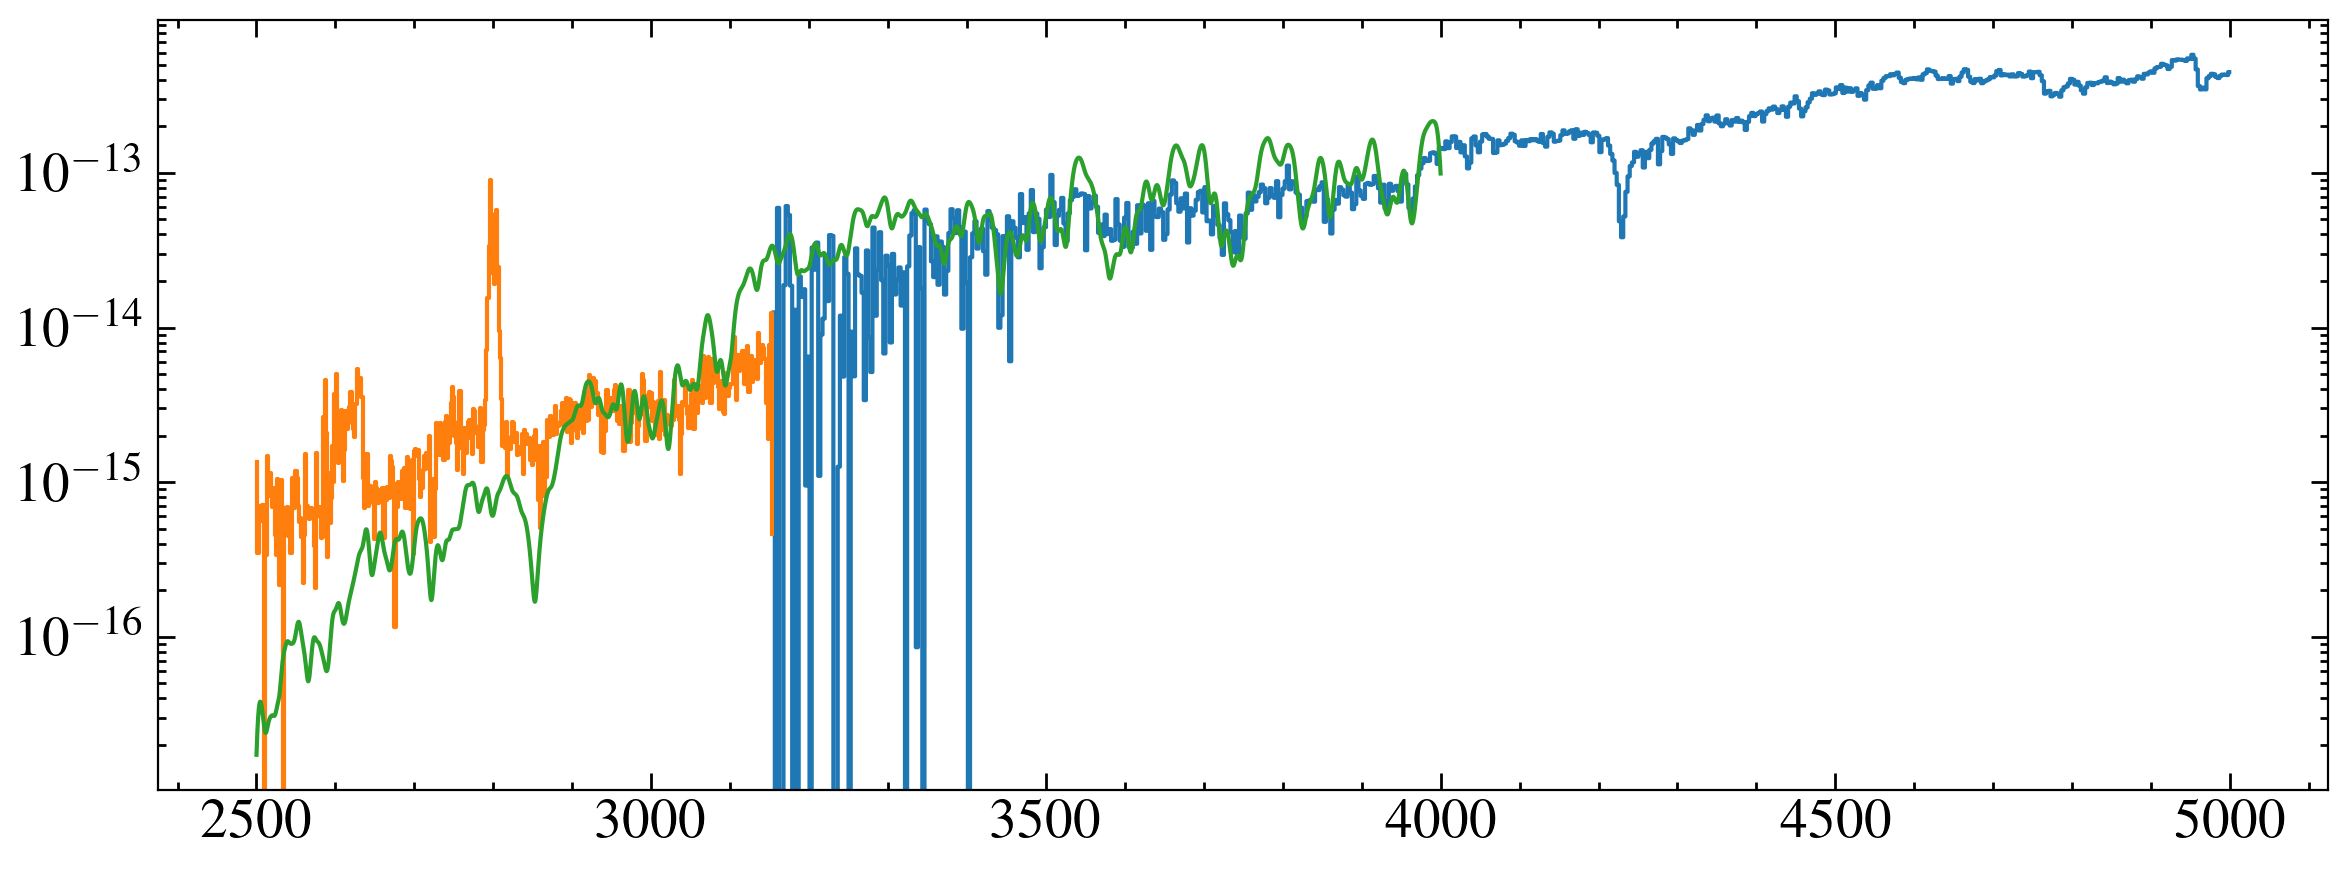

GJ676A


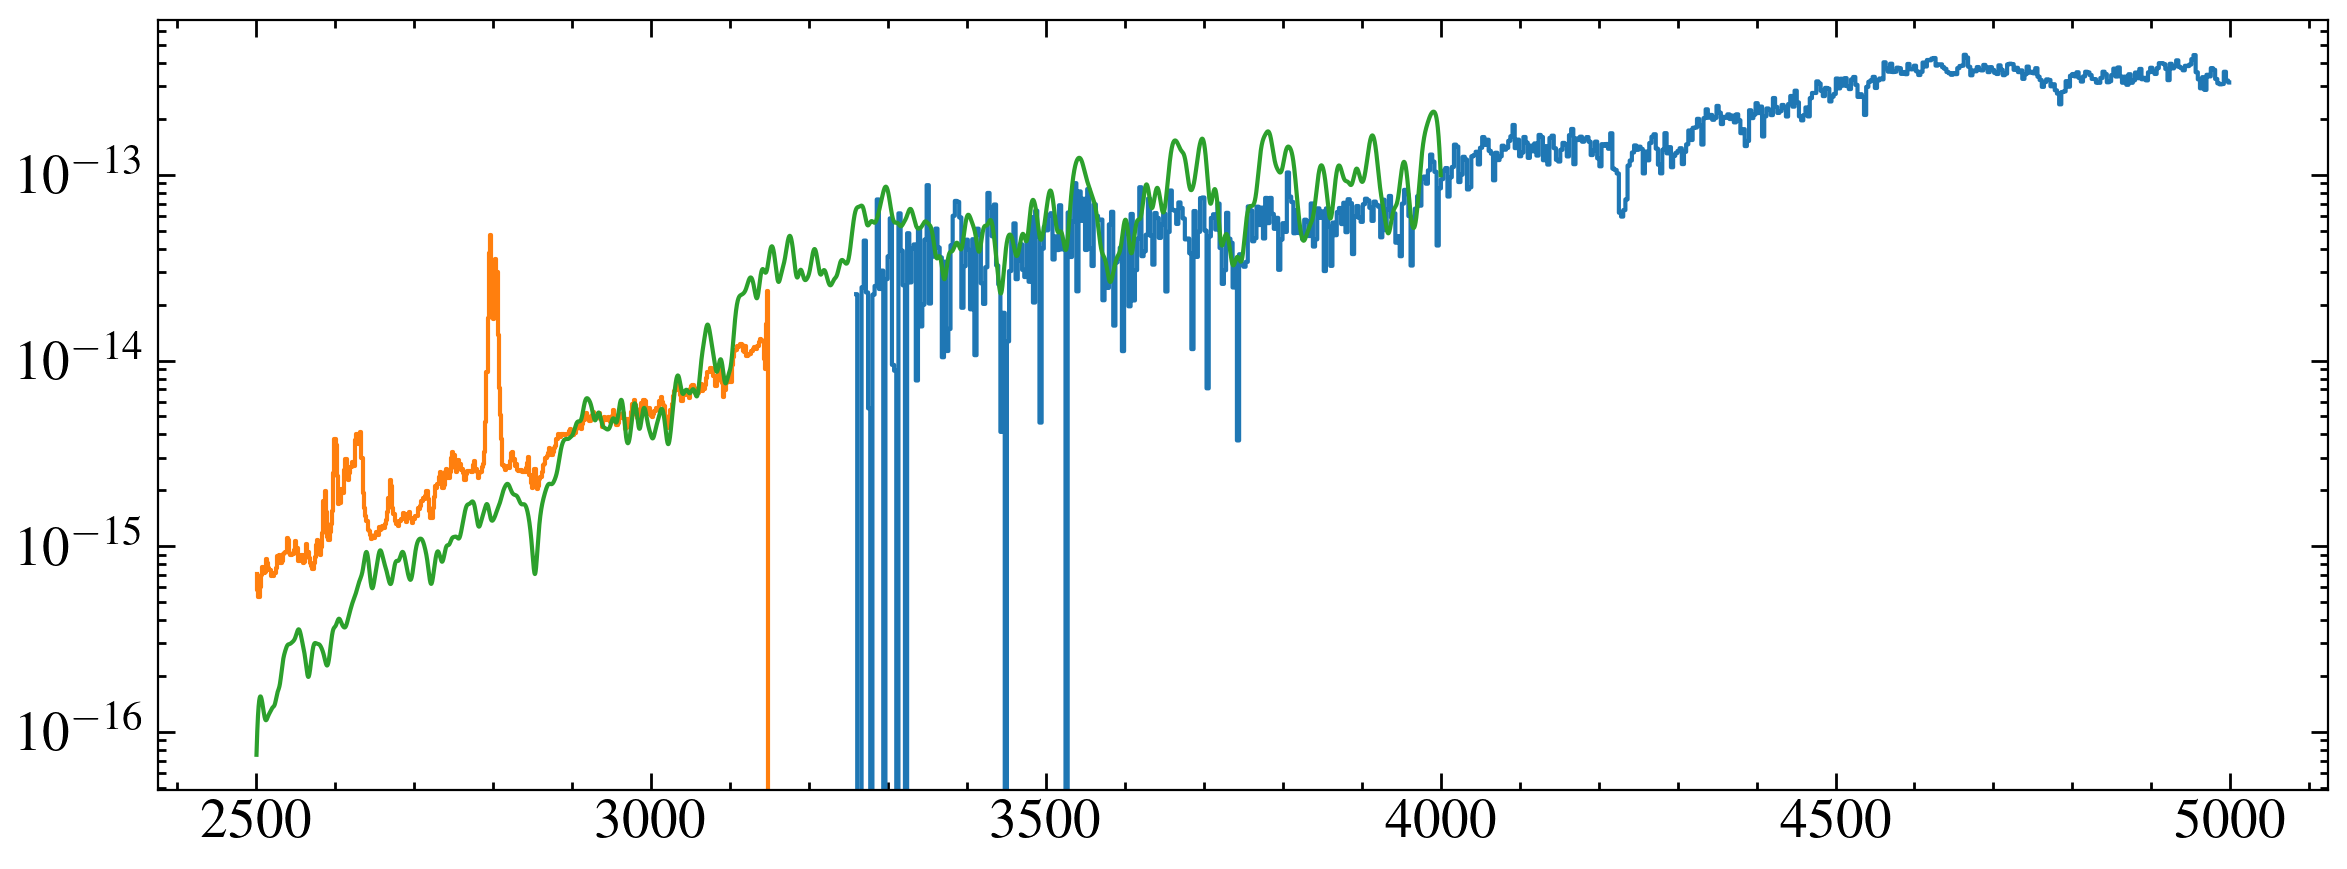

GJ699


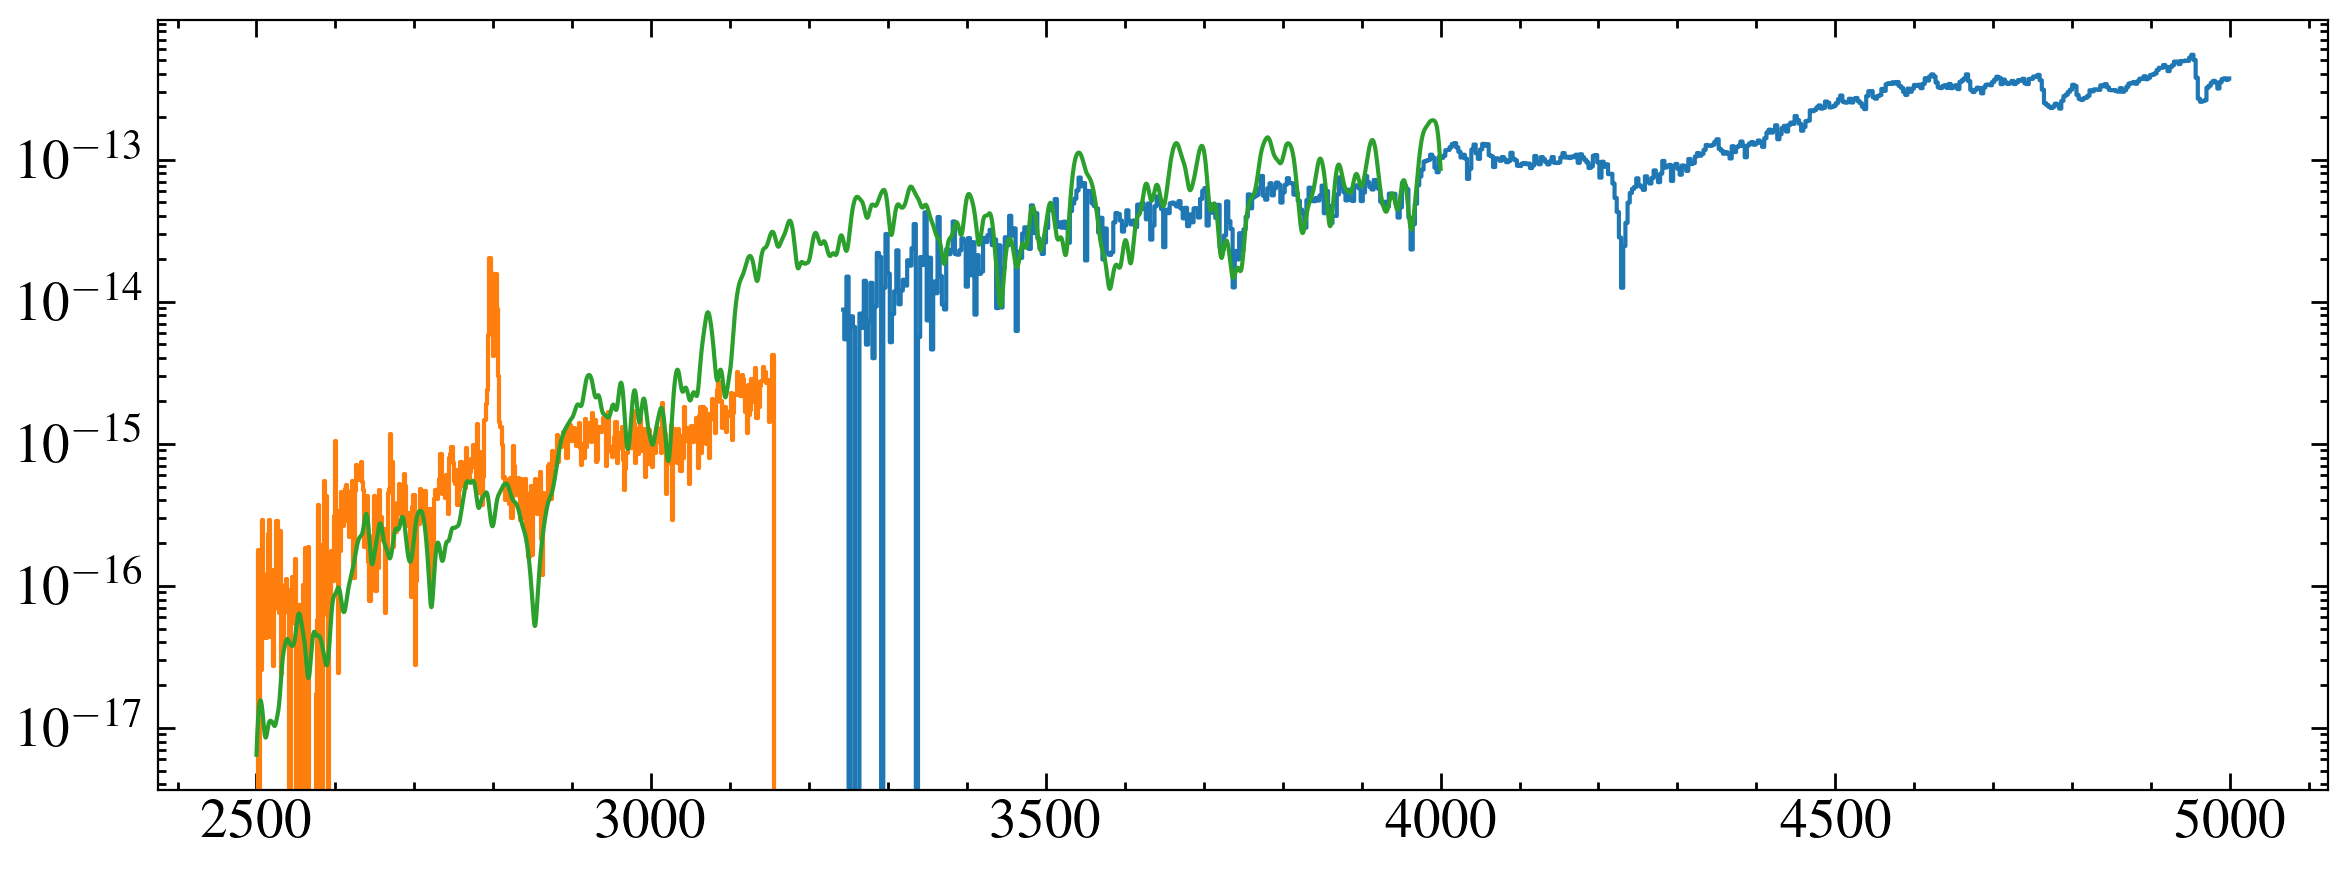

GJ729


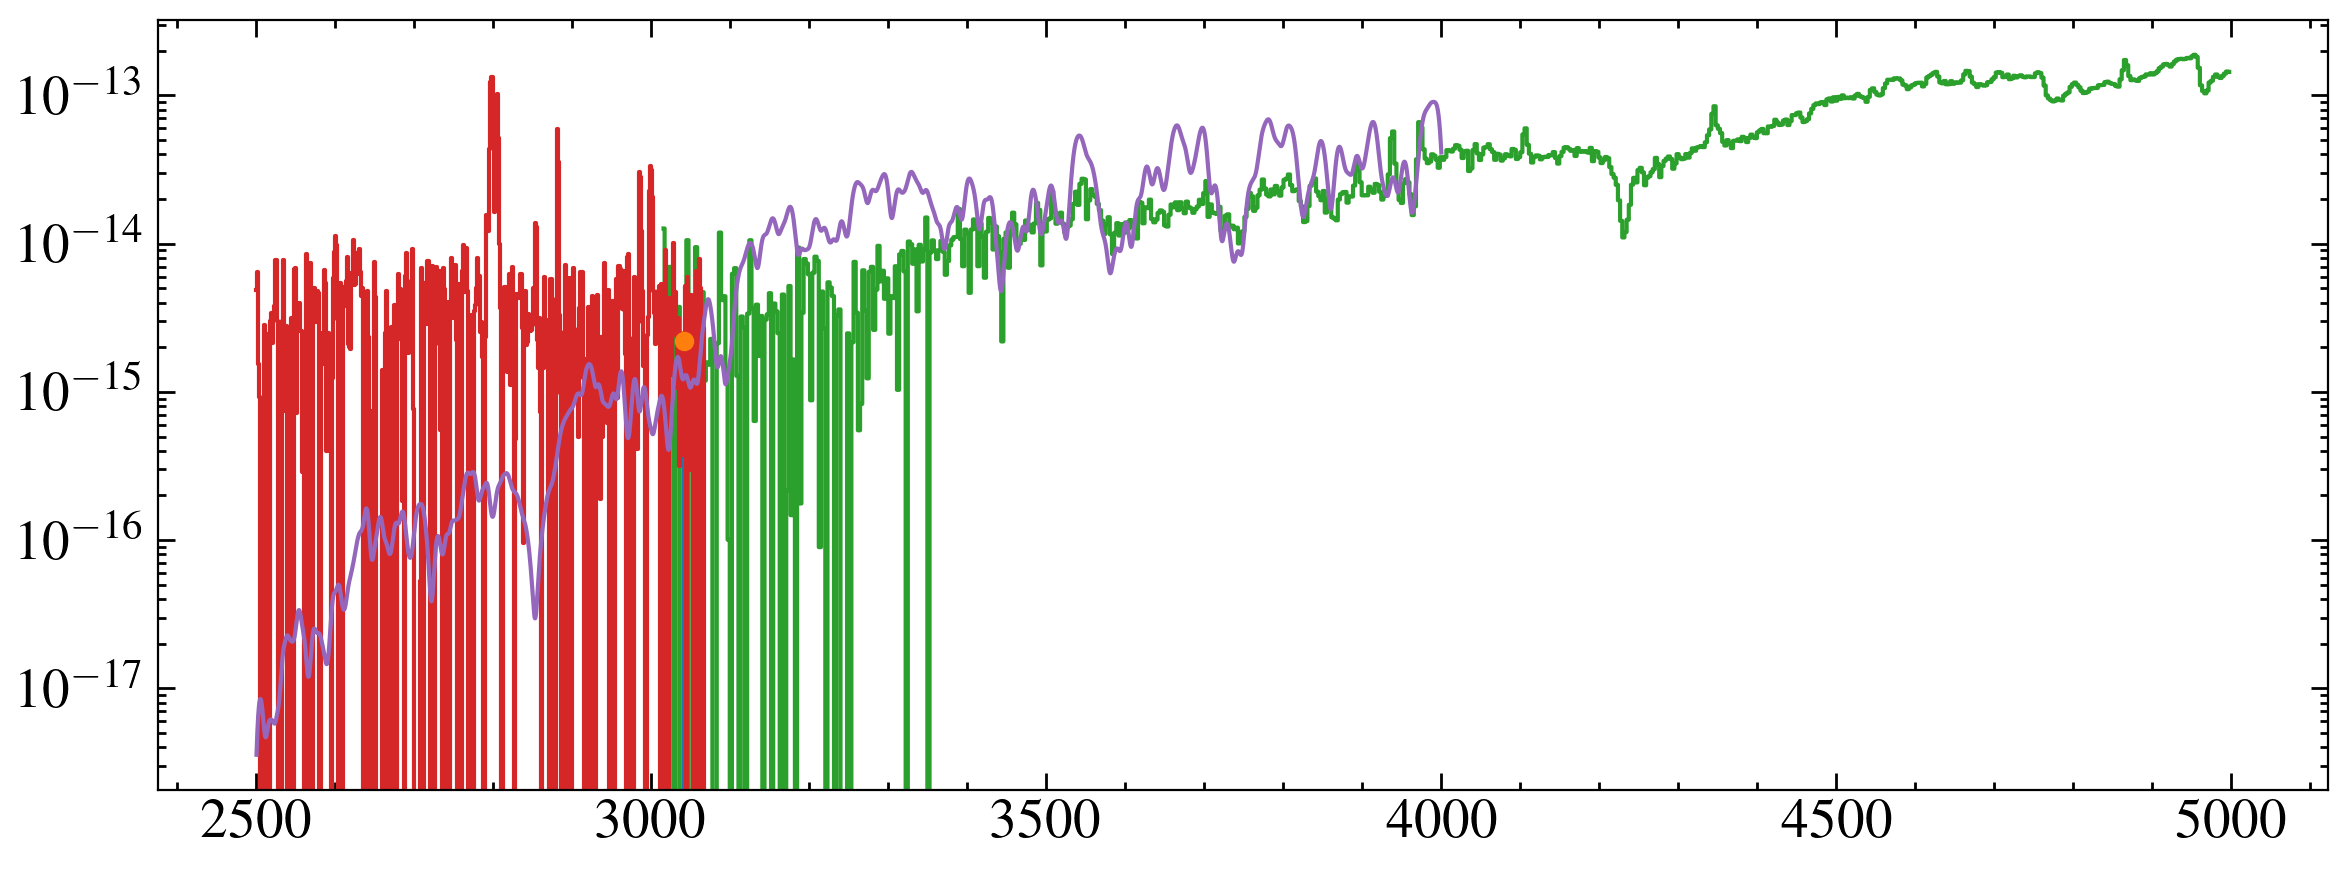

GJ849


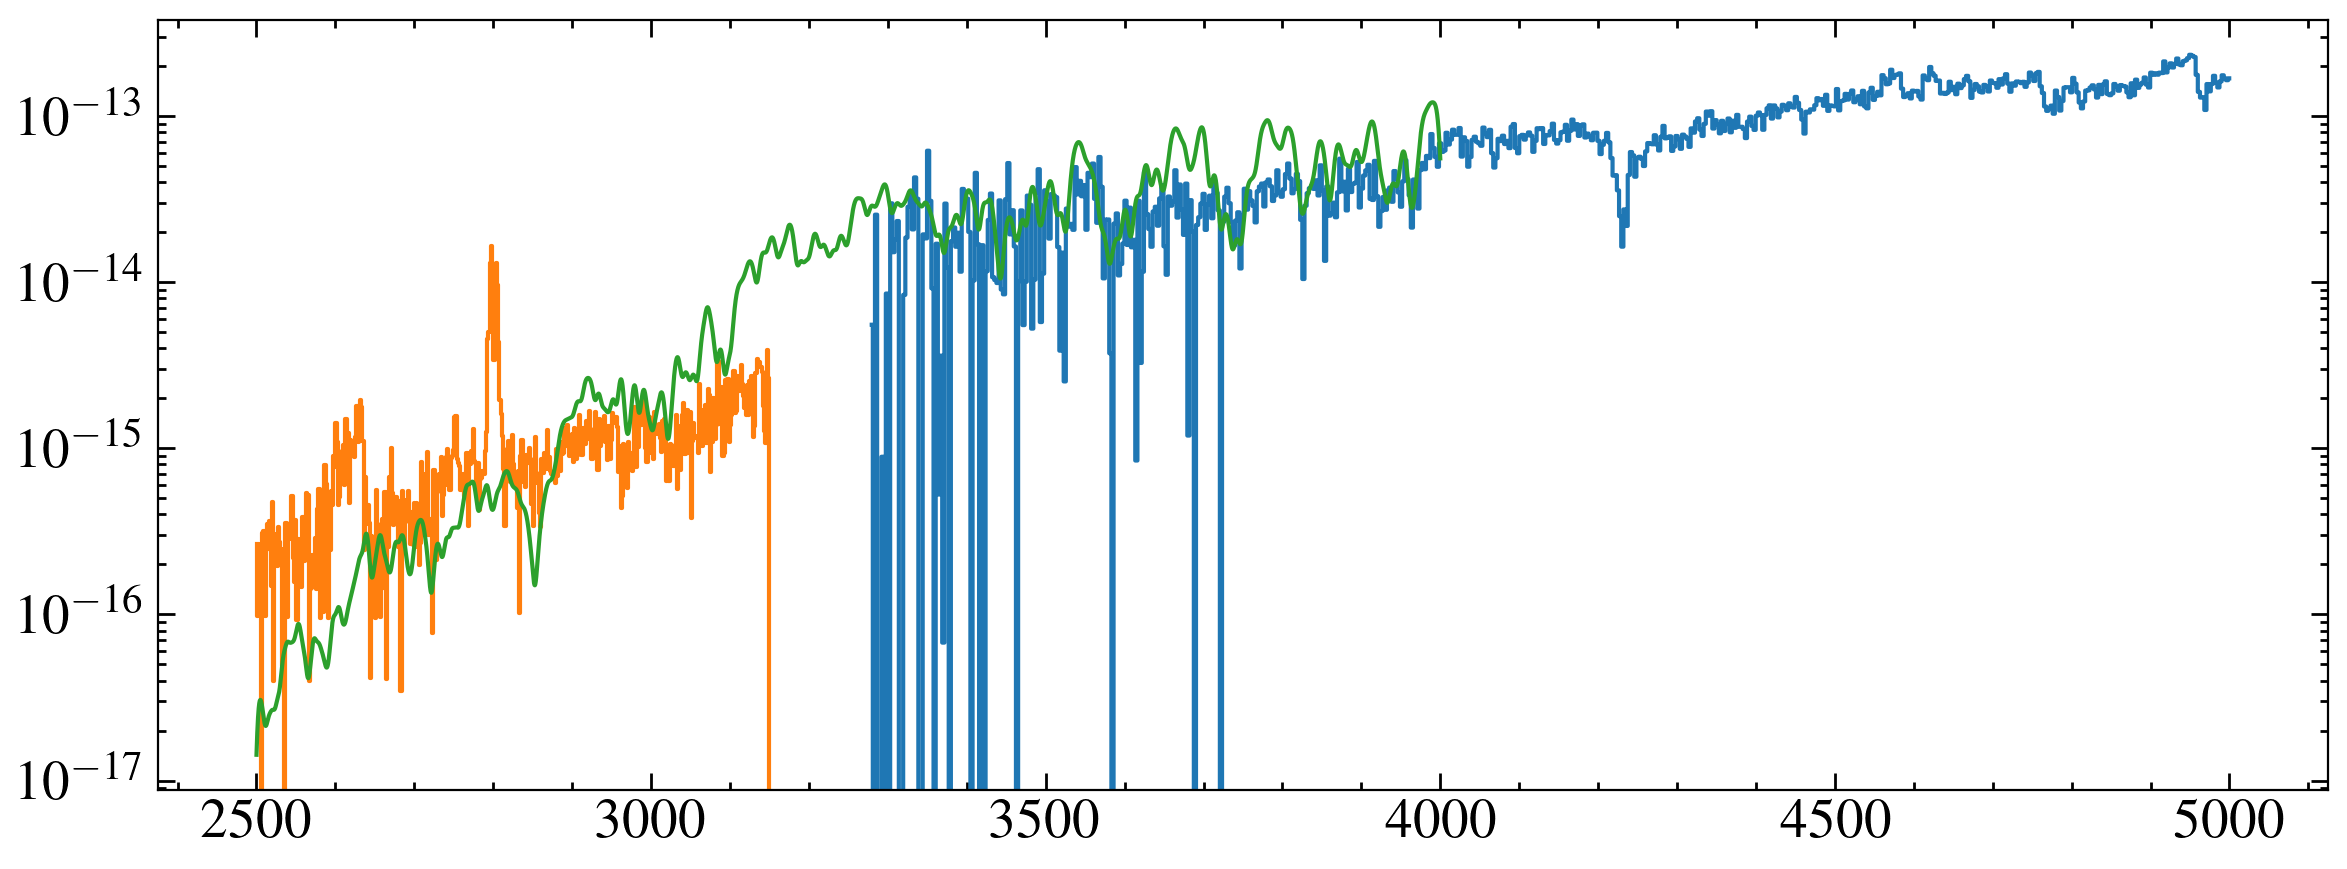

L-980-5


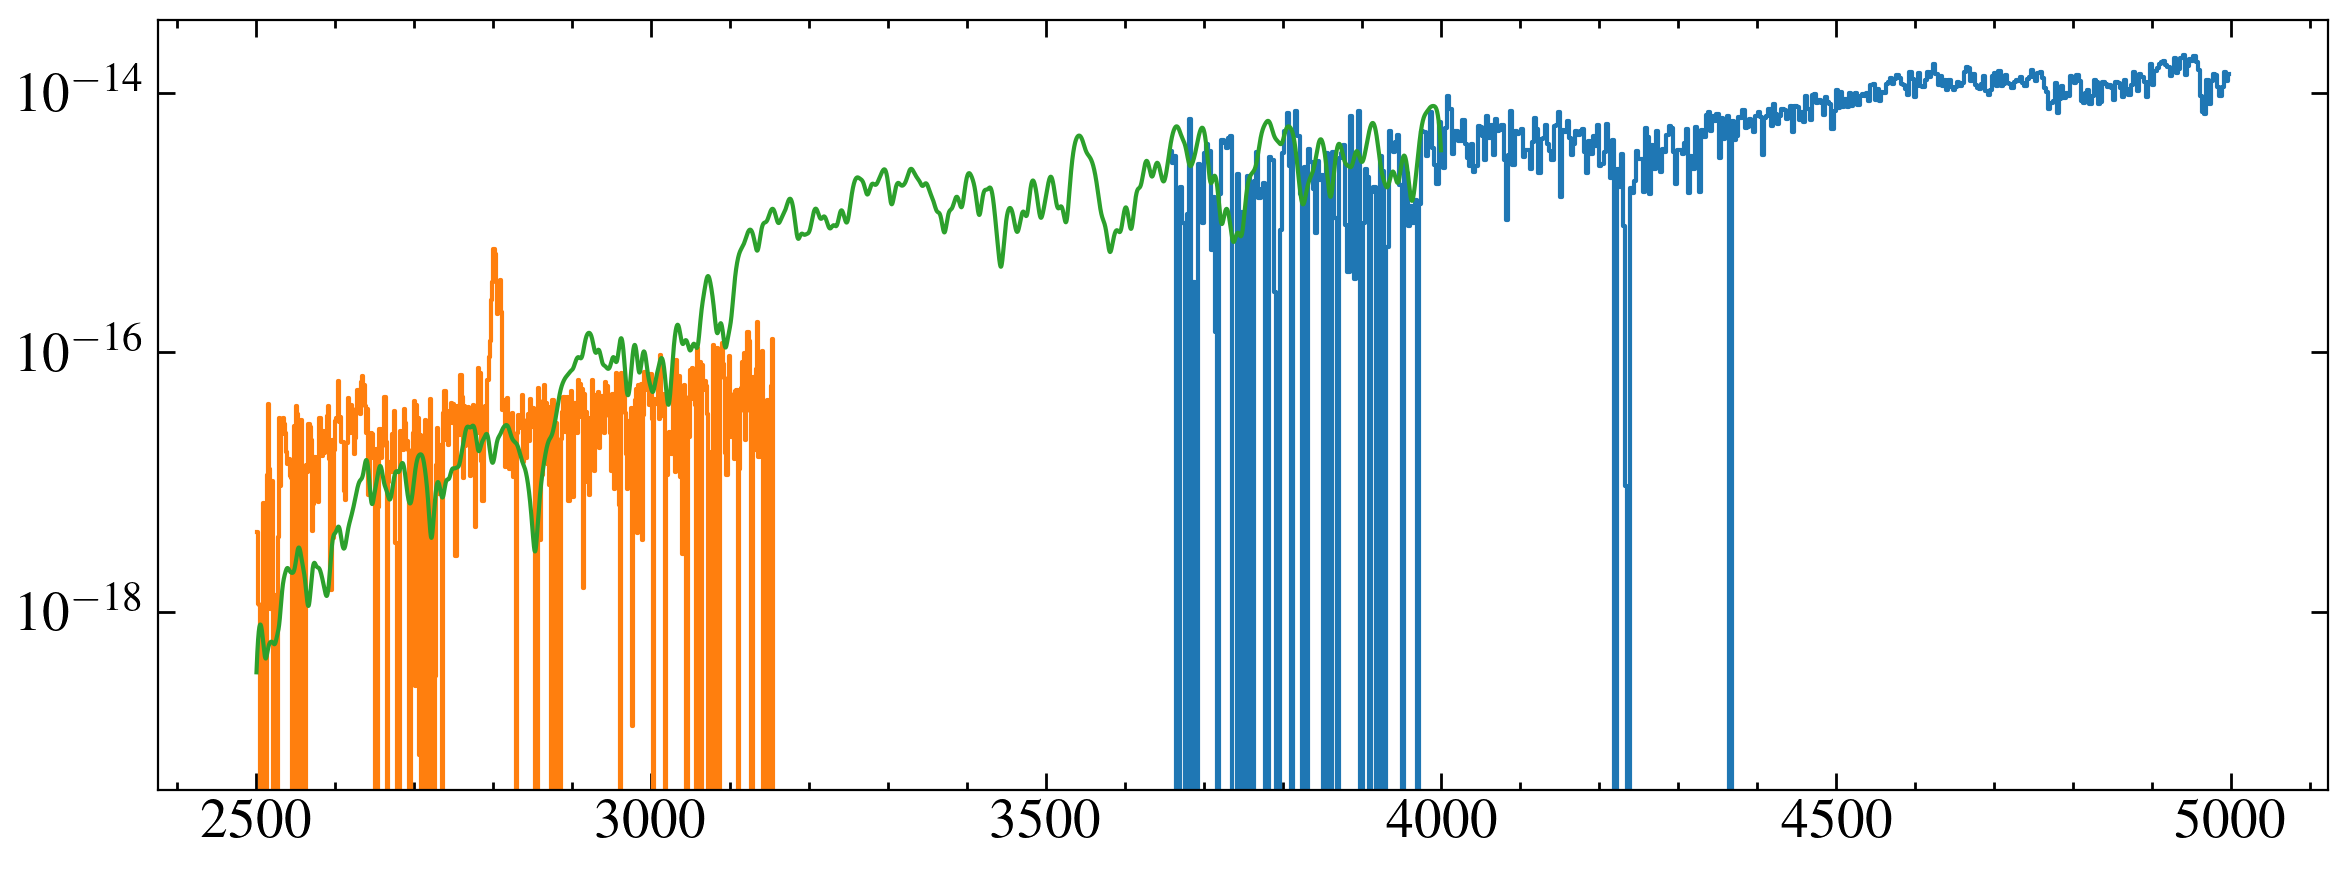

LHS-2686


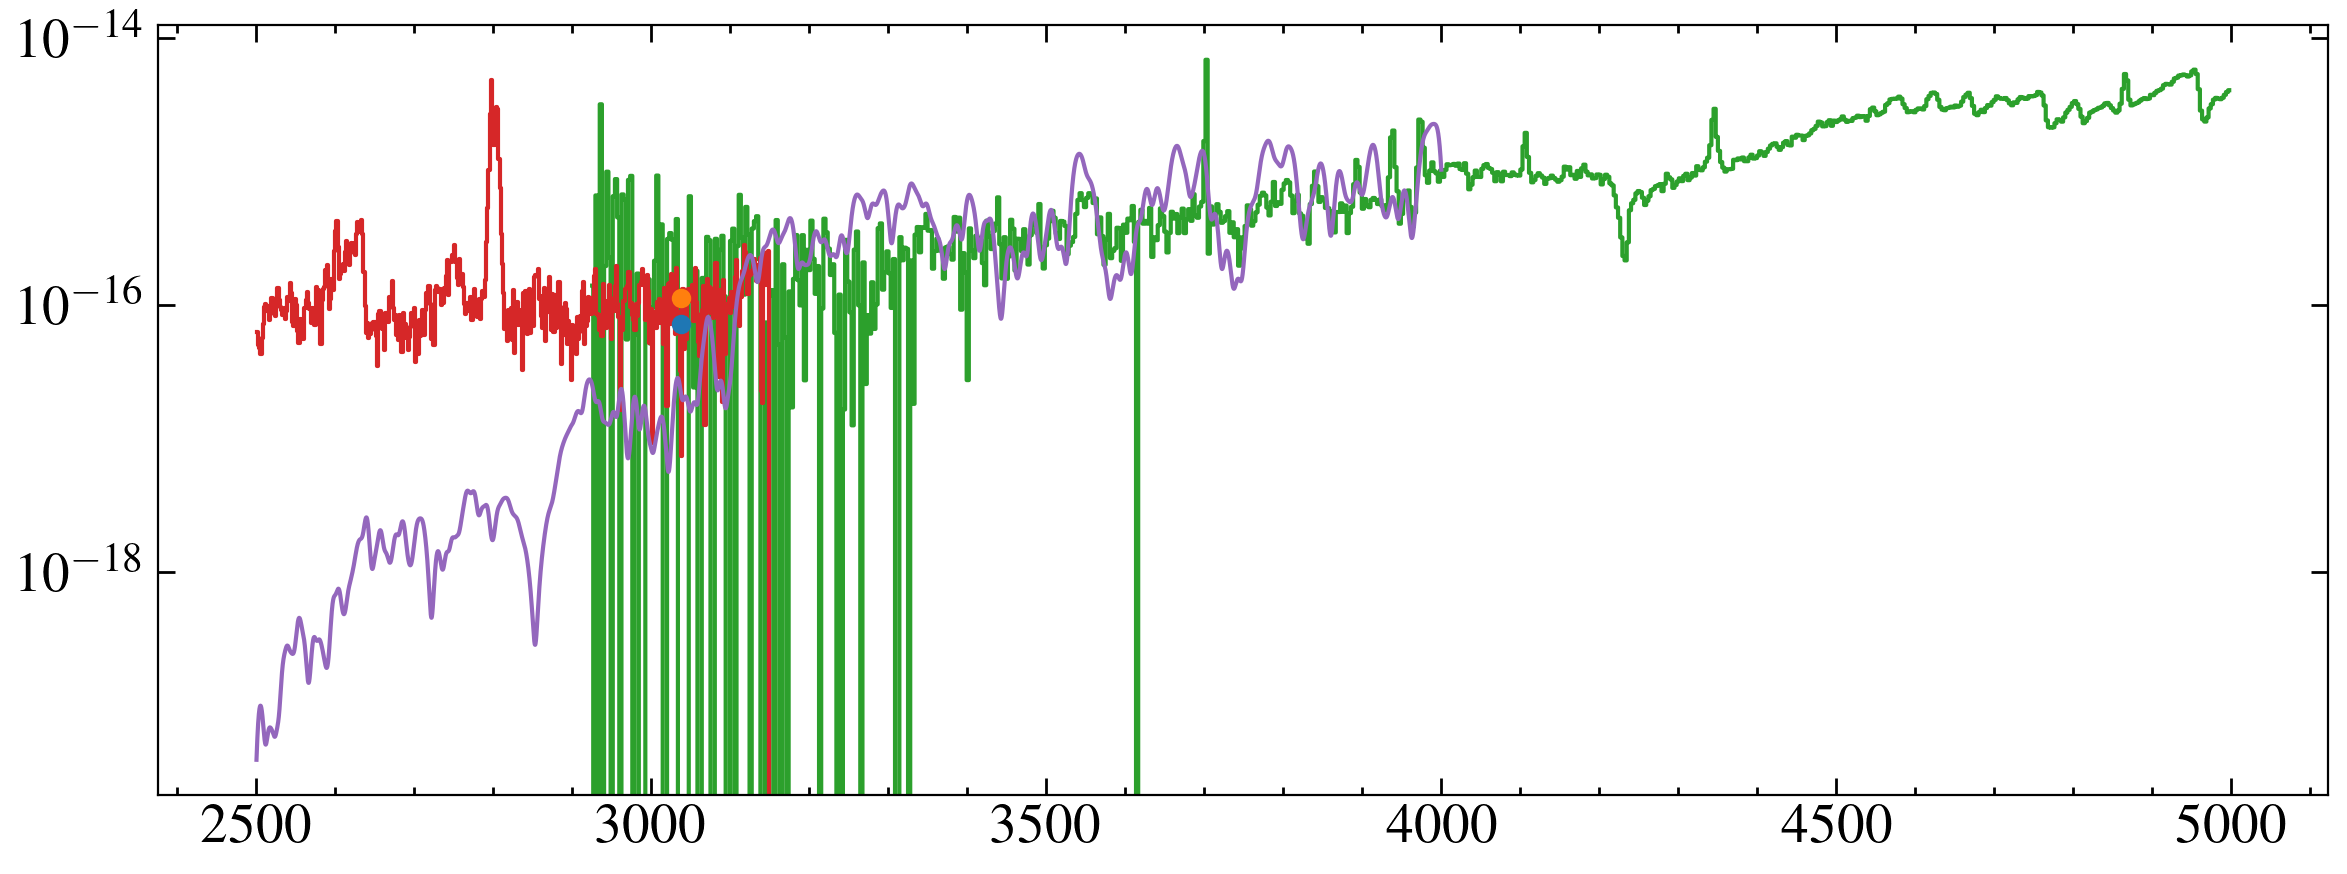

In [110]:
for star in stars[:-1]:

    print(star)
    # fuv = glob.glob('{}{}/*g140l*'.format(path, star))
    # if len(fuv) == 0:
    # fuv = glob.glob('{}{}/*e140m*'.format(path, star))
    # if len(fuv) == 0:
        # continue
    nuv = glob.glob('{}{}/*g230l*'.format(path, star))
    
    opt = glob.glob('{}{}/*g430l*'.format(path, star))
    odata = fits.getdata(opt[0], 1)
    ow, of, oe = odata['WAVELENGTH'], odata['FLUX'], odata['ERROR']
    
    bin_width = 30
    # w, f, e = g430l['WAVELENGTH'], g430l['FLUX'], g430l['ERROR']
    sn = np.array([np.mean(of[i:i+bin_width]/oe[i:i+bin_width]) for i in range(len(ow[:-bin_width]))])
    start = ow[:-bin_width][np.where(sn > 1)[0][0]]
    mask = (ow > start) & (ow < 5000)
    # mask =  (ow < 4000)
    ow, of, oe = ow[mask], of[mask], oe[mask]
    
  
    
    ndata = fits.getdata(nuv[0], 1)
    nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
    
    if nw[-1] > ow[0]:
        band = [ow[0], nw[-1]]
        bp = band[1] - band[0]

        w0, w1 = wavelength_edges(ow) 
        mask  = (ow > band[0]) & (ow < band[1]) #& (dq == 0)
        w0, w1, f, e = w0[mask], w1[mask], of[mask], oe[mask]
        ofi = np.sum(f*(w1-w0)) / bp
        oei = ((np.sum(e**2 * (w1-w0)**2))**0.5 )/bp

        plt.errorbar(np.mean(band), ofi, yerr=oei, marker='o')

        w0, w1 = wavelength_edges(nw) 
        mask  = (nw > band[0]) & (nw < band[1]) #& (dq == 0)
        w0, w1, f, e = w0[mask], w1[mask], nf[mask], ne[mask]
        nfi = np.sum(f*(w1-w0)) /bp
        nei = ((np.sum(e**2 * (w1-w0)**2))**0.5 ) /bp

        plt.errorbar(np.mean(band), nfi, yerr=nei, marker='o')

#     lap = [1600, 1750]
#     fmask = (fw > lap[0]) & (fw < lap[1])
#     fw, ff, fe = fw[fmask], ff[fmask], fe[fmask]
    
    nmask = (nw > 2500) #& (nw < lap[1])
    nw, nf, ne = nw[nmask], nf[nmask], ne[nmask]
    
    plt.step(ow, of, where='mid')
    plt.step(nw, nf, where='mid')
    
    phx = glob.glob('{}{}/*phx*'.format(path, star))
    pdata = fits.getdata(phx[0], 1)
    pw, pf = pdata['WAVELENGTH'], pdata['FLUX']
    
    pmask = (pw > 2500) & (pw < 4000)
    pw, pf = pw[pmask], pf[pmask]
    pf *= fits.getheader(phx[0], 0)['NORMFAC']
    
    pw, pf = smear(pw, pf, 1000)
    
    plt.plot(pw, pf)
    
    plt.yscale('log')

    
#     lines =[1630, 1680]
#     nlinemask = (nw > lines[0]) & (nw < lines[1])
#     nint = np.trapz(nf[nlinemask], nw[nlinemask])

#     flinemask = (fw > lines[0]) & (fw < lines[1])
#     fint = np.trapz(ff[flinemask], fw[flinemask])

#     print(nint, fint, nint/fint)
    
#     scale = nint/fint
    
#     plt.plot(fw, ff*scale, ls='--', alpha=0.5)

    
    plt.show()


Might have to admit defeat. At GJ 15A and LHS 2686 thee is reasonalble overap and they are in good agreement. No scaling needed? Check the FUV overlap with COS. How many G140M have NV and SIII

GJ1132


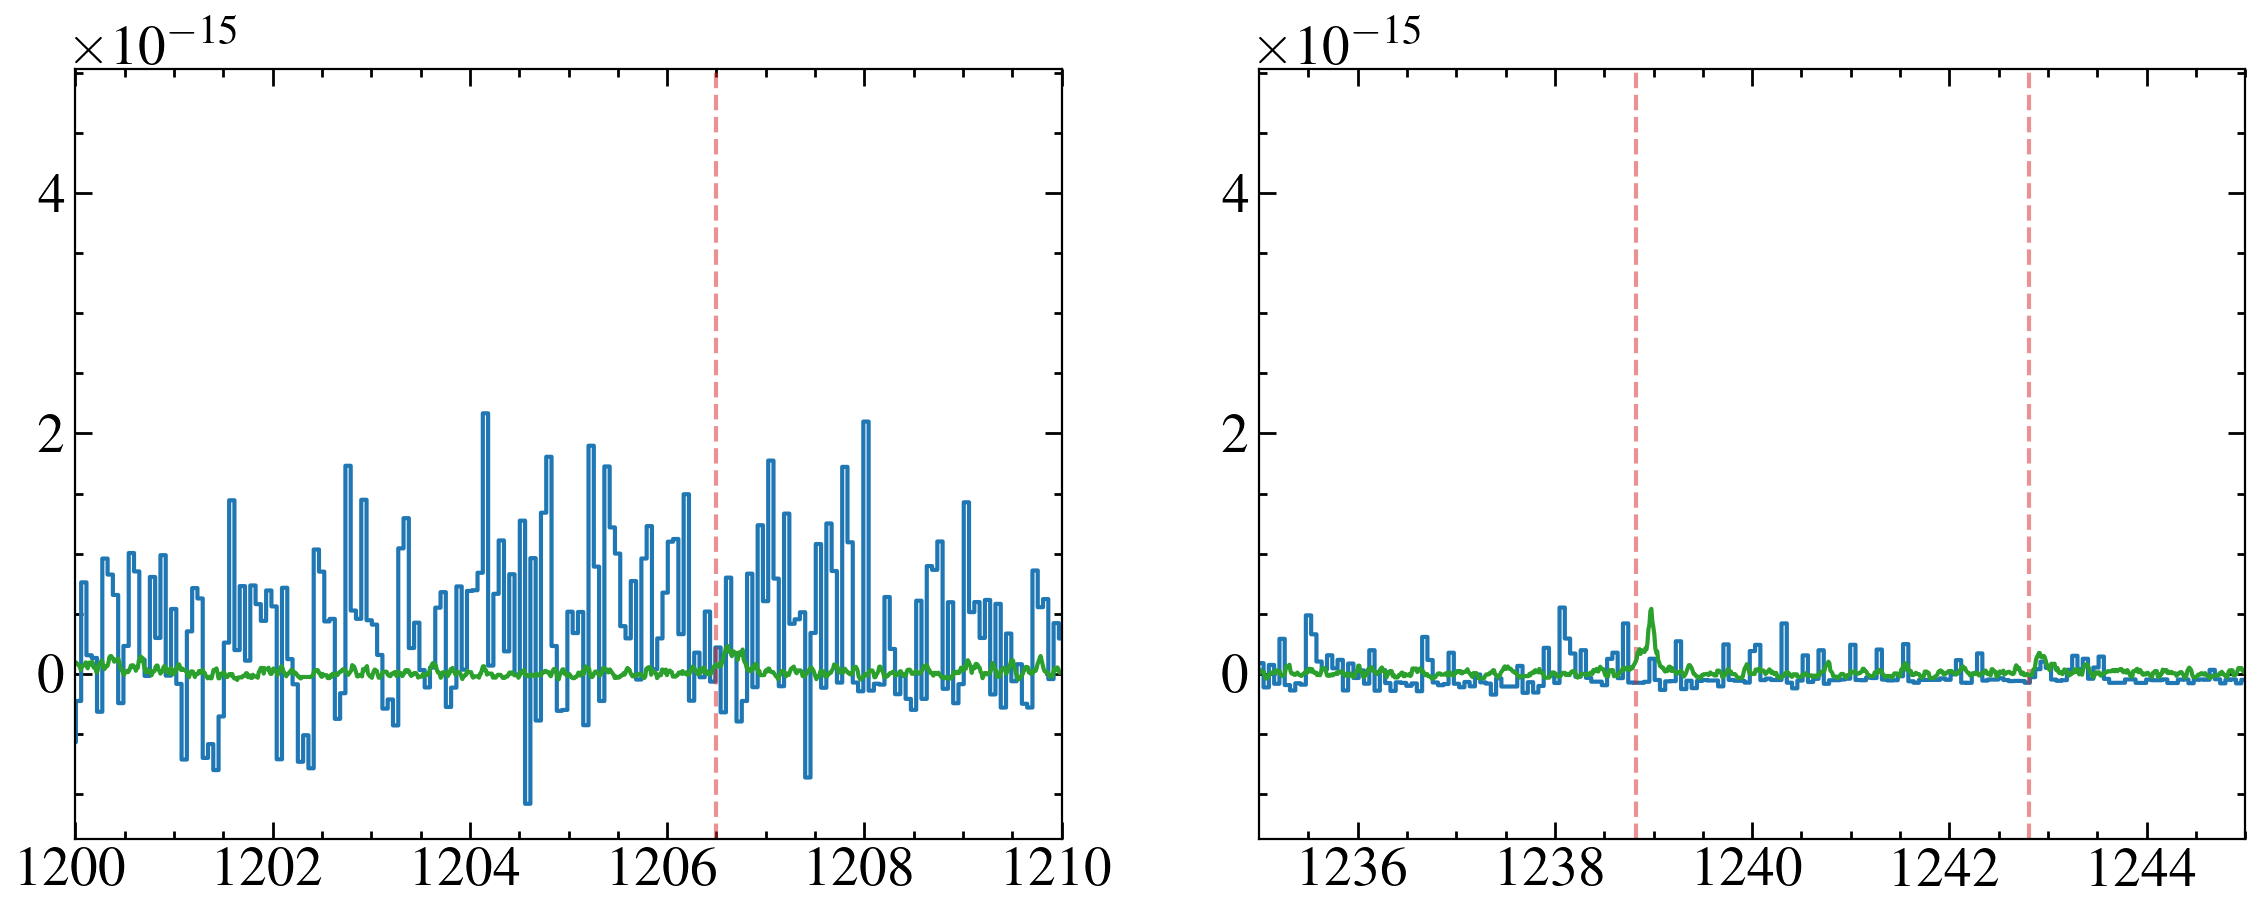

GJ15A
GJ163


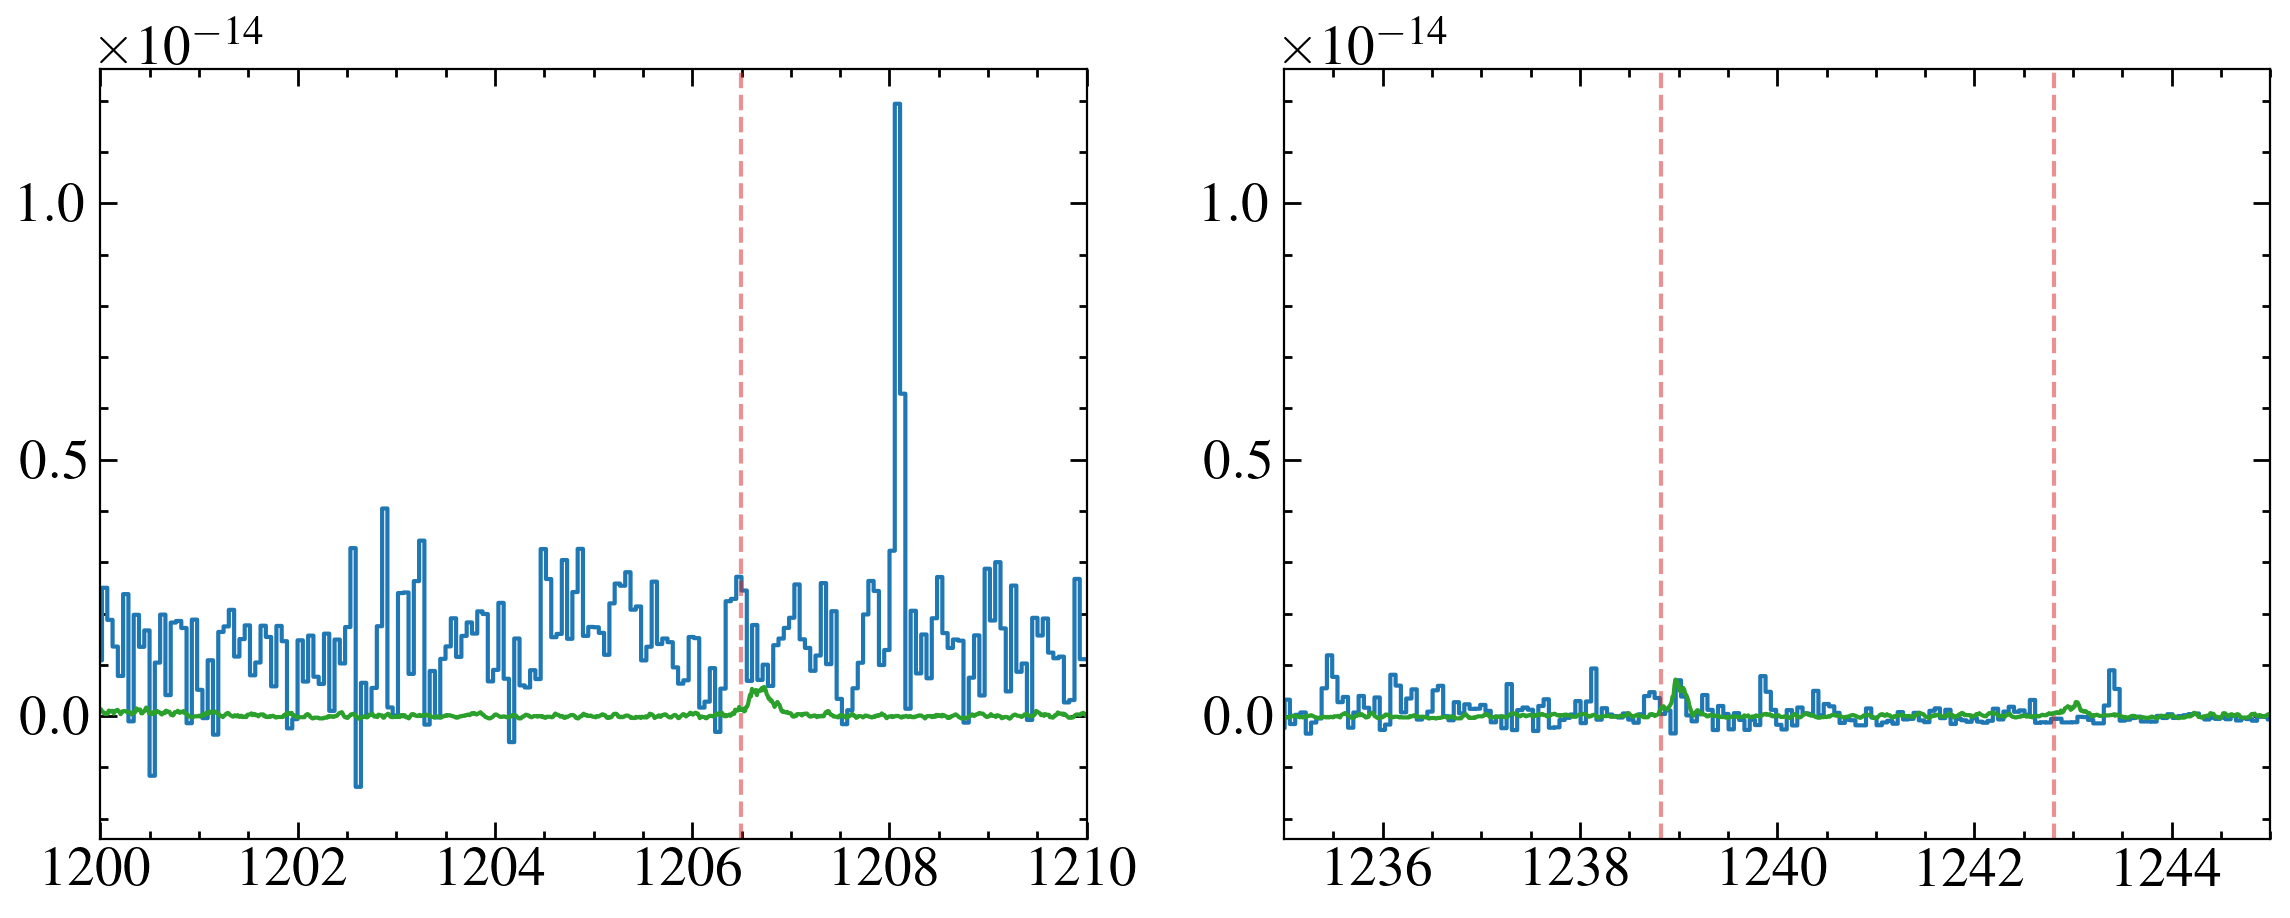

GJ649


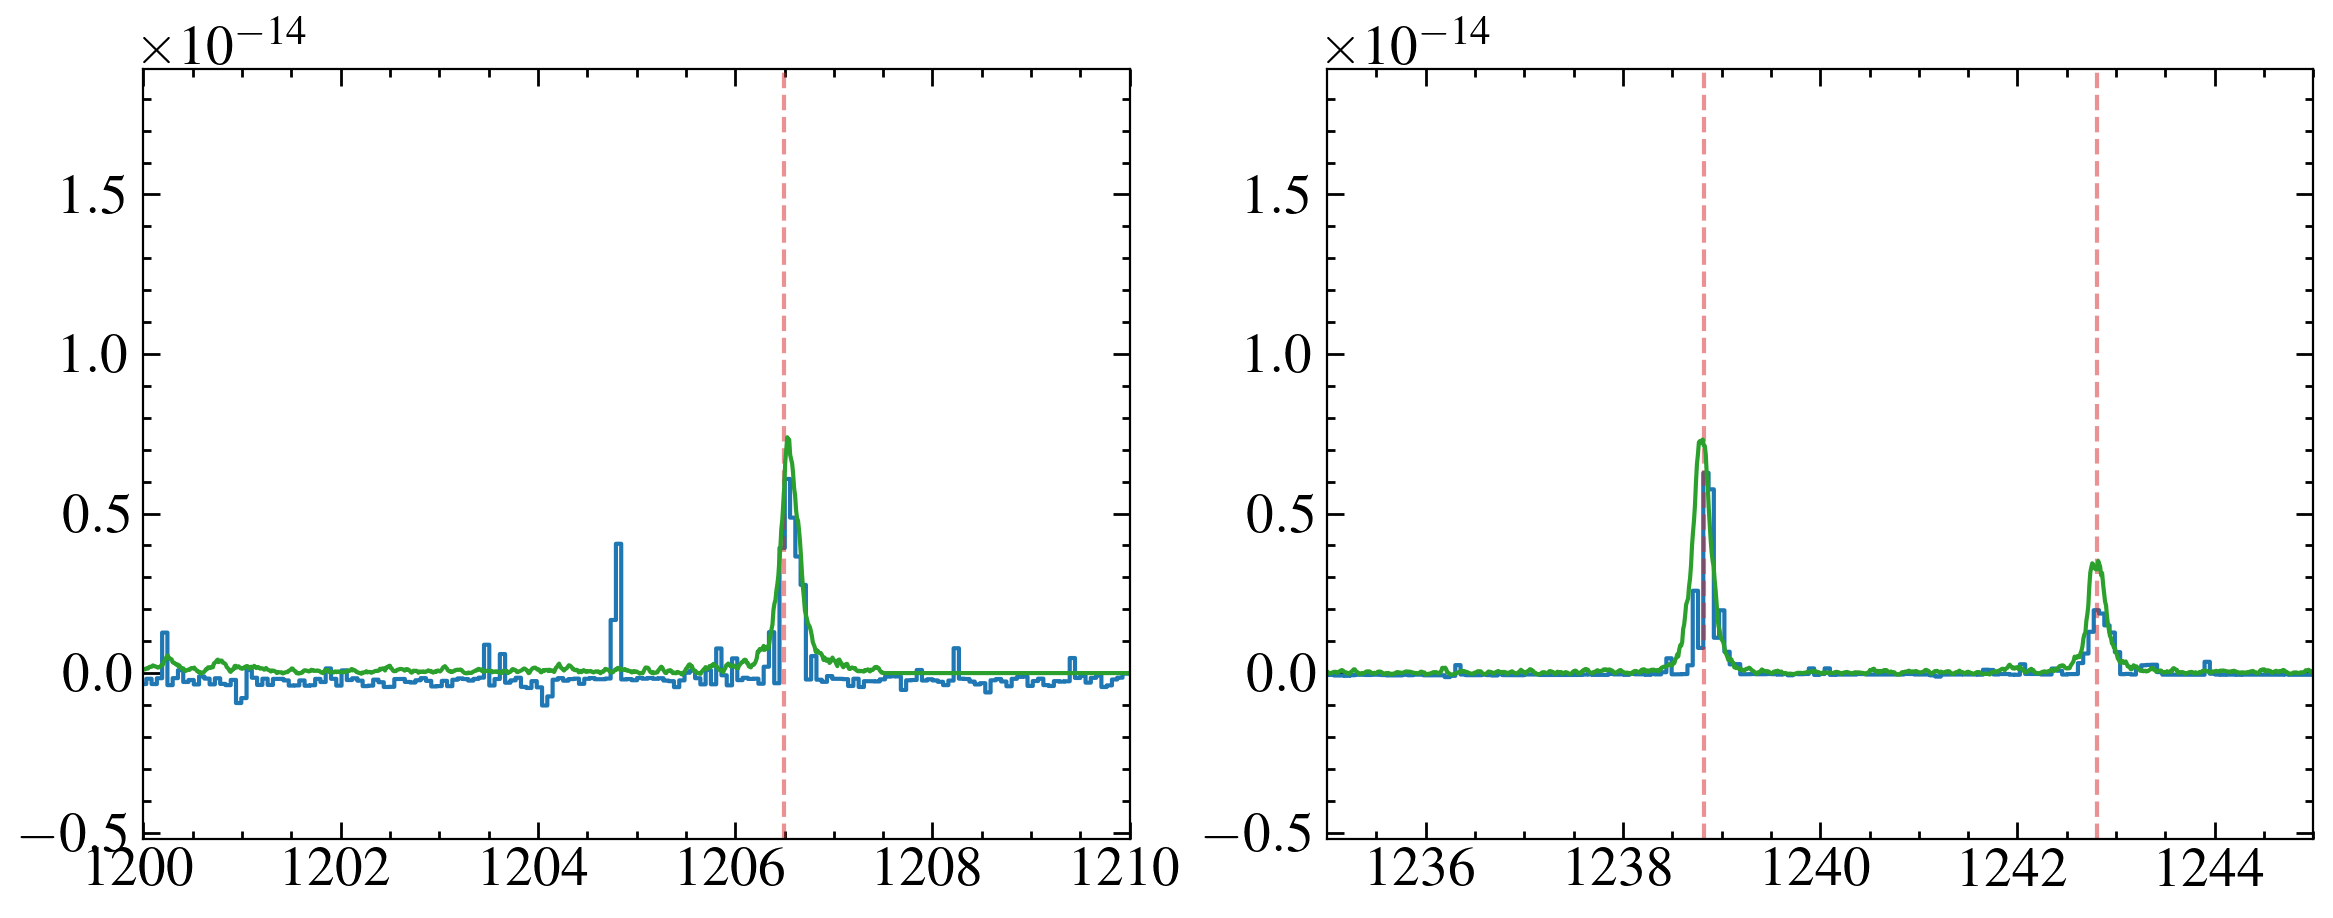

GJ674


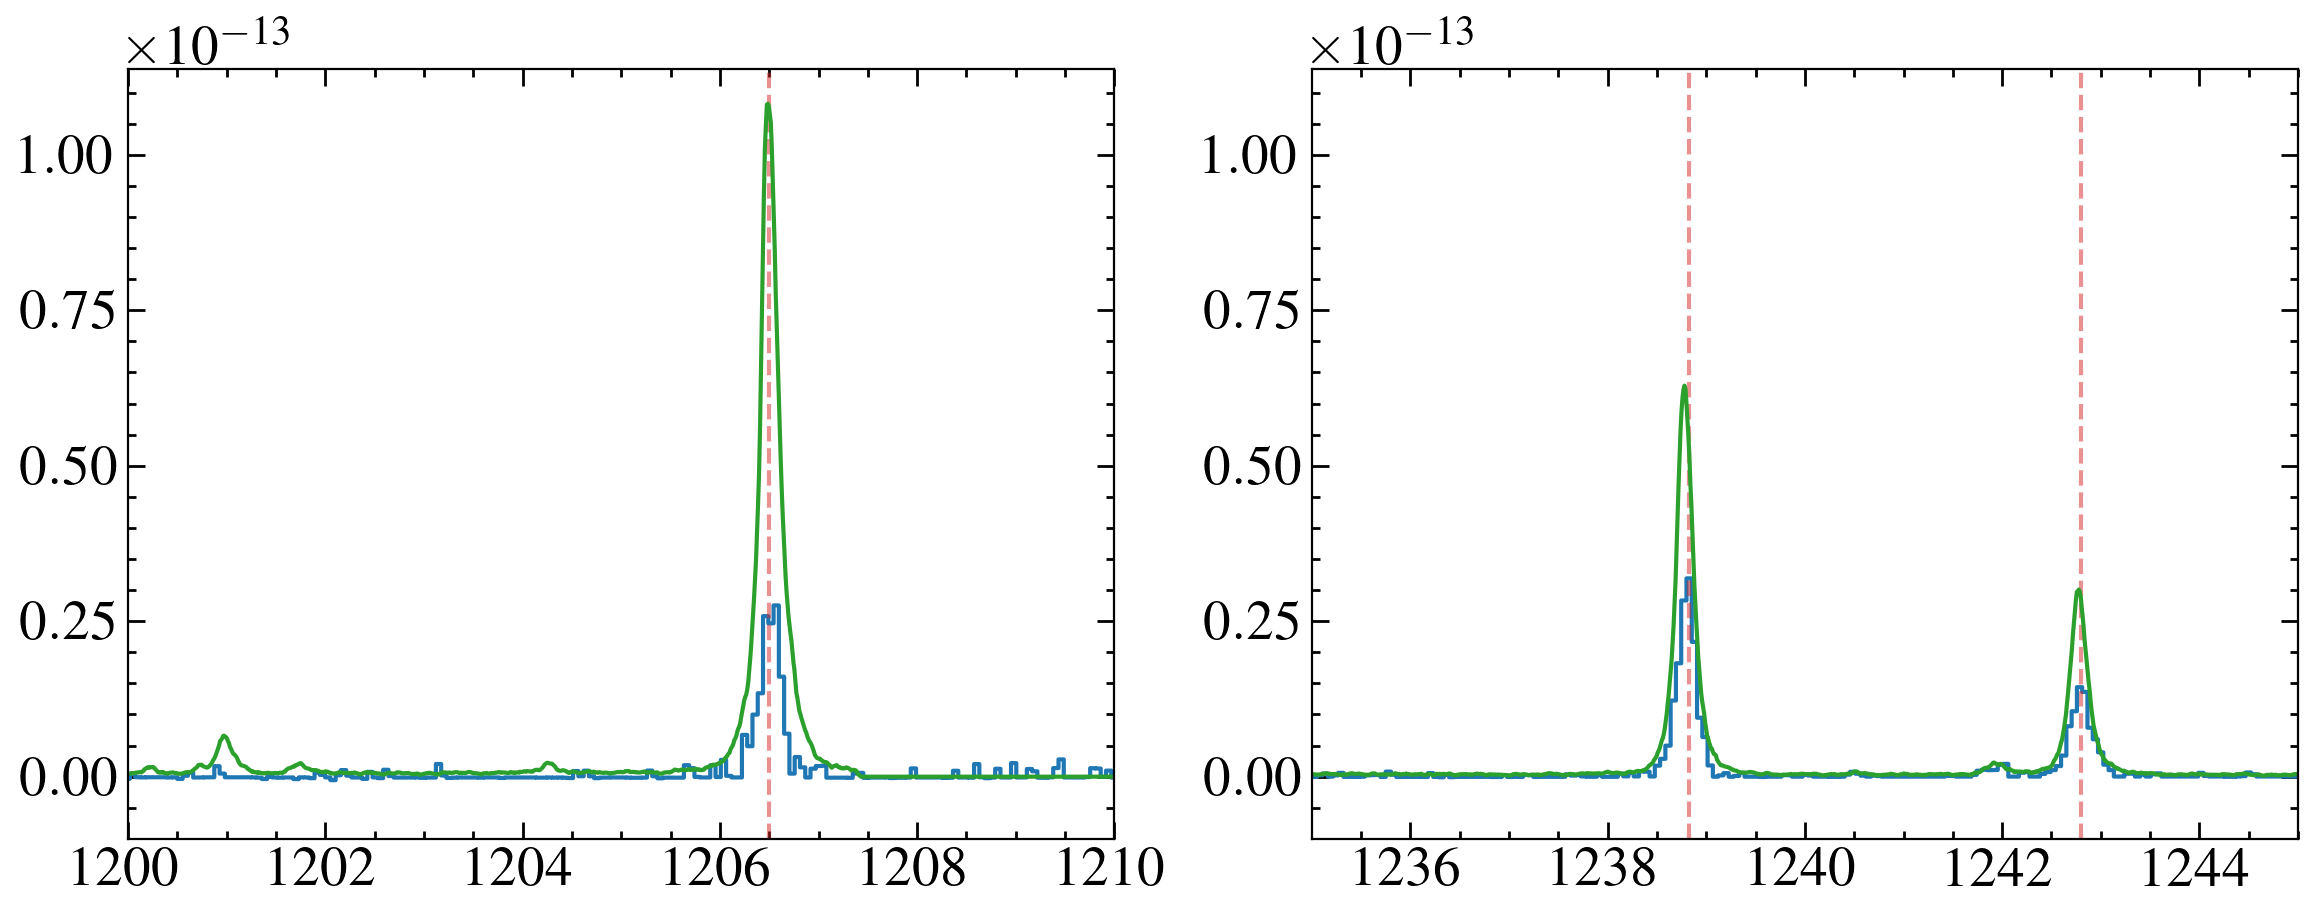

GJ676A


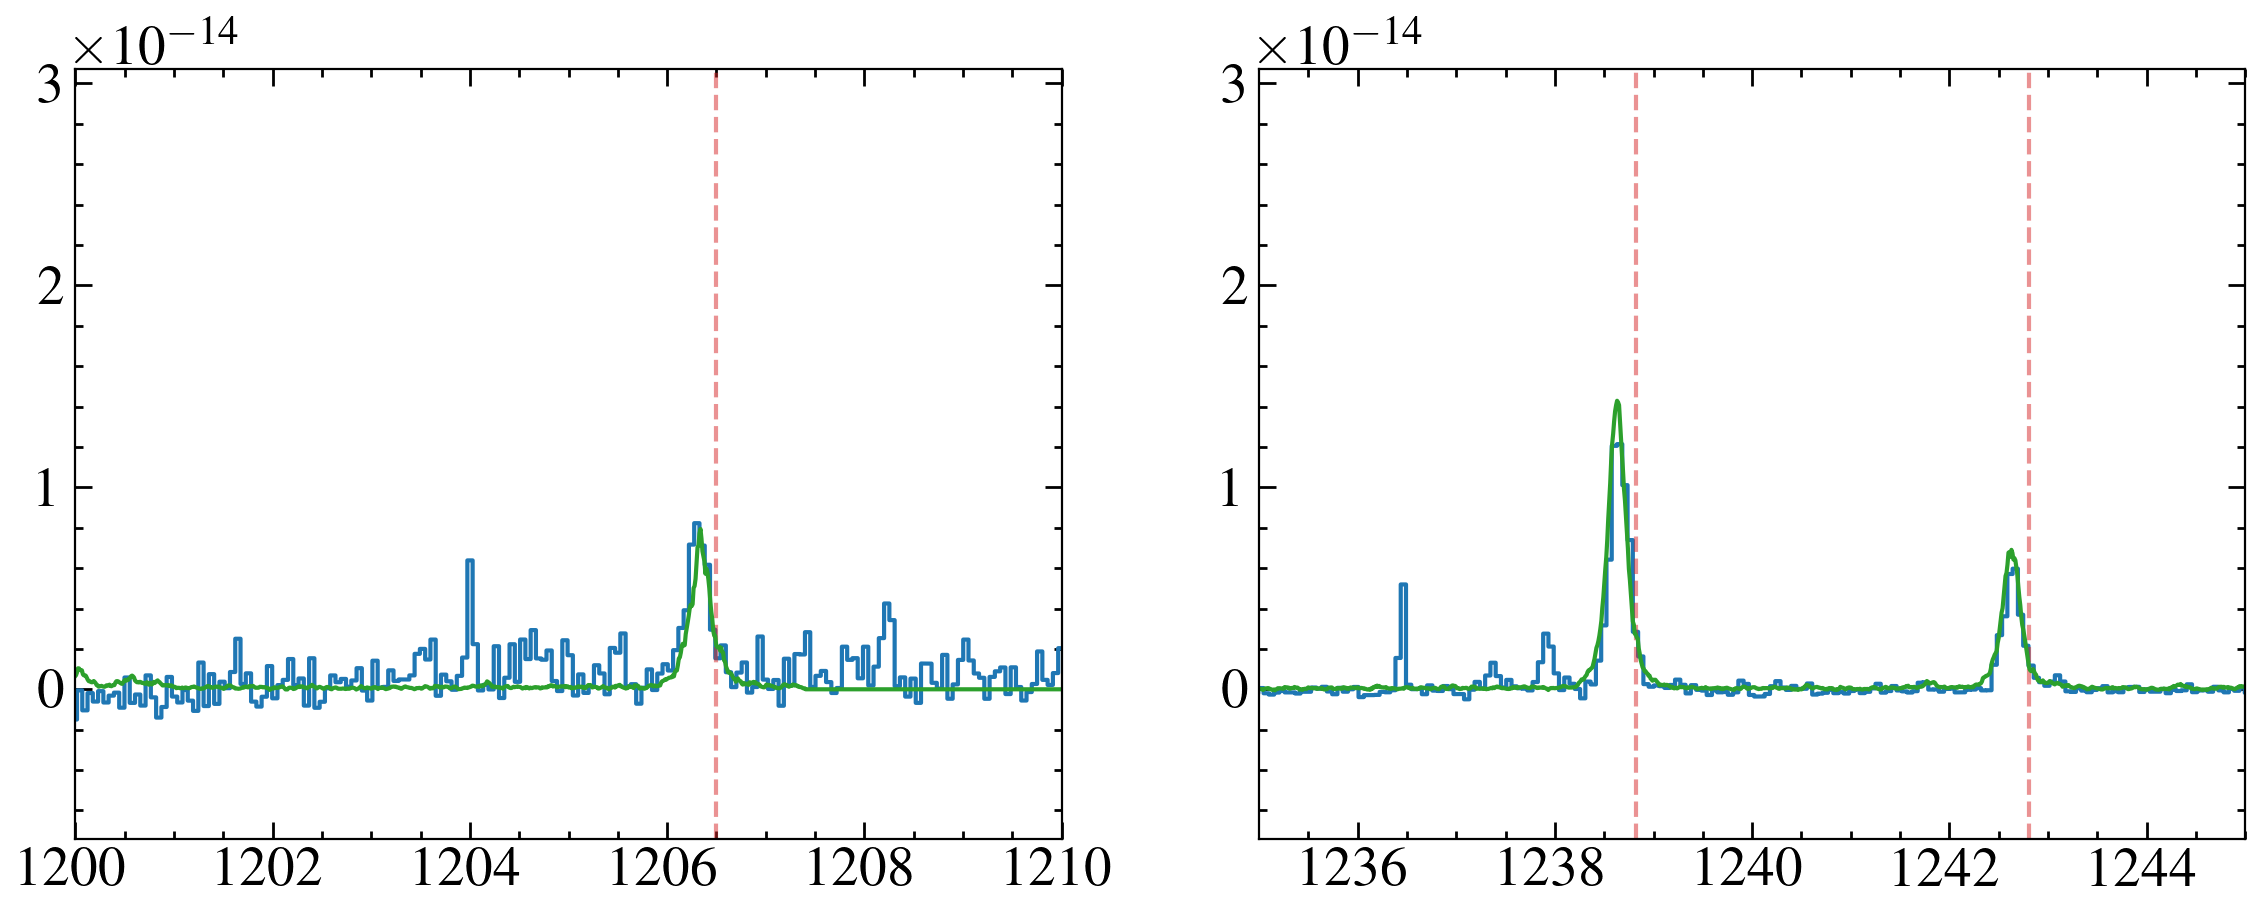

GJ699


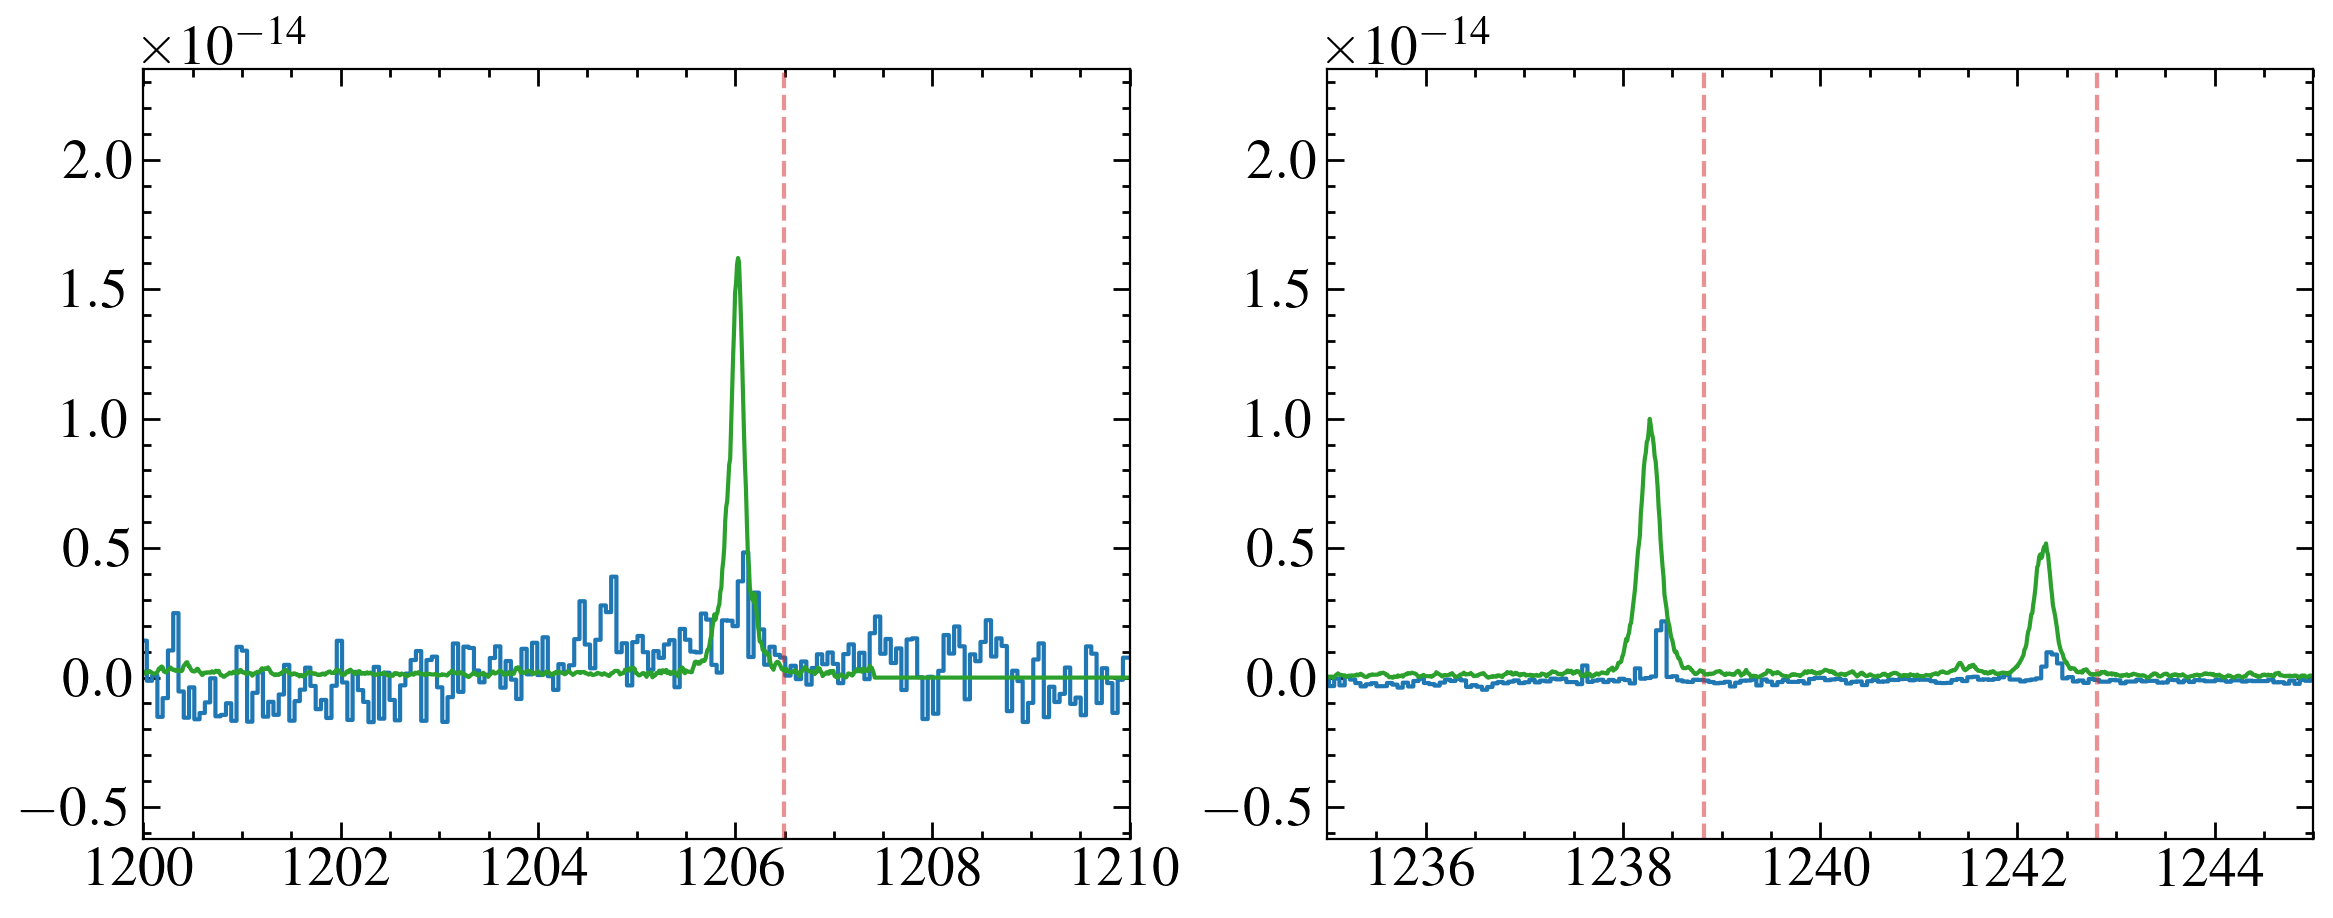

GJ729
GJ849


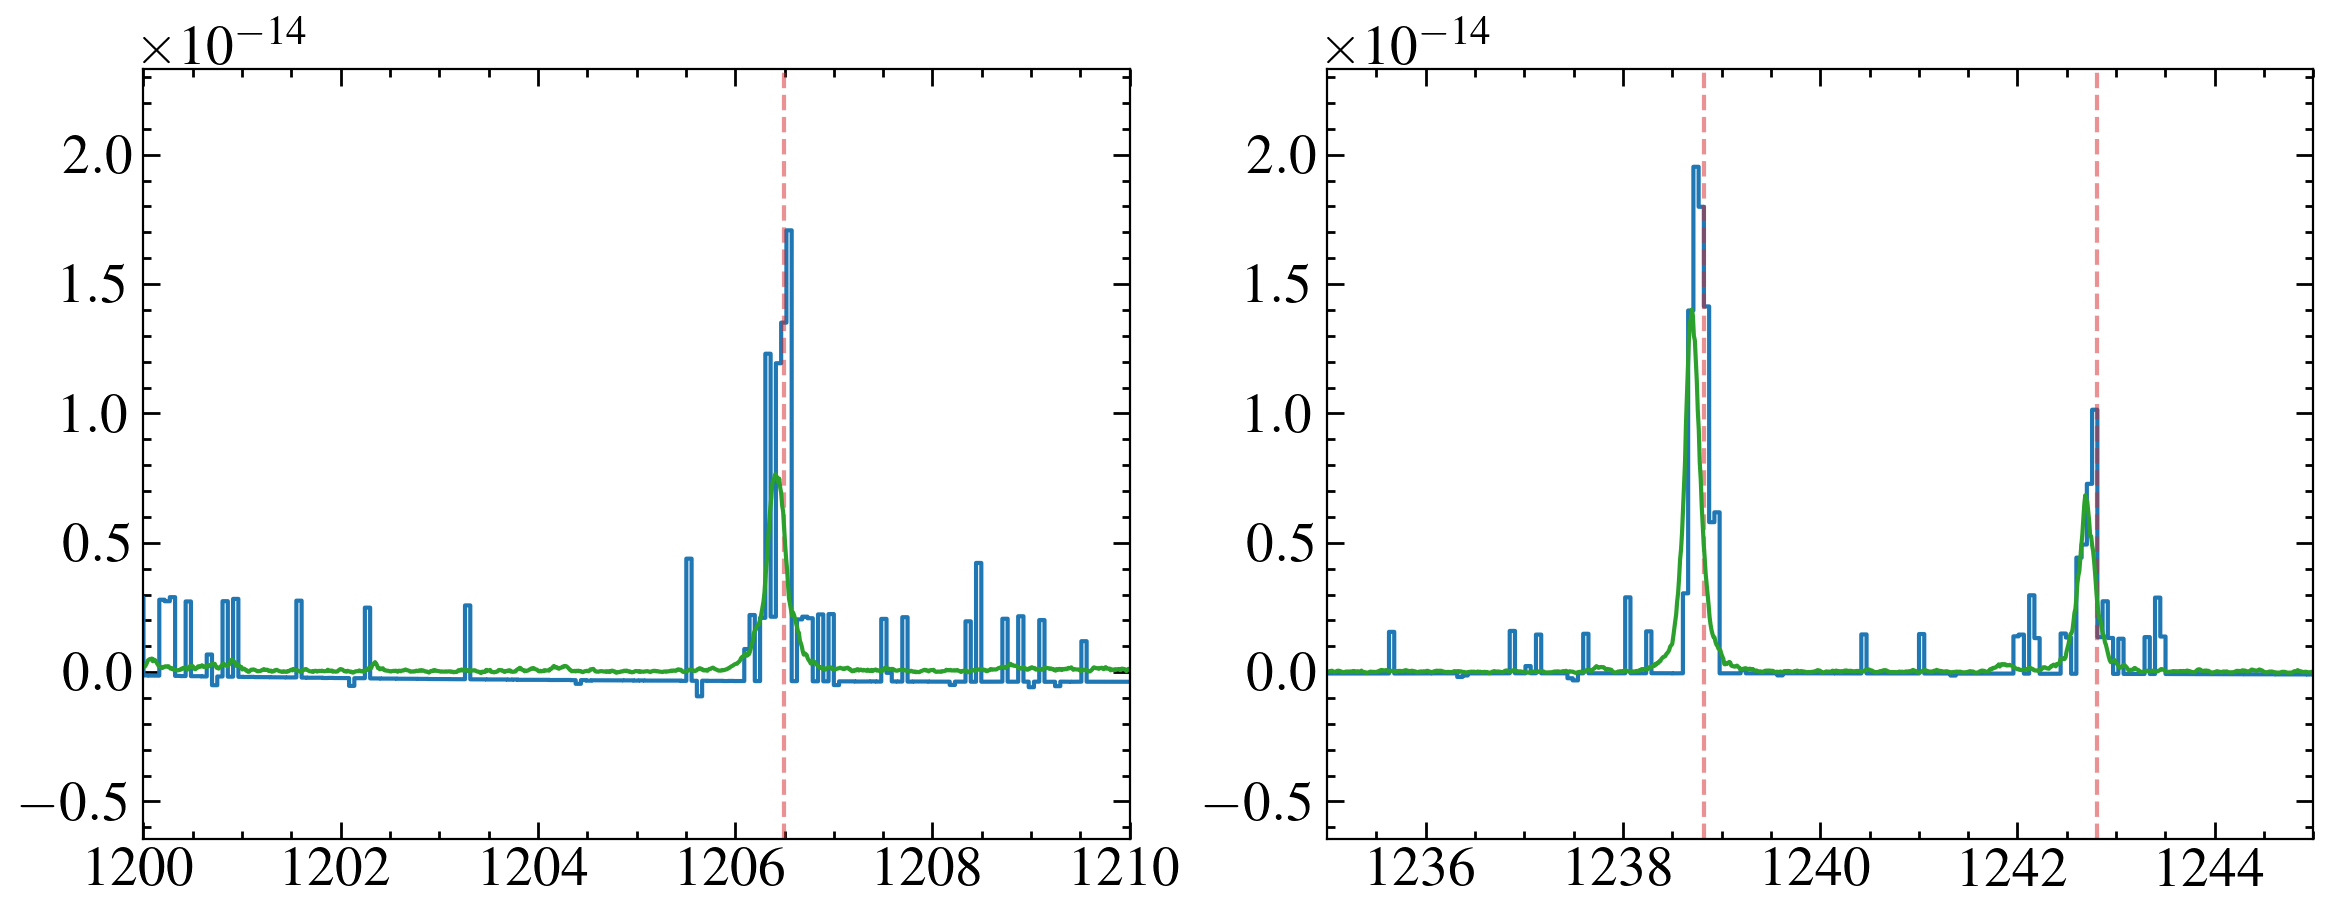

L-980-5


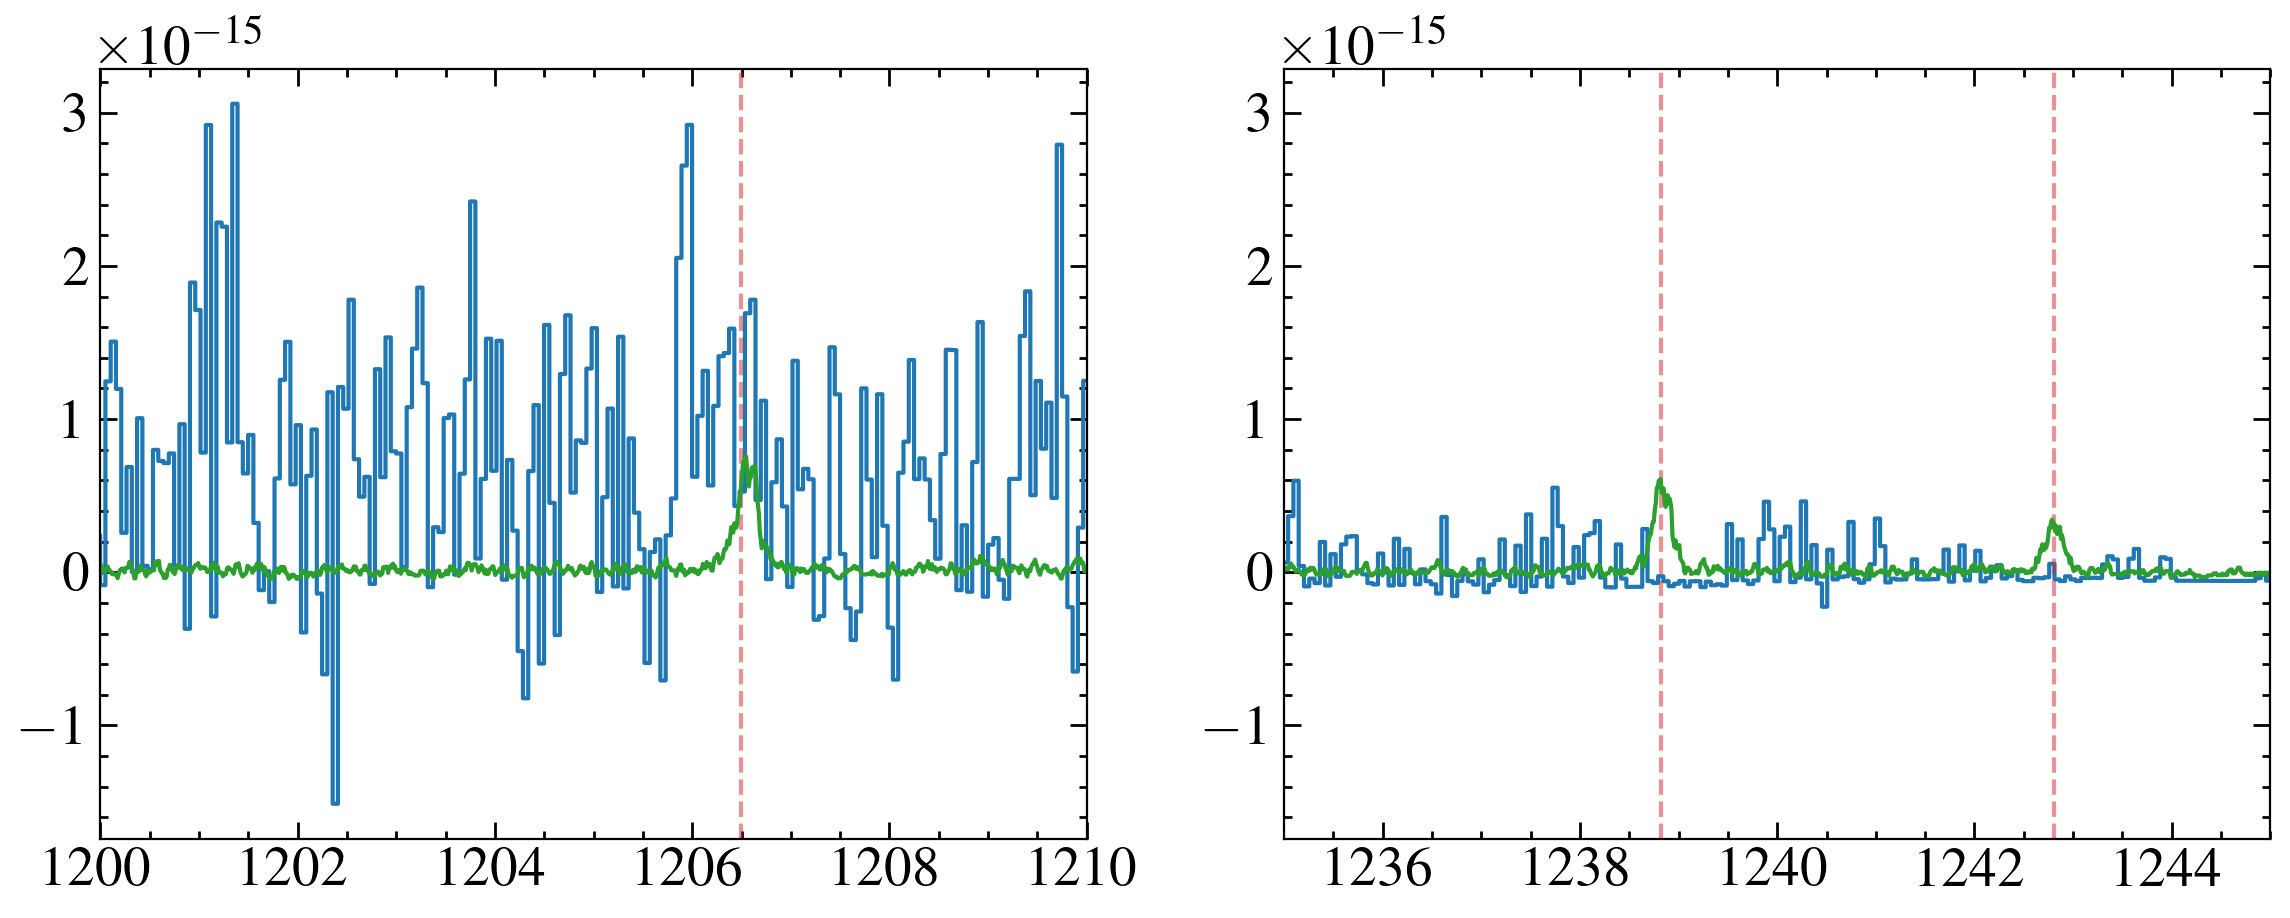

LHS-2686


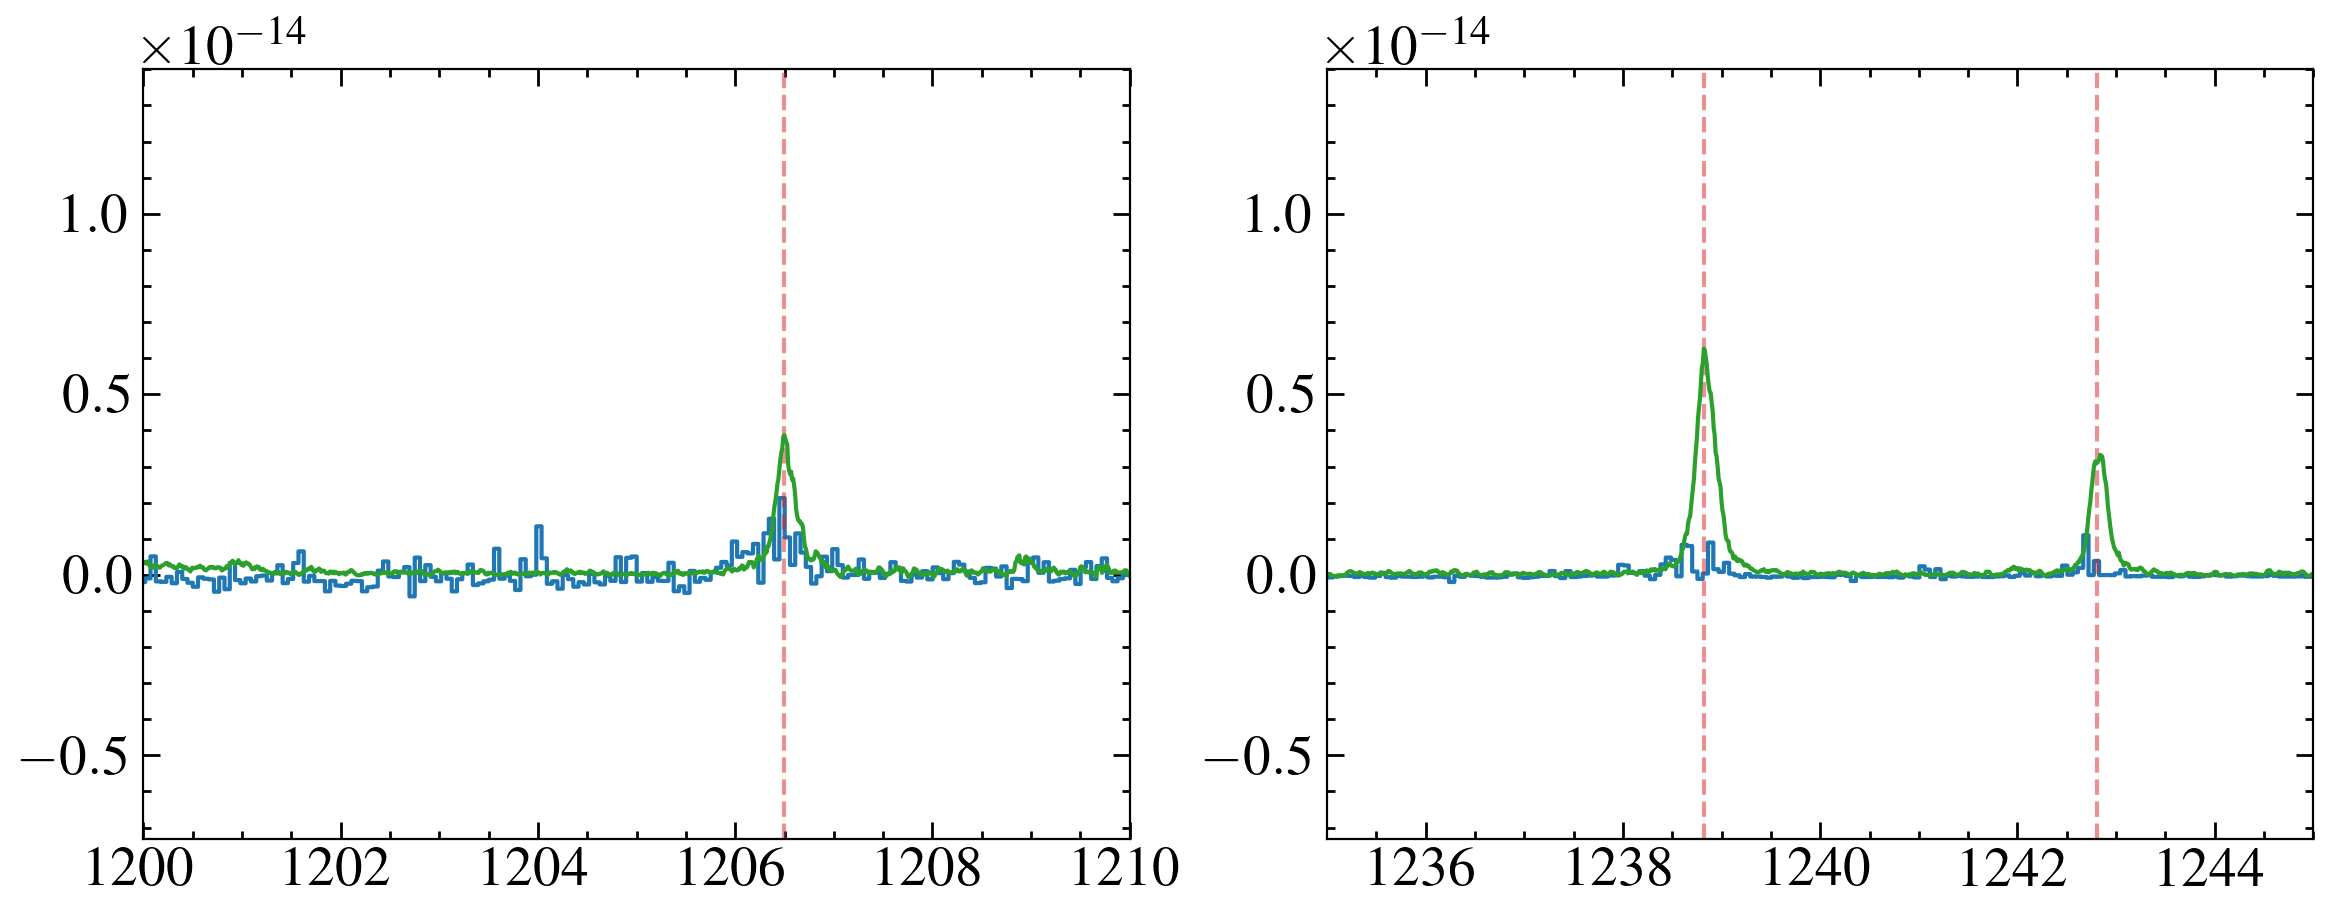

In [131]:
lines = [1206.499, 1238.821,1242.804]
for star in stars[:-1]:
    print(star)
    fuv = glob.glob('{}{}/*g140m*'.format(path, star))
    # if len(fuv) == 0:
    #     fuv = glob.glob('{}{}/*e140m*'.format(path, star))
    if len(fuv) == 0:
        continue
    # nuv = glob.glob('{}{}/*g230l*'.format(path, star))
    
    fdata = fits.getdata(fuv[0], 1)
    fw, ff, fe = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']
    
    mask = (fw < 1210) | (fw > 1220) #mask lya
    
    fw, ff, fe = fw[mask], ff[mask], fe[mask]
    
    # smooth = 2
    # ff = convolve(ff,Box1DKernel(smooth))
    # fe = convolve(fe,Box1DKernel(smooth))/(smooth**0.5)
    
    
    # plt.step(fw, ff, where='mid')
    # plt.step(fw, fe, where='mid')
    
    [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
    cos = glob.glob('{}{}/*g130m*'.format(path, star))
    if len(cos) > 0:
        smooth=5
        cdata = fits.getdata(cos[0], 1)
        cw, cf, ce = cdata['WAVELENGTH'], cdata['FLUX'], cdata['ERROR']
        mask = (cw < 1210) | (cw > 1220) #mask lya
        cw, cf, ce = cw[mask], cf[mask], ce[mask]
        cf = convolve(cf,Box1DKernel(smooth))
        ce = convolve(ce,Box1DKernel(smooth))/(smooth**0.5)
        # plt.plot(cw, cf, alpha=0.5)#, zorder=-10)
        
    plt.subplot(121)
    
    plt.step(fw, ff, where='mid')
    # plt.step(fw, fe, where='mid')
    
    [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
    plt.plot(cw, cf,  c='C2')#, zorder=-10)

        
    plt.xlim(1200, 1210)
    
    
    plt.subplot(122)
    
    plt.step(fw, ff, where='mid')
    # plt.step(fw, fe, where='mid')
    
    [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
    plt.plot(cw, cf, c='C2')#, zorder=-10)

        
    plt.xlim(1235, 1245)
    
    plt.show()

ugrh flares. Flare in LHS 2886?

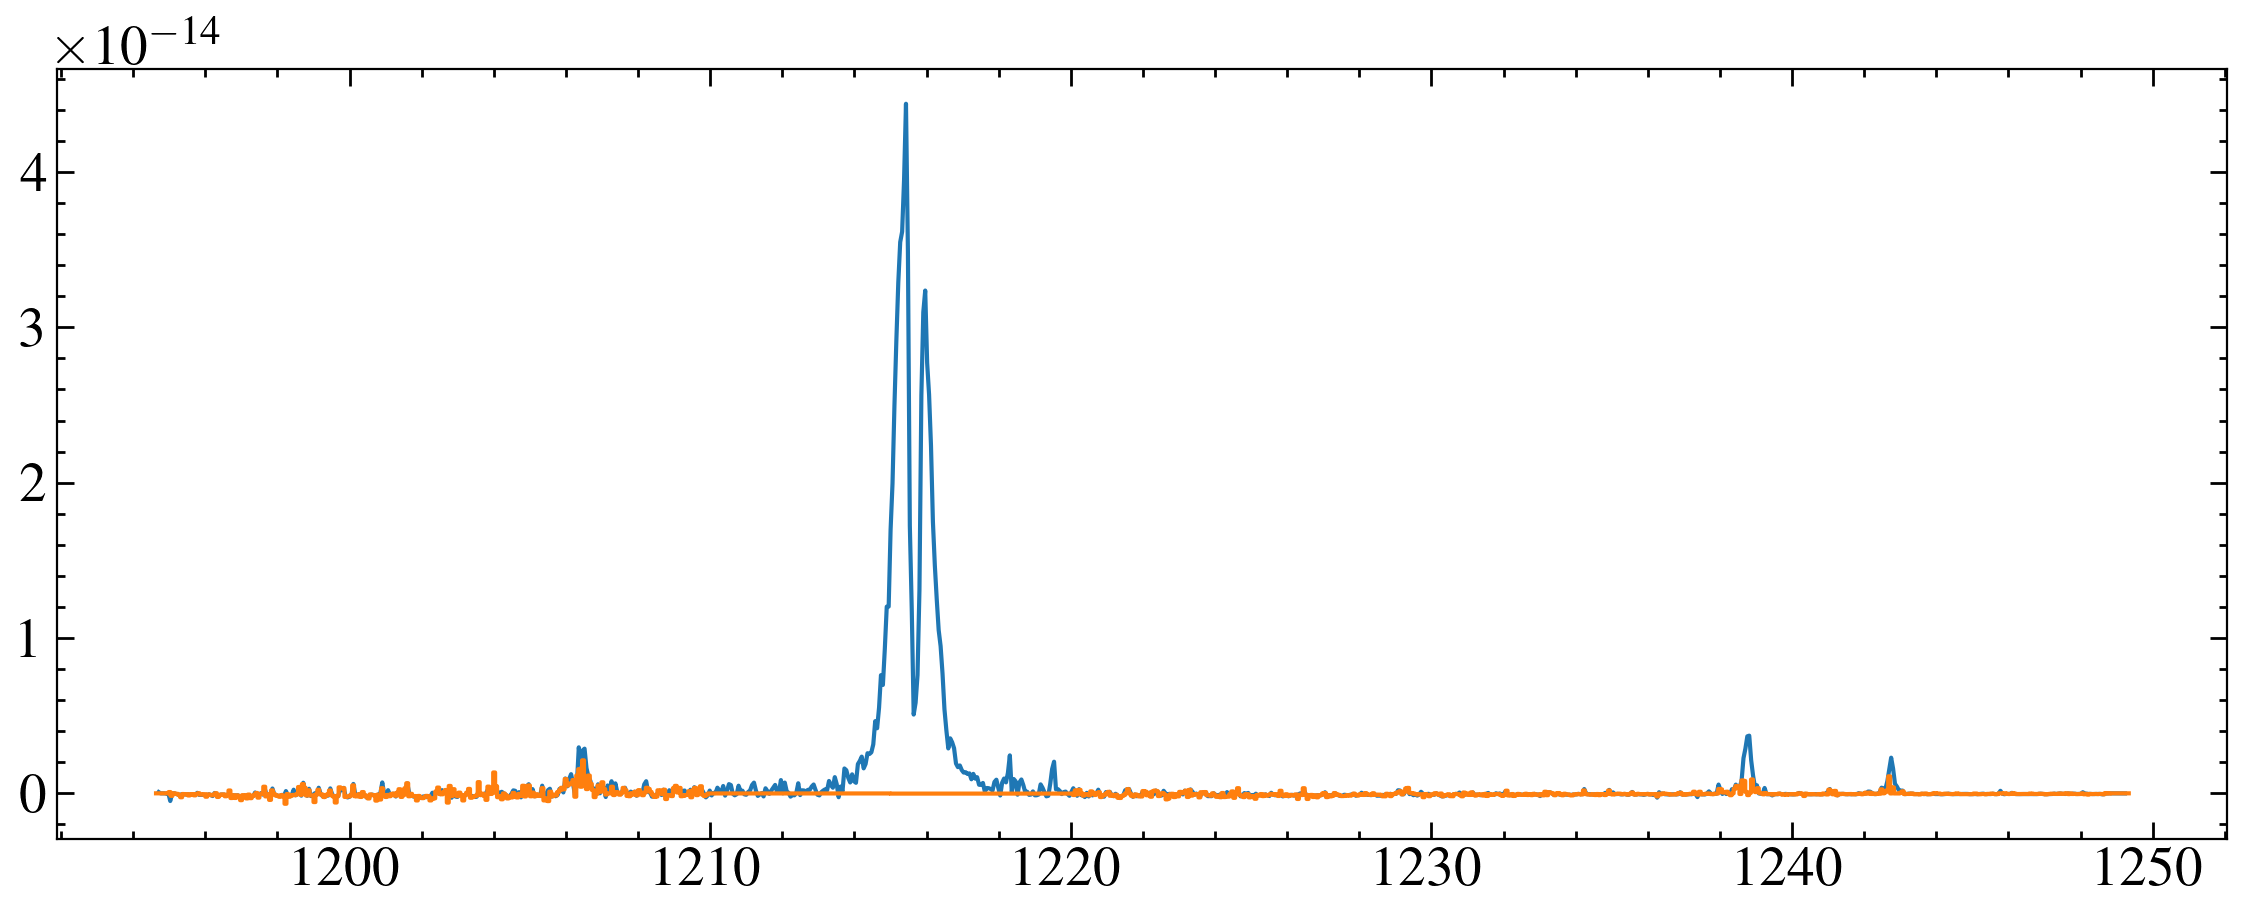

In [130]:
spec = Table.read('../lya/coadds/LHS-2686_g140m_coadd_v1.ecsv')
w,f, e = spec['WAVELENGTH'], spec['FLUX'], spec['ERROR']
plt.plot(w,f)
plt.step(fw, ff, where='mid')

Uh-oh, did I not include the re-extracted spectra?

GJ1132


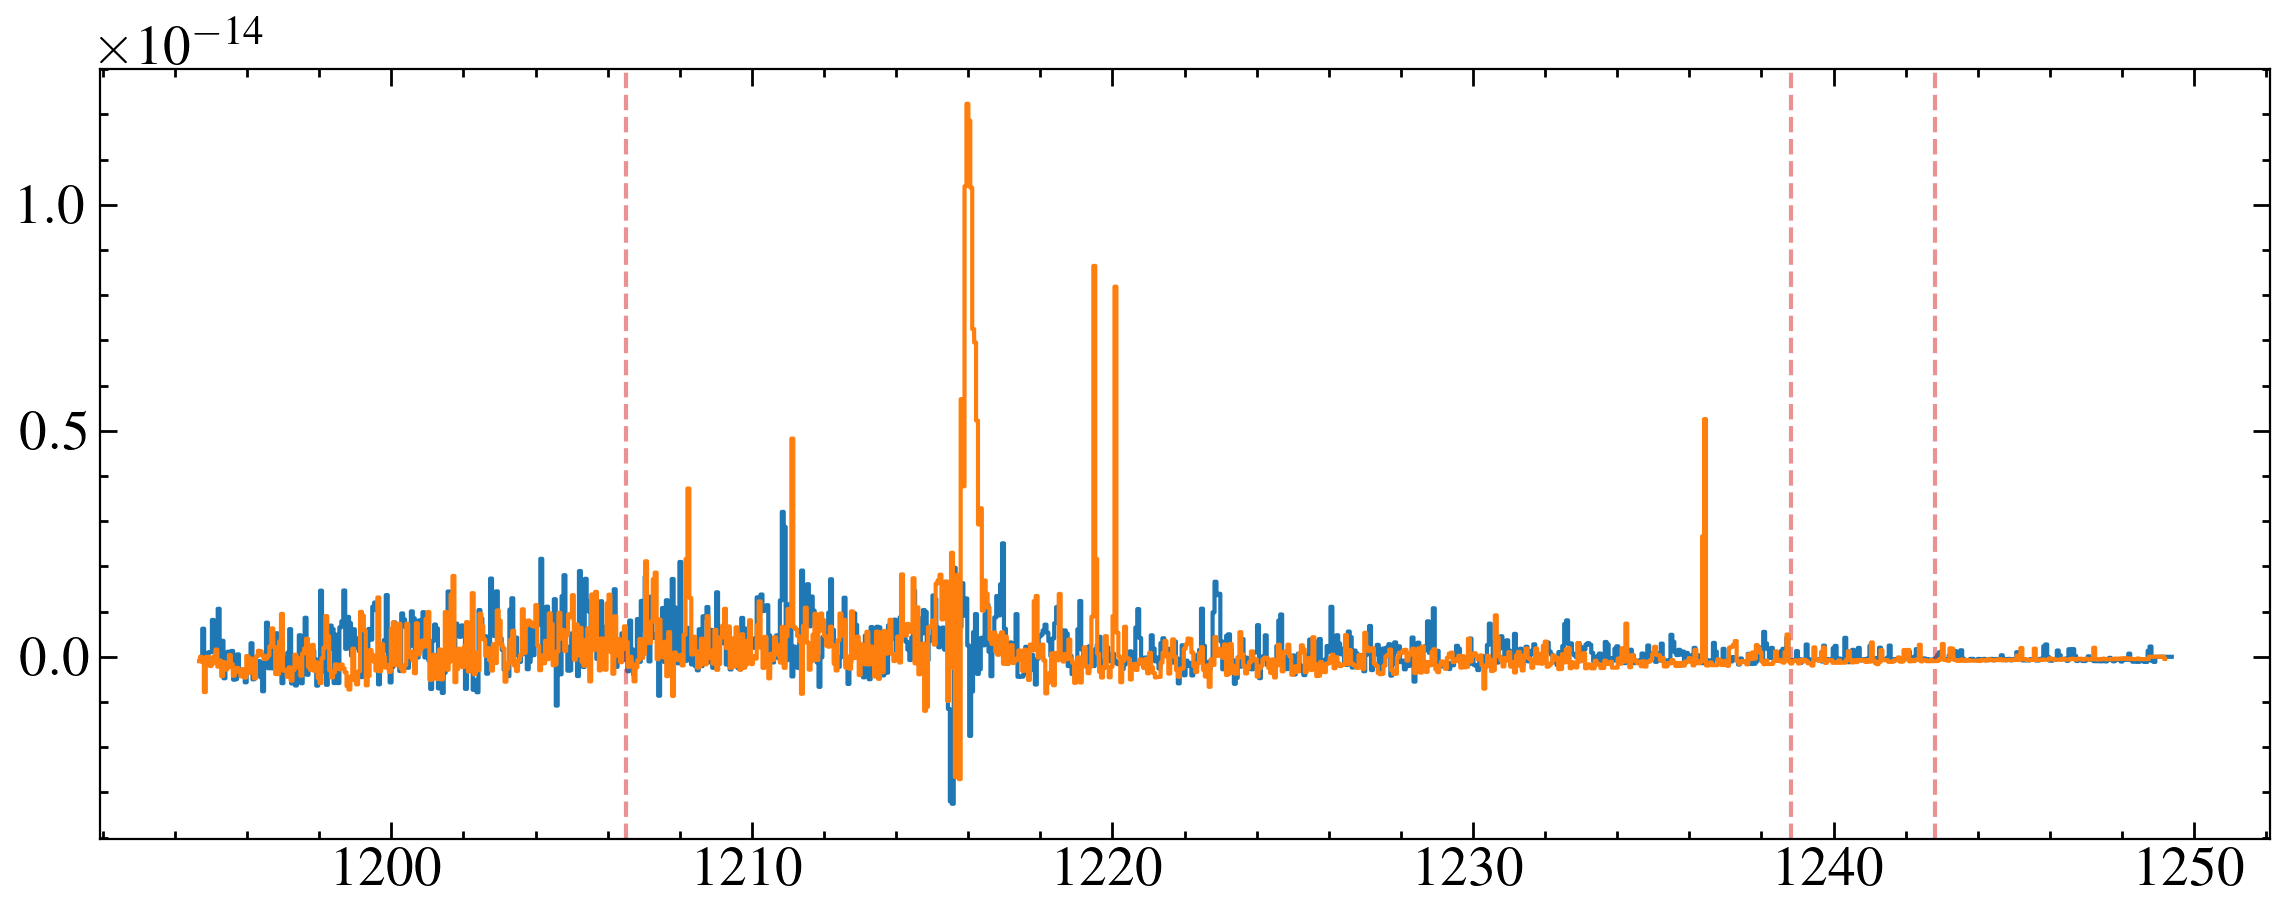

GJ163


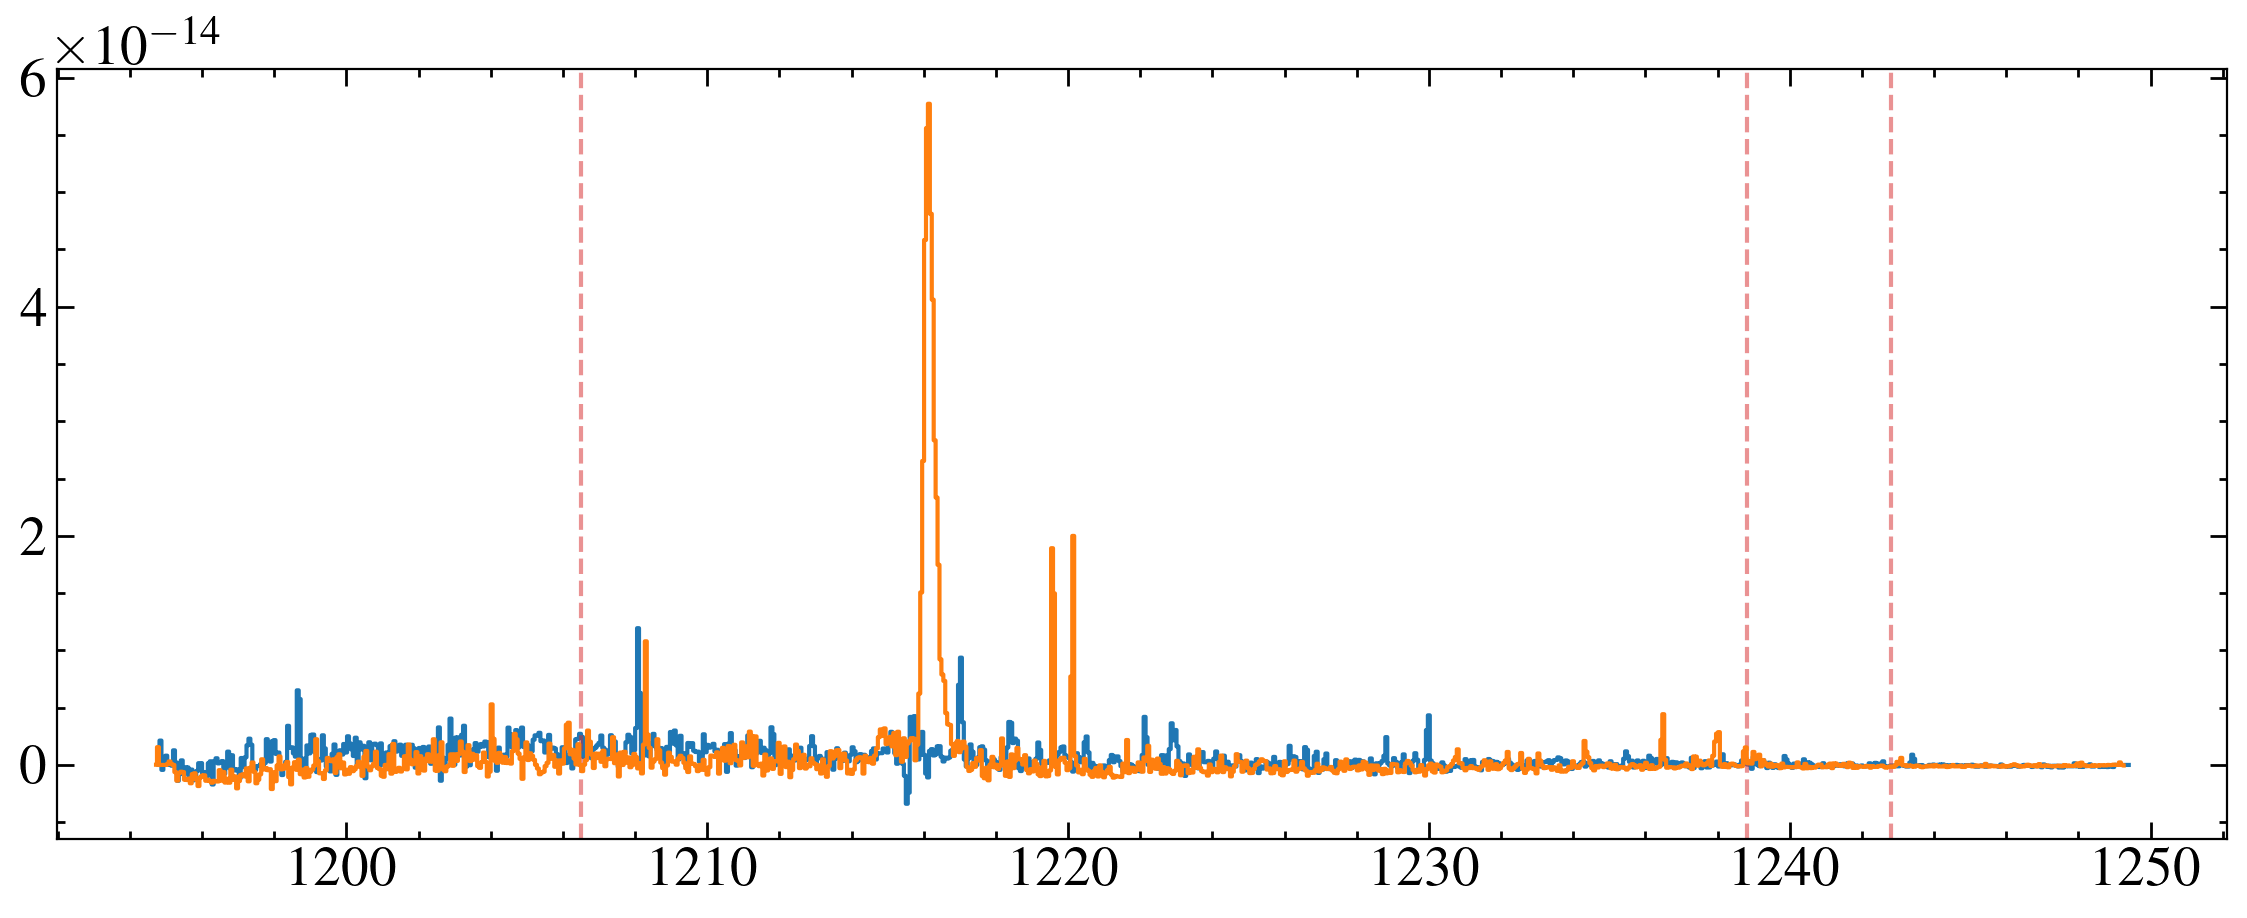

GJ849


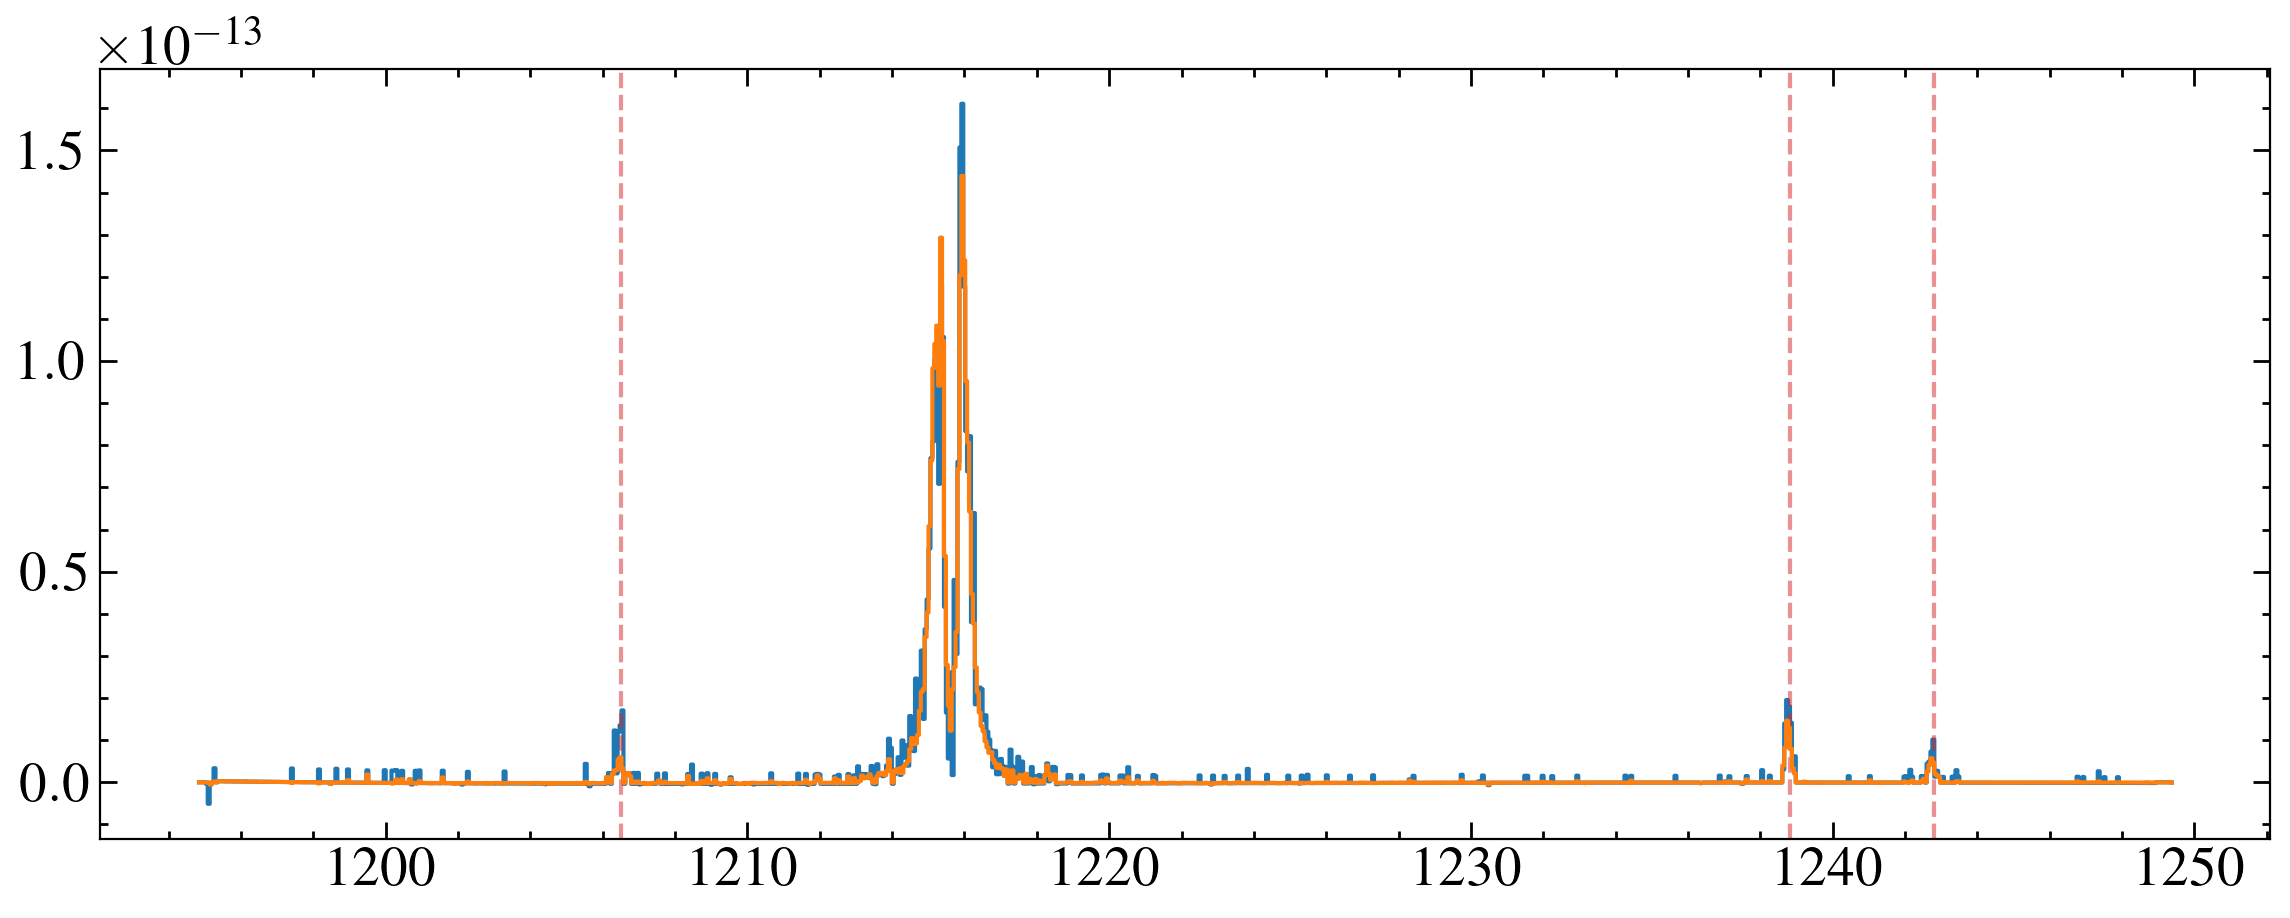

LHS-2686


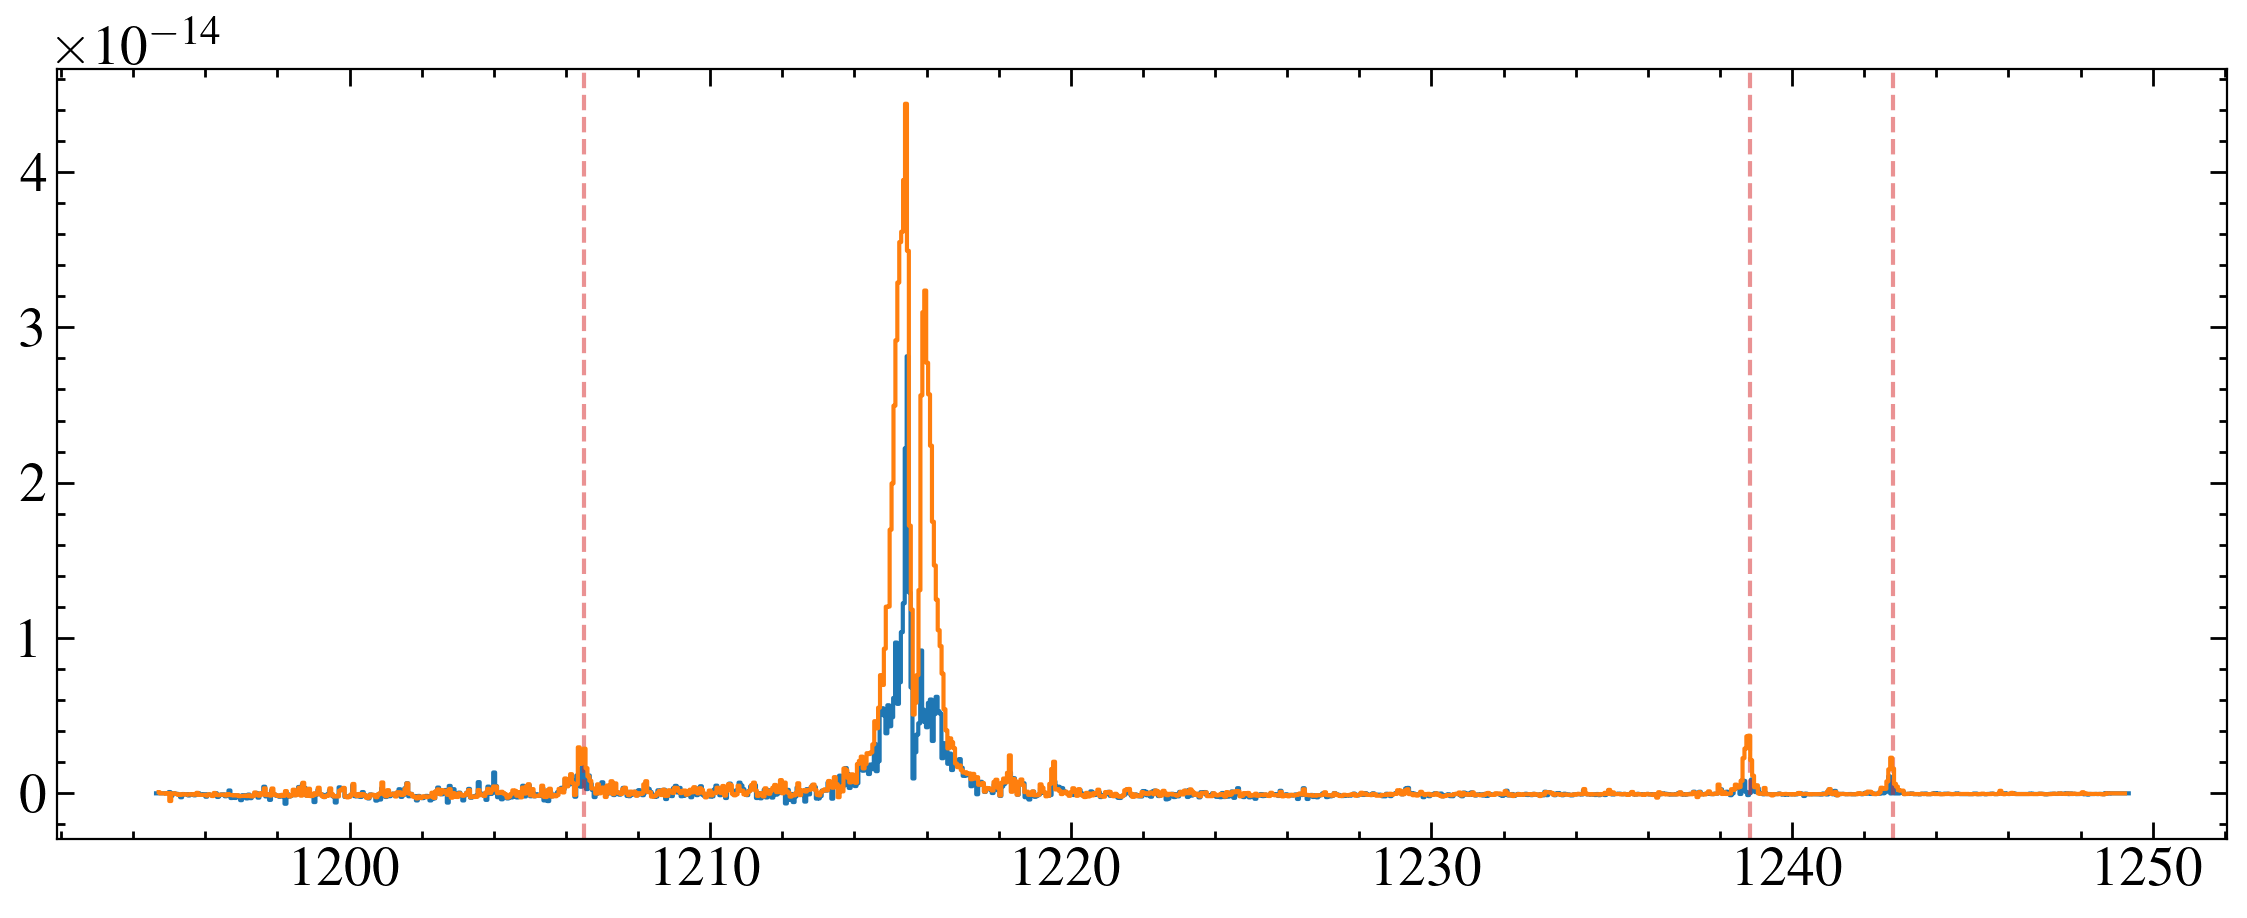

In [139]:
rstars = ['GJ1132' ,'GJ163', 'GJ849', 'LHS-2686']
lines = [1206.499, 1238.821,1242.804]
for star in rstars:
    print(star)
    fuv = glob.glob('{}{}/*g140m*'.format(path, star))
    # if len(fuv) == 0:
    #     fuv = glob.glob('{}{}/*e140m*'.format(path, star))
    if len(fuv) == 0:
        continue
    # nuv = glob.glob('{}{}/*g230l*'.format(path, star))
    
    fdata = fits.getdata(fuv[0], 1)
    fw, ff, fe = fdata['WAVELENGTH'], fdata['FLUX'], fdata['ERROR']
    
#     mask = (fw < 1210) | (fw > 1220) #mask lya
    
#     fw, ff, fe = fw[mask], ff[mask], fe[mask]
    
    
    
    # smooth = 2
    # ff = convolve(ff,Box1DKernel(smooth))
    # fe = convolve(fe,Box1DKernel(smooth))/(smooth**0.5)
    
    
    plt.step(fw, ff, where='mid')
    # plt.step(fw, fe, where='mid')
    
   
    
    
    [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
    coadd = Table.read('../lya/coadds/{}_g140m_coadd_v1.ecsv'.format(star))
    fw1, ff1, fe1 = coadd['WAVELENGTH'], coadd['FLUX'], coadd['ERROR']
    
#     mask = (fw1 < 1210) | (fw1 > 1220) #mask lya
    
#     fw1, ff1, fe1 = fw1[mask], ff1[mask], fe1[mask]
    
    plt.step(fw1, ff1, where='mid')
    
#     cos = glob.glob('{}{}/*g130m*'.format(path, star))
#     if len(cos) > 0:
#         smooth=5
#         cdata = fits.getdata(cos[0], 1)
#         cw, cf, ce = cdata['WAVELENGTH'], cdata['FLUX'], cdata['ERROR']
#         mask = (cw < 1210) | (cw > 1220) #mask lya
#         cw, cf, ce = cw[mask], cf[mask], ce[mask]
#         cf = convolve(cf,Box1DKernel(smooth))
#         ce = convolve(ce,Box1DKernel(smooth))/(smooth**0.5)
#         # plt.plot(cw, cf, alpha=0.5)#, zorder=-10)
        
    # plt.subplot(121)
    
#     plt.step(fw, ff, where='mid')
#     # plt.step(fw, fe, where='mid')
    
#     [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
#     plt.plot(cw, cf,  c='C2')#, zorder=-10)

        
#     plt.xlim(1200, 1210)
    
    
#     plt.subplot(122)
    
#     plt.step(fw, ff, where='mid')
#     # plt.step(fw, fe, where='mid')
    
#     [plt.axvline(line, ls='--', c='C3', alpha=0.5) for line in lines]
    
#     plt.plot(cw, cf, c='C2')#, zorder=-10)

        
#     plt.xlim(1235, 1245)
    
    plt.show()